# Flight Delay Prediction  
UC Berkeley, School of Information  
Authors: Tim Chen, Eugene Shen, Yang Jing, Pino Gei  
Notebooks: [Model (Main Notebook)](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/4135716278511793) | [EDA](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714) | [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683) | [GBT Toy Example](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441189954/command/1553213441189955)

## Introduction

Flight delays are common and have negative consequences for passengers, airlines, and airports. For passengers, the obvious consequence is a delayed arrival, which can be exacerbated if he/she must catch a connecting flight, causing a propagation of the initial delay throughout that person’s schedule. For the airlines, delays will cause increased costs in fuel and passenger compensation, as well as lower passenger satisfaction and possible disruptions to their subsequent flights and networks. For airports, delays can cause congestion, strain on air traffic controllers, a complete reworking of aircraft schedules, and lower passenger satisfaction. 

Delays are extremely costly - the total cost of delays in the US in 2007 was a whopping $31.2B, with $8.3B directly costing airlines, $16.7B costing passengers, $2.2B costing demand, and $4B in forgone GDP. In 2019, the delay cost per minute was $74.24, and in 2018 delayed passengers in Chicago’s O’Hare Airport spent a total of 1133 years waiting for delayed flights. It is therefore extremely beneficial to be able to predict delays and adjust accordingly. 

In this project, we attempt to tackle the problem of flight delays using machine learning with parallel computing on Databricks. The project consists of four notebooks: [Model (Main Notebook)](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/4135716278511793), [EDA](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714), [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683), and [GBT Toy Example](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441189954/command/1553213441189955).

## Current State-of-Art
The state-of-the-art performance for airline delay predicting models varies widely depending on the problem formulation and specific features/algorithms used. A variety of methods have been applied to predict flight delays as accurately as possible. Gui and Liu used a random-forest based model to achieve a 90.2% accuracy for a delay-no delay binary classification scheme in their paper, Flight Delay Prediction Based on Aviation Big Data and Machine Learning (Gui and Liu, 2019). Their method involves training models including random forest and LSTM with data from integrated air traffic control systems and multiple other supplementary datasets. Gopalakrishnan and Balakrishnan used ANNs to achieve a 94% accuracy for binary classifications and a mean prediction error of 4.7 minutes for regressions using Markov Jump Linear Systems in their paper A Comparative Analysis of Models for Predicting Delays in Air Traffic Networks (Gopalakrishnan and Balakrishnan, 2017). In particular, the highest accuracy of 94 percent was achieved with a 60-minute classification threshold for the 2-hour horizon. In addition, weather factors were not directly incorporated in their model. The authors claim that the other factors such as time-of-day, seasons, and type-of-hour (delay trends) are better proxies that indirectly account for weather conditions. Lastly, Liu and Sun used Gradient Boosted Decision Trees incorporating automatic dependent surveillance-broadcast (ADS-B) messages and achieved a 87.7% accuracy for binary classification (Liu and Sun, 2020).

## Problem Statement
We envision ourselves as a startup aiming to solve the problems of flight delays using machine learning algorithms and parallel computing frameworks to process through a large amount of airline and weather information. Our goal is to predict a flight's **departure delay**, with a threshold of **15 minutes.** In other words, a flight is delayed if it arrives 15 minutes or later than its original scheduled time of departure. 

Our justification for the 15-mintue threshold is that as a startup, we aim to build a generic model that can be further catered and optimized according to the clients’ requests. As discussed, a flight delay can impact at least three key stakeholders: airlines, airports, and passengers. Different stakeholders might demand different requirements for the model depending on their objectives. For example, an airline might want to optimize against for a shorter threshold if its objective is to improve passenger satisfaction while an airport might aim for a longer delay prediction if the goal is to maintain a balance between safety and operational inefficiency. Passengers, on the other hand, would have zero tolerance on false positive; otherwise, they could easily miss the on-time flight if they choose to leave the terminal in the presence of a delay prediction. Therefore, from a business perspective, there can be high costs associated with both false-negative and false-positive prediction depending on the stakeholders and their respective objectives:

![Delay Cost Analysis](https://www.dropbox.com/s/v26wjzt1yqp0vm9/delay_cost_small.png?raw=1)
  
**Costs Associated with False-Negative**: A false-negative perdition (i.e. wrongly predicted on-time) can be costly to an airline because of the passenger dissatisfaction it can cause. Wrongly predicted on-time departures or arrivals can also cause unnecessary stress on an airport's operations, but the additional time passengers spend in the airport can potentially lead to an increase of revenues (e.g. additional shopping activities during the wait time). Note that from an airline's perspective, deploying a naïve model with 100% negative predictions (i.e. always predicting “on-time” regardless of input signals) is equivalent of deploying no model at all because most airlines and passengers by default plan their operations or trips assuming an on-time schedule. As such, for our model to be useful for an airline, our final model should not incur a higher cost than does an “always-negative model”.

**Costs Associated with False-Positive**: A false-positive prediction (i.e. wrongly predicted delay) can be even more disastrous for an airline. For example, passengers who are notified of a delay might leave the terminal and would miss the flight that actually arrives on time. It could also cause chaos if the airport allocates the spot to another flight based on the wrong predictions.

Lastly, our prediction is done **two hours** ahead of the flight's original scheduled time, which has an important implication on how the model should be optimized as well as how feature engineering should be done in order to avoid time leakage (i.e. using future data to predict past delays).

## Evaluation Metrics

Our prediction task is a binary classification, with **1 indicating "15-minute delay"** and **0 indicating "on-time."** Our primary metric is **F0.5**, with **PR AUC** as a secondary metric throughout the training.

The main reason for choosing the 15-minute delay as the outcome variable is that as a startup, and we prefer to follow the industry standard. The 15-minute delay is widely accepted by airlines and airports as well as in the field of academic research. By adopting to the 15-mintue delay threshold, we are not only able to effectively communicate our results to potential clients but also learn from the latest research with state-of-art performance. We can also further fine-tune our model based on the specific business scenario provided by the client.

F0.5 and PR AUC are our chosen metrics for two reasons: First, while our goal as a startup is to keep our model as generic as possible before acquiring the specific requirements from potential clients (e.g. airports vs. airlines), we do want to put an emphasis on the positive predictions and focus on the delay instead of on-time predictions. Between precision and recall, we believe that precision would make a stronger business case because a higher precision means that our clients can have a higher confidence to take action based on our predictions. A 100% precision, for example, means that our client can feel confident to take appropriate action against the delay without incurring the costs of a false positive prediction.

The second reason is that as explained later in the [EDA notebook]( https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505113/command/37954262505114), the dataset is unbalanced between the positive and negative examples, with only ~20% of the data being positive. Relying primarily on metrics such as ROC AUC can be misleading because the metric is conditional on only the true labels (i.e. specificity and recalls) while ignore the performance of metrics such as precision that are conditional on the predicted positive examples. In other words, given the imbalanced data, ROC AUC can be high even when the model suffers from a poor performance on precision! PR AUC, however, is not subject to the issue of an imbalanced dataset and we use it as a secondary metric throughout the process to aid our model fine-tuning and selection.

## Datasets
Our model leverages a total of five datasets from multiple sources including BTS (Bureau of Transportation Statistics) and NCEI (National Centers for Environmental Information):  
- **Airlines** from BTS includes statistics about a total of 31,746,841 domestic flights in the US from 2015 to 2019.
  - Size: ~1GB
  - Source: Airline On-Time Performance Data from BTS, [https://tinyl.io/3cx9](https://tinyl.io/3cx9)
- **Global Weather** from NCEI includes historical weather data with 630,904,436 entries across the globe from 2015 to 2019. 
  - Size: ~25GB
  - Source: Global Integrated Surface Dataset from NCEI, [https://tinyl.io/3cSL](https://tinyl.io/3cSL) | [https://tinyl.io/3iIG](https://tinyl.io/3iIG)
- **Weather Stations Metadata** from NCEI includes the metadata about the weather stations where the weather data from NCEI are collected. 
  - Size: ~340KB
  - Source: Master Station History Report from NCEI, [https://tinyl.io/3cSk](https://tinyl.io/3cSk)
- **Airport Coordinates** from BTS includes the coordinates of all airports in the US.
  - Size: ~743KB
  - Source: Aviation Support Master Coordinate from BTS, [https://tinyl.io/3cSb](https://tinyl.io/3cSb)
- **Airport Time Zone** includes the mapping between airports and their respective time zones. 
  - Size: ~180KB
  - Source: Datuetil, [https://tinyurl.com/yhmy5bz2](https://tinyurl.com/yhmy5bz2)

## End-to-End Pipeline
Our end-to-end pipeling is summarized by the following flow chart:  

![Training Pipeline](https://www.dropbox.com/s/tgmv2b2kn0pdfh0/pipeline.png?raw=1)

**Research & EDA**: Our process starts with research on the airline industry, how weather information is interpreted, and the current state-of-art algorithms for predicting delays. We have also conducted an interview with a real pilot to gain insights on airline and airport operations. Backed by our research and information from interview, we perform EDA to analyze the datasets, and test our hypothesis.

**Data Pre-Processing**: Our pipeline starts with cleaning, parsing, and joining raw data. In this stage, time and space complexity are our goal. Our final join, for example, took only 5+ minutes and the overall data size go from 26+ GB to 3.46GB. With insights drawn from our research, pilot interview, and EDA, we build a total of 41 new features that fall under 6 buckets, most of which are time series that account for the hypothesized delay propagation. Last but not least, we split our data by years into training, validation, and test.

**Modeling & Evaluation**: We start by building a total of 4 baseline models: Logistic Regression, SVM, Random Forrest, and Gradient Boosted Forrest (GBT). During this stage, we also perform feature selection using a combination of WOE, judgement backed by research/interview/EDA, and trial-and-error. We choose GBT as our final model and fine-tune select hyperparameters using k-fold cross-validation. Lastly, we train our final model using the fine-tuned hyperparameters and test the performance using our test dataset. The pipeline ends with an error analysis, focusing mainly on false negatives, and a conclusion with recommended next steps.

**Primary Data**: We use a total of five datasets. Our two primary datasets are Airlines and Weather, with the other three datasets used mainly for with EDA or as complementary data specifically for joining the two primary datasets.

## Notebook Setup
The section contains codes that set ups the various file path constants and PySpark data frames that are used throughout the notebook. The schemas for the two main datasets, airline and weather, are also printed as a reference.

In [0]:
!pip install natsort

Collecting natsort
 Downloading natsort-7.1.1-py3-none-any.whl (35 kB)
Installing collected packages: natsort
Successfully installed natsort-7.1.1

In [0]:
# spark
import pyspark.sql
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.window import Window 
from pyspark.ml import Pipeline

# pyspark ml
from pyspark.ml.feature import PCA
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import FloatType, IntegerType

# analytics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from graphframes import *
from natsort import index_natsorted

# others
from sklearn.metrics import confusion_matrix
from functools import reduce
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import itertools
import random
import time

# plot configs 
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)

# config constants
IS_LOCAL = False # set true if running at local machine
if IS_LOCAL:
    app_name = "w261_fp"
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
    sc = spark.sparkContext
    sqlContext = SQLContext(sc)
    
    ROOT = './'
    PARQ_AIR_2015_Q1 = ROOT + 'data/3m'
else:
    # prefixes
    ROOT                 = 'dbfs:/mnt/mids-w261/datasets_final_project/'
    ROOT_TEAM30_DBFS     = 'team_30/' # DBFS root mostly for pandas reading; pandas has no write access to it
    ROOT_TEAM30_URL      = 'dbfs:/team_30/' # mostly for dbutils/spark
    
    # final merged master
    MASTER_FULL          = ROOT_TEAM30_URL + 'master.parquet'
    MASTER_2019          = ROOT_TEAM30_URL + 'master_2019.parquet'
    MASTER_STEROID_FULL  = ROOT_TEAM30_URL + 'master_steroid.parquet'
    
    # 3rd party files
    PARQ_AIR_2019        = ROOT + 'parquet_airlines_data/2019.parquet'
    PARQ_AIR_FULL        = ROOT + 'parquet_airlines_data/201*.parquet'
    PARQ_WEATHER_2019    = ROOT + 'weather_data/weather2019a.parquet'
    PARQ_WEATHER_TEST    = ROOT + 'weather_data/weather2015a.parquet/part-00025-tid-*.snappy.parquet'
    PARQ_WEATHER_FULL    = ROOT + 'weather_data/*.parquet'
    PARQ_STATIONS_FULL   = 'dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz'
    CSV_AIRPORT_MASTER   = ROOT_TEAM30_URL + '689421012_T_MASTER_CORD.csv'
    CSV_TZMAP            = ROOT_TEAM30_URL + 'iata.tzmap' # mapping airport to time zone
    
    # 1st party parquets
    PARQ_AIR_CLEAN_FULL           = ROOT_TEAM30_URL + 'airlines_clean_full.parquet'
    PARQ_AIR_CLEAN_2019           = ROOT_TEAM30_URL + 'airlines_clean_2019.parquet'
    PARQ_AIR_CLEAN_FULL_ALL       = ROOT_TEAM30_URL + 'airlines_clean_full_include_cancel_divert.parquet' # include cancel & divert
    PARQ_AIR_CLEAN_2019_ALL       = ROOT_TEAM30_URL + 'airlines_clean_2019_include_cancel_divert.parquet' # include cancel & divert
    PARQ_WEATHER_CLEAN_FULL       = ROOT_TEAM30_URL + 'weather_clean_full_v5.parquet'
    PARQ_WEATHER_STATIONS_FULL    = ROOT_TEAM30_URL + 'weather_stations_full.parquet'
    PARQ_AIR_STATION_MAP          = ROOT_TEAM30_URL + 'airports_weather_mapping_v8.parquet'    

In [0]:
# master on steroid; master with all custom-built features
master_steroid_df = spark.read.option("header", "true").parquet(MASTER_STEROID_FULL).cache()

# master with barebone data and no custom-built features
master_full_df = spark.read.option("header", "true").parquet(MASTER_FULL).cache()
master_2019_df = spark.read.option("header", "true").parquet(MASTER_2019).cache()

# airlines
airlines_2019_df           = spark.read.option("header", "true").parquet(PARQ_AIR_2019).cache()
airlines_full_df           = spark.read.option("header", "true").parquet(PARQ_AIR_FULL).cache()
airlines_clean_2019_df     = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_2019).cache()
airlines_clean_full_df     = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_FULL).cache() # final df used for merge
airlines_clean_2019_all_df = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_2019_ALL).cache() # df for experiment; include cancel & divert
airlines_clean_full_all_df = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_FULL_ALL).cache() # df for experiment; include cancel & divert

# weather
weather_full_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_FULL).cache()
weather_2019_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_2019).cache()
weather_test_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_TEST).cache()
weather_clean_full_df = spark.read.option("header", "true").parquet(PARQ_WEATHER_CLEAN_FULL).cache()

# datasets for airport-ws mapping
weather_stations_df = spark.read.option("header", "true").parquet(PARQ_WEATHER_STATIONS_FULL).cache() 
air_station_map_df  = spark.read.option("header", "true").parquet(PARQ_AIR_STATION_MAP).cache() # final airport-ws mapping
stations_full_df    = spark.read.option("header", "true").csv(PARQ_STATIONS_FULL).cache() 
airport_master_df   = spark.read.option("header", "true").csv(CSV_AIRPORT_MASTER).cache()
tzmap_df            = spark.read.csv(CSV_TZMAP, header="false", sep='\t', inferSchema="false").cache()

### Airlines Schema

In [0]:
airlines_full_df.printSchema()

root
-- YEAR: integer (nullable = true)
-- QUARTER: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- FL_DATE: string (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- OP_CARRIER_FL_NUM: integer (nullable = true)
-- ORIGIN_AIRPORT_ID: integer (nullable = true)
-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_CITY_NAME: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- ORIGIN_STATE_FIPS: integer (nullable = true)
-- ORIGIN_STATE_NM: string (nullable = true)
-- ORIGIN_WAC: integer (nullable = true)
-- DEST_AIRPORT_ID: integer (nullable = true)
-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
-- DEST_CITY_MARKET_ID: integer (nullable = true)
-- DEST: string (nullable = true)
-- DEST_CITY_NAME: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEST_STATE_FIPS: integer (nullable = true)
-- DEST_STATE_NM: string (nullable = true)
-- DEST_WAC: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DEP_TIME: integer (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DELAY_NEW: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DEP_DELAY_GROUP: integer (nullable = true)
-- DEP_TIME_BLK: string (nullable = true)
-- TAXI_OUT: double (nullable = true)
-- WHEELS_OFF: integer (nullable = true)
-- WHEELS_ON: integer (nullable = true)
-- TAXI_IN: double (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ARR_TIME: integer (nullable = true)
-- ARR_DELAY: double (nullable = true)
-- ARR_DELAY_NEW: double (nullable = true)
-- ARR_DEL15: double (nullable = true)
-- ARR_DELAY_GROUP: integer (nullable = true)
-- ARR_TIME_BLK: string (nullable = true)
-- CANCELLED: double (nullable = true)
-- CANCELLATION_CODE: string (nullable = true)
-- DIVERTED: double (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- ACTUAL_ELAPSED_TIME: double (nullable = true)
-- AIR_TIME: double (nullable = true)
-- FLIGHTS: double (nullable = true)
-- DISTANCE: double (nullable = true)
-- DISTANCE_GROUP: integer (nullable = true)
-- CARRIER_DELAY: double (nullable = true)
-- WEATHER_DELAY: double (nullable = true)
-- NAS_DELAY: double (nullable = true)
-- SECURITY_DELAY: double (nullable = true)
-- LATE_AIRCRAFT_DELAY: double (nullable = true)
-- FIRST_DEP_TIME: integer (nullable = true)
-- TOTAL_ADD_GTIME: double (nullable = true)
-- LONGEST_ADD_GTIME: double (nullable = true)
-- DIV_AIRPORT_LANDINGS: integer (nullable = true)
-- DIV_REACHED_DEST: double (nullable = true)
-- DIV_ACTUAL_ELAPSED_TIME: double (nullable = true)
-- DIV_ARR_DELAY: double (nullable = true)
-- DIV_DISTANCE: double (nullable = true)
-- DIV1_AIRPORT: string (nullable = true)
-- DIV1_AIRPORT_ID: integer (nullable = true)
-- DIV1_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV1_WHEELS_ON: integer (nullable = true)
-- DIV1_TOTAL_GTIME: double (nullable = true)
-- DIV1_LONGEST_GTIME: double (nullable = true)
-- DIV1_WHEELS_OFF: integer (nullable = true)
-- DIV1_TAIL_NUM: string (nullable = true)
-- DIV2_AIRPORT: string (nullable = true)
-- DIV2_AIRPORT_ID: integer (nullable = true)
-- DIV2_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV2_WHEELS_ON: integer (nullable = true)
-- DIV2_TOTAL_GTIME: double (nullable = true)
-- DIV2_LONGEST_GTIME: double (nullable = true)
-- DIV2_WHEELS_OFF: integer (nullable = true)
-- DIV2_TAIL_NUM: string (nullable = true)
-- DIV3_AIRPORT: string (nullable = true)
-- DIV3_AIRPORT_ID: integer (nullable = true)
-- DIV3_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV3_WHEELS_ON: integer (nullable = true)
-- DIV3_TOTAL_GTIME: double (nullable = true)
-- DIV3_LONGEST_GTIME: double (nullable = true)
-- DIV3_WHEELS_

### Weather Schema

In [0]:
weather_full_df.printSchema()

root
-- STATION: string (nullable = true)
-- DATE: timestamp (nullable = true)
-- SOURCE: short (nullable = true)
-- LATITUDE: double (nullable = true)
-- LONGITUDE: double (nullable = true)
-- ELEVATION: double (nullable = true)
-- NAME: string (nullable = true)
-- REPORT_TYPE: string (nullable = true)
-- CALL_SIGN: string (nullable = true)
-- QUALITY_CONTROL: string (nullable = true)
-- WND: string (nullable = true)
-- CIG: string (nullable = true)
-- VIS: string (nullable = true)
-- TMP: string (nullable = true)
-- DEW: string (nullable = true)
-- SLP: string (nullable = true)
-- AW1: string (nullable = true)
-- GA1: string (nullable = true)
-- GA2: string (nullable = true)
-- GA3: string (nullable = true)
-- GA4: string (nullable = true)
-- GE1: string (nullable = true)
-- GF1: string (nullable = true)
-- KA1: string (nullable = true)
-- KA2: string (nullable = true)
-- MA1: string (nullable = true)
-- MD1: string (nullable = true)
-- MW1: string (nullable = true)
-- MW2: string (nullable = true)
-- OC1: string (nullable = true)
-- OD1: string (nullable = true)
-- OD2: string (nullable = true)
-- REM: string (nullable = true)
-- EQD: string (nullable = true)
-- AW2: string (nullable = true)
-- AX4: string (nullable = true)
-- GD1: string (nullable = true)
-- AW5: string (nullable = true)
-- GN1: string (nullable = true)
-- AJ1: string (nullable = true)
-- AW3: string (nullable = true)
-- MK1: string (nullable = true)
-- KA4: string (nullable = true)
-- GG3: string (nullable = true)
-- AN1: string (nullable = true)
-- RH1: string (nullable = true)
-- AU5: string (nullable = true)
-- HL1: string (nullable = true)
-- OB1: string (nullable = true)
-- AT8: string (nullable = true)
-- AW7: string (nullable = true)
-- AZ1: string (nullable = true)
-- CH1: string (nullable = true)
-- RH3: string (nullable = true)
-- GK1: string (nullable = true)
-- IB1: string (nullable = true)
-- AX1: string (nullable = true)
-- CT1: string (nullable = true)
-- AK1: string (nullable = true)
-- CN2: string (nullable = true)
-- OE1: string (nullable = true)
-- MW5: string (nullable = true)
-- AO1: string (nullable = true)
-- KA3: string (nullable = true)
-- AA3: string (nullable = true)
-- CR1: string (nullable = true)
-- CF2: string (nullable = true)
-- KB2: string (nullable = true)
-- GM1: string (nullable = true)
-- AT5: string (nullable = true)
-- AY2: string (nullable = true)
-- MW6: string (nullable = true)
-- MG1: string (nullable = true)
-- AH6: string (nullable = true)
-- AU2: string (nullable = true)
-- GD2: string (nullable = true)
-- AW4: string (nullable = true)
-- MF1: string (nullable = true)
-- AA1: string (nullable = true)
-- AH2: string (nullable = true)
-- AH3: string (nullable = true)
-- OE3: string (nullable = true)
-- AT6: string (nullable = true)
-- AL2: string (nullable = true)
-- AL3: string (nullable = true)
-- AX5: string (nullable = true)
-- IB2: string (nullable = true)
-- AI3: string (nullable = true)
-- CV3: string (nullable = true)
-- WA1: string (nullable = true)
-- GH1: string (nullable = true)
-- KF1: string (nullable = true)
-- CU2: string (nullable = true)
-- CT3: string (nullable = true)
-- SA1: string (nullable = true)
-- AU1: string (nullable = true)
-- KD2: string (nullable = true)
-- AI5: string (nullable = true)
-- GO1: string (nullable = true)
-- GD3: string (nullable = true)
-- CG3: string (nullable = true)
-- AI1: string (nullable = true)
-- AL1: string (nullable = true)
-- AW6: string (nullable = true)
-- MW4: string (nullable = true)
-- AX6: string (nullable = true)
-- CV1: string (nullable = true)
-- ME1: string (nullable = true)
-- KC2: string (nullable = true)
-- CN1: string (nullable = true)
-- UA1: string (nullable = true)
-- GD5: string (nullable = true)
-- UG2: string (nullable = true)
-- AT3: string (nullable = true)
-- AT4: string (nullable = true)
-- GJ1: string (nullable = true)
-- MV1: string (nullable = true)
-- GA5: string (nullable = true)
-- CT2: string (nullable = true)
-- CG2: string

## Exploratory Data Analysis
The [EDA notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714) includes a total of 15 EDAs are included, all of which provide important inputs to our feature engineering/selection and model training/fine-tuning. The 14 EDAs are separated into four broad categories: 
- **Dataset Attributes**
- **Airlines**  
  - Airport Rush Hours
  - Delay Propagation
  - Long Delays Are NOT Just Long
  - Delay Seasonality
  - Why Do Flights Get Delayed?
  - Correlation Matrix
  - Flights Missing Key Information
- **Airports**
  - Where Are the Airports?
  - Moving Airports!?
  - Airport Stress PageRank
  - Airport Transfer Degrees
- **Weather**
  - Empty Weather Dataset!?
  - Where Are the Weather Stations?

Two key lessons from EDAs (examplified by the two plots below) have a significant impact on our feature engineering: Delays propagate through time (if a flight departs late, it arrives late), and delays are highly seasonal even by hours. Many of our features are based on the hypothesis that **a delay is best predicted by another delay**. A detailed description for the two plots below along with other key findings from EDA can be found in the [EDA notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714).

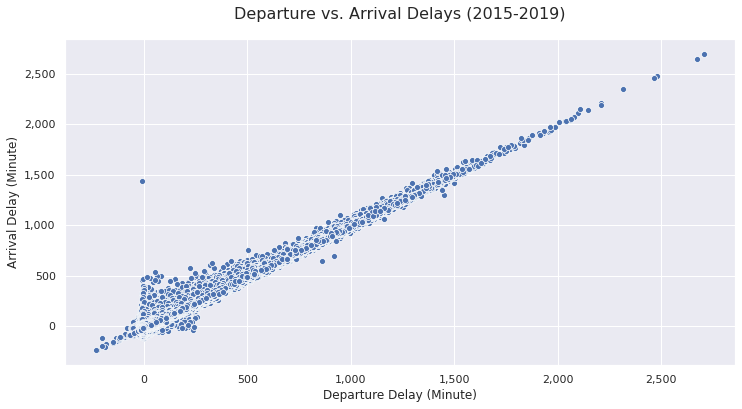

In [0]:
"""Delays propagate through time. If a flight departs late, it arrives late.
"""
pddf = airlines_full_df.where(f.col('DEP_DELAY').isNotNull()) \
                       .select('DEP_DELAY', 'ARR_DELAY') \
                       .toPandas()

fig, ax = plt.subplots(1, figsize=(12, 6))
corr = pddf.corr()
sns.scatterplot(data=pddf, x="DEP_DELAY", y="ARR_DELAY")

ax.set_title('Departure vs. Arrival Delays (2015-2019)', fontsize=16, pad=20)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax.set_xlabel("Departure Delay (Minute)")
ax.set_ylabel("Arrival Delay (Minute)")
pass

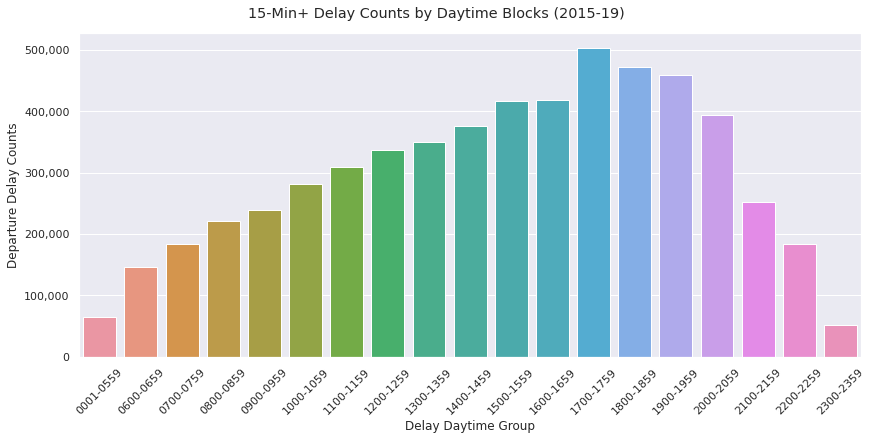

In [0]:
delay_daytime_blk_pddf = airlines_clean_full_df.select('DEP_TIME_BLK') \
                                               .where((f.col('CANCELLED') == 0) & 
                                                      (f.col('DEP_DEL15') == 1)).toPandas()
delay_daytime_blk_pddf = delay_daytime_blk_pddf.sort_values(by='DEP_TIME_BLK')

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle("15-Min+ Delay Counts by Daytime Blocks (2015-19)")
sns.countplot(x="DEP_TIME_BLK", data=delay_daytime_blk_pddf, ax=ax)

ax.set_xlabel("Delay Daytime Group")
ax.set_ylabel("Departure Delay Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=45)
pass

## Data Cleaning & Join  
Notebook: [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683)  
 
Airlines (1GB) and Weather (25GB) are our primary datasets. Cleaning and joining the two datasets are a key step prior to feature engineering and modeling. As such, we have spent a significant time making sure that the process is **optimized for both time and space complexity**. Our process takes a total of five datasets as the inputs, and the final join took 5 minutes with the overall dataset reduced from 26+ GB to 3.46 GB. Below is a diagram that summarizes our join process. The details of the flow can be found in the notebook, [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683).

![Joining Airlines & Weather](https://www.dropbox.com/s/k4k15vzc33a030m/join_s.png?raw=1)

Note that during the data cleaning stage, we remove cancelled and diverted flights. The justification for the removal is detailed in the [Data Cleaning & Join notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683), but the two main reasons are that including cancelled and diverted flights will cause unnecessary bias in our model, and that the predictions for which provide little no no business value.

## Feature Engineering
We spent a large portion of our time brainstorming, building, and testing new features. We built a total of 41 features that fall under 6 different buckets:  
  
![Feature Buckets](https://www.dropbox.com/s/5d8hq99rief4gdr/features.png?raw=1)
  
- **Temporal** features explore the seasonality of flight delays, by month, day of the week, and hour of the day.
- **Operations** features account for characteristics of airline and airport operations. Examples include the distance of a flight’s prior trip and its ground time in the airport between its arrival and next departure.
- **Weather** features describe the status of the weather at the prediction time. We have built custom indicator (e.g. visibility, ice point, and fog risk) based on our interview with a real pilot.
- **Delay Propagation** explores the hypotheses that “delays propagate” and “delays cause other delays” both through time and space. For example, we hypothesize that a late arrival would propagate and cause a late departure (i.e. time propagation). We also hypothesize that a delay in could increase an airport’s operational stress and cause other flights to delay (i.e. space propagation). 
- **Airport Stress** measure the stress of an airport.
- **Flight Route Stress** measures the stress of an origin-destination pair route.

Note that a feature can belong to more than one category. For example, ` DEP_DEL_DEST_TREND_UP_1HR` measures if the number of delays in an airport is current trending up at the prediction time. The feature in a proxy for both airport stress and delay propagation. Also note that categories such as Airport Stress and Route Stress consists of two different types of features: Trend and Current Status. Trend features indicate if the current stress is going up (1) or down (0) while the Current Status features measure the stress at the prediction time. Overall, we find that operations, delay propagation, and airport stress features are particularly useful in improving the performance of our chosen models and training strategy.

### General Leakage Prevention Strategy
In this section, we present a simple case study on how leaks are generally prevented in our queries. Let's say we have a flight with a CRS departure time at 16:00. The require prediction takes place 2 hours prior to the CRS departure time at 14:00. In the first scenario, the flight arrives at the airport prior to 13:45, and we have all the prior arrival information including delay minutes, delay indicator (1 or 0), and 15-minute delay indicator (1 or 0).

![Delay 01](https://www.dropbox.com/s/x4eqm0x0acnw3vl/delay_01.png?raw=1)

If the flight arrives between the predication time and 15 minutes prior to the prediction time, the flight's prior 15-minute arrival delay becomes unavailable. The prior arrival delay minute is partially available (only up to the difference between the prediction time and the CRS arrival time), and the prior arrival (1 or 0) is available.  

![Delay 02](https://www.dropbox.com/s/s1w8vm74o75p81c/delay_02.png?raw=1)

Lastly, if the flight arrives after the prediction time, no prior arrival delay information is available.  

![Delay 03](https://www.dropbox.com/s/7w3aji1mxilldib/delay_03.png?raw=1)

Note that the case study above illustrates only how leaks are prevented for features related to prior arrivals, but a similar analysis is performed for all lag features that we build and test.

### Building New Features

#### Prior Departure/Arrival Delay, Prior Flight Distance, and Aircraft Park Time
In this section, we build the following features:
- multiple prior departure/arrival delay indicators
- `CRS_GROUND_TIME_HOUR`, a feature to indicate the ground time between a plane's prior arrival and its next departure. 
- `PRIOR_FLIGHT_DISTANCE`, a feature that records the distance the prior flight's distance travelled.

We hypothesize that a late prior arrival can propagate to cause a late departure. We aslo hypothesize that both park time and distance travelled could have an impact on departure delay. Note we have instituted multiple measures to prevent data leakage (i.e. using future data to predict current delays).

`PRIOR_ARR_DEL_INDEX` tells a flight's prior arrival delay information (i.e. the arrival before the departure), and can have the following values:
- 0 if on-time 
- 1 if late prior arrival
- 2 if early prior arrival & time length >= 15 minutes
- 3 if ground time >= 4 hours
- 4 if ground time <= 2 hours & flight has not arrived (so we don't know if there is a late arrival)
- -1 if delay info is not available for all other reasons such as a cancelled flight''')  
  
`PRIOR_ARR_DEL15` tells if the prior arrival delay is 15 minutes or longer, and can have the following values:
- 0 if the prior arrival is on-time or if the delay is less than 15 minutes
- 1 if the prior arrival delay is 15 minutes or longer
- -1 if the prior arrival delay is not available at prediction time. This can happen if the CRS arrival time is not at least 15 minutes before the prediction time. 

`PRIOR_ARR_DEL_MINUTE` gives the actual delay minutes, if the delay information is avaliable, and can have the following values:
- 0 if the information is not available. This can happen if `PRIOR_ARR_DEL_INDEX` is equal to 3 or -1.
- Otherwise, the feature gives the actual minutes of the prior arrival delay.

`CRS_GROUND_TIME_HOUR` is measured in hours and can have the following values:
- 0.75 if the information is not available. The scenario is very unlikely and can happen due to the limited time range of our dataset. For example, we do not have the prior flight information for the very first flight of each aircraft on January 1st, 2015. We set it to 0.75 hour as this is roughly the median of the entire dataset.
- Otherwise, the feature gives the difference between `CRS_DEP_TIME_UTC` and `PRIOR_ARR_TIME_UTC` and tells the length of the ground time before an aircraft's next arrival.

`PRIOR_DEP_DEL_MINUTES` gives the actual minutes of the prior departure delay if available. 
- 0 if the information is not available. The scenario is very unlikely but can happen if the prior flight information is missing (e.g. first flight of 2015 since our dataset only goes as far back as 2015).
- Otherwise, it gives the actual minutes of the prior departure delay.

`PRIOR_DEP_DEL15` indicates if the prior departure is delayed, and can have the following values:
- 0 if the prior departure is on-time or if the delay is shorter than 15 minutes
- 1 is the prior departure delay is 15 minutes or longer 
- -1 if the prior departure delay information is not available. This can happen if the prediction time is within 15 minutes after the CRS departure time. The scenario is unlikely.

`PRIOR_DISTANCE` and `PRIOR_DISTANCE_GROUP` indicates the distance that the prior flight travels from prior origin to destination (i.e. current origin).

In [0]:
AIR_DF = airlines_clean_full_all_df
EARLY_ARR_MINUTE_THD = -15
LONG_GROUND_TIME_THD = 4

airlines_df = AIR_DF
# airlines_df = airlines_clean_2019_df.where(f.col('MONTH')==1).cache()
airlines_df = airlines_df.select('ID', 'TAIL_NUM', 'FL_DATE', 'ORIGIN', 'DEST', 
                                 'CRS_DEP_TIME_UTC', 'CRS_ARR_TIME_UTC', 
                                 'ARR_TIME_UTC', 'ARR_DELAY', 'ARR_DEL15', 'DEP_DEL15', 'DEP_DELAY',
                                 'DISTANCE_GROUP', 'DISTANCE', 'DIVERTED', 'CANCELLED')
# build lag columns
win = Window.partitionBy('TAIL_NUM').orderBy(f.col('CRS_ARR_TIME_UTC').asc())
airlines_df = airlines_df.withColumn('PRIOR_DEST',             f.lag('DEST', 1, None).over(win)) \
                         .withColumn('PRIOR_ARR_TIME_UTC',     f.lag('ARR_TIME_UTC', 1, None).over(win)) \
                         .withColumn('PRIOR_ARR_DELAY',        f.lag('ARR_DELAY', 1, None).over(win)) \
                         .withColumn('PRIOR_ARR_DEL15',        f.lag('ARR_DEL15', 1, None).over(win)) \
                         .withColumn('PRIOR_CRS_ARR_TIME_UTC', f.lag('CRS_ARR_TIME_UTC', 1, None).over(win)) \
                         .withColumn('PRIOR_CRS_DEP_TIME_UTC', f.lag('CRS_DEP_TIME_UTC', 1, None).over(win)) \
                         .withColumn('PRIOR_DEP_DEL15',        f.lag('DEP_DEL15', 1, None).over(win)) \
                         .withColumn('PRIOR_DEP_DELAY',        f.lag('DEP_DELAY', 1, None).over(win)) \
                         .withColumn('PRIOR_DISTANCE',         f.lag('DISTANCE_GROUP', 1, None).over(win)) \
                         .withColumn('PRIOR_DISTANCE_GROUP',   f.lag('DISTANCE', 1, None).over(win))

# build new columns for queries
airlines_df = airlines_df.withColumn('CRS_GROUND_TIME_HOUR',         
                                     (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 
                                      f.unix_timestamp(f.col('PRIOR_CRS_ARR_TIME_UTC')))/60/60) \
                         .withColumn('PREDICTION_TIME_UTC',          
                                     (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*60*60).cast('timestamp')) \
                         .withColumn('PRIOR_DEST_EQ_CURRENT_ORIGIN', f.when(f.col('PRIOR_DEST') == f.col('ORIGIN'), 
                                                                            1).otherwise(0))
                         

# build PRIOR_ARR_DEL_INDEX & prevent leaks
# 0 if on-time 
# 1 if late prior arrival
# 2 if early prior arrival & time length >= 15 minutes
# 3 if ground time >= 4 hours
# 4 if ground time <= 2 hours & flight has not arrived (so we don't know if there is a late arrival)
# -1 if delay info is not avaliable for all other reasons such as a cancelled flight''')
airlines_df = airlines_df.withColumn('PRIOR_ARR_DEL_INDEX', f.when(f.col('PRIOR_ARR_DELAY') > 0, 1).otherwise(0)) \
                         .withColumn('PRIOR_ARR_DEL_INDEX', f.when(f.col('PRIOR_ARR_DELAY') <= EARLY_ARR_MINUTE_THD, 
                                                                   2).otherwise(f.col('PRIOR_ARR_DEL_INDEX'))) \
                         .withColumn('PRIOR_ARR_DEL_INDEX', f.when((f.col('CRS_GROUND_TIME_HOUR') >= 2) & 
                                                                   (f.col('PRIOR_ARR_TIME_UTC') > f.col('PREDICTION_TIME_UTC')), 
                                                                   f.col('PRIOR_ARR_DEL_INDEX')).otherwise(4)) \
                         .withColumn('PRIOR_ARR_DEL_INDEX', f.when(f.col('CRS_GROUND_TIME_HOUR') <= LONG_GROUND_TIME_THD, 
                                                                   f.col('PRIOR_ARR_DEL_INDEX')).otherwise(3)) \
                         .withColumn('PRIOR_ARR_DEL_INDEX', f.when(f.col('PRIOR_DEST') == f.col('ORIGIN'), 
                                                                   f.col('PRIOR_ARR_DEL_INDEX')).otherwise(-1))
                         
# if plane has arrived at prediction time, build PRIOR_ARR_DEL15  & PRIOR_ARR_DEL_MINUTE
airlines_df = airlines_df.withColumn('PRIOR_ARR_DEL15', f.when(f.col('PRIOR_ARR_TIME_UTC') <= f.col('PREDICTION_TIME_UTC'), f.col('PRIOR_ARR_DEL15')).otherwise(-1)) \
                         .withColumn('PRIOR_ARR_DEL_MINUTE', f.when(f.col('PRIOR_ARR_TIME_UTC') <= f.col('PREDICTION_TIME_UTC'), f.col('PRIOR_ARR_DELAY')).otherwise(0))

# set CRS_GROUND_TIME_HOUR to 0 if negative or 0.75 if null
airlines_df = airlines_df.withColumn('CRS_GROUND_TIME_HOUR', f.when(f.col('CRS_GROUND_TIME_HOUR').isNull(), 0.75).otherwise(f.col('CRS_GROUND_TIME_HOUR'))) \
                         .withColumn('CRS_GROUND_TIME_HOUR', f.when(f.col('CRS_GROUND_TIME_HOUR') < 0, 0).otherwise(f.col('CRS_GROUND_TIME_HOUR')))

# adjust prior departure delay info to avoid leaks
# PRIOR_DEP_DEL_MINUTE is set to 0 if PRIOR_CRS_DEP_TIME_UTC is later than the prediction time. The scenario is very unlikely. In case it happens, we
# go by the majority case and assign a value of 0. 
# PRIOR_DEP_DEL15 is set only if PRIOR_CRS_DEP_TIME_UTC is at least 15 minutes before the prediction time. It gets a value of -1 otherwise.
airlines_df = airlines_df.withColumn('PRIOR_DEP_DEL_MINUTE', f.when(f.col('PRIOR_CRS_DEP_TIME_UTC') <= f.col('PREDICTION_TIME_UTC'), 
                                                                    f.col('PRIOR_DEP_DELAY')).otherwise(0)) \
                         .withColumn('PRIOR_DEP_DEL15', f.when((f.unix_timestamp(f.col('PREDICTION_TIME_UTC')) - 
                                                                f.unix_timestamp(f.col('PRIOR_CRS_DEP_TIME_UTC'))) / 60 >= 15, 
                                                               f.col('PRIOR_DEP_DEL15')).otherwise(-1))

# remove invalid distance 
airlines_df = airlines_df.withColumn('PRIOR_DISTANCE', f.when(f.col('PRIOR_DEST') == f.col('ORIGIN'), 
                                                              f.col('PRIOR_DISTANCE')).otherwise(0)) \
                         .withColumn('PRIOR_DISTANCE_GROUP', f.when(f.col('PRIOR_DEST') == f.col('ORIGIN'), 
                                                                    f.col('PRIOR_DISTANCE_GROUP')).otherwise(0)) \

# remove cancelled and diverted flights to save storage
airlines_df = airlines_df.where((f.col('DIVERTED') == 0) &
                                (f.col('CANCELLED') == 0))

# # save results - testing
# airlines_df = airlines_df.drop('PRIOR_DEST_EQ_CURRENT_ORIGIN').where(f.col('YEAR') == 2019)
# airlines_df.write.parquet(f'{ROOT_TEAM30_URL}/prior_del_test.parquet', mode='overwrite')

# save results - final
airlines_df = airlines_df.select('ID', 'TAIL_NUM', 'ORIGIN', 'DEST',
                                 'PRIOR_ARR_TIME_UTC', 'CRS_DEP_TIME_UTC', 'PREDICTION_TIME_UTC',
                                 'PRIOR_ARR_DEL_INDEX', 'PRIOR_ARR_DEL15', 'PRIOR_ARR_DEL_MINUTE', 'CRS_GROUND_TIME_HOUR', 
                                 'PRIOR_DEP_DEL_MINUTE', 'PRIOR_DEP_DEL15', 
                                 'PRIOR_DISTANCE', 'PRIOR_DISTANCE_GROUP')
airlines_df.write.parquet(f'{ROOT_TEAM30_URL}/prior_del_full.parquet', mode='overwrite')

display(airlines_df)

ID,TAIL_NUM,ORIGIN,DEST,PRIOR_ARR_TIME_UTC,CRS_DEP_TIME_UTC,PREDICTION_TIME_UTC,PRIOR_ARR_DEL_INDEX,PRIOR_ARR_DEL15,PRIOR_ARR_DEL_MINUTE,CRS_GROUND_TIME_HOUR,PRIOR_DEP_DEL_MINUTE,PRIOR_DEP_DEL15,PRIOR_DISTANCE,PRIOR_DISTANCE_GROUP
14761-282NV-2019-07-06-1242,282NV,SFB,SDF,null,2019-07-06T16:42:00.000+0000,2019-07-06T14:42:00.000+0000,-1,-1.0,0.0,0.75,0.0,-1.0,0,0.0
14730-282NV-2019-07-06-1523,282NV,SDF,SFB,2019-07-06T19:10:00.000+0000,2019-07-06T19:23:00.000+0000,2019-07-06T17:23:00.000+0000,4,-1.0,0.0,0.75,27.0,1.0,3,698.0
14761-282NV-2019-07-06-1807,282NV,SFB,SGF,2019-07-06T22:09:00.000+0000,2019-07-06T22:07:00.000+0000,2019-07-06T20:07:00.000+0000,4,-1.0,0.0,0.8333333333333334,27.0,1.0,3,698.0
14783-282NV-2019-07-06-2017,282NV,SGF,SFB,2019-07-07T01:40:00.000+0000,2019-07-07T01:17:00.000+0000,2019-07-06T23:17:00.000+0000,4,-1.0,0.0,0.75,71.0,1.0,4,914.0
14986-282NV-2019-07-07-601,282NV,SRQ,CLE,2019-07-07T04:58:00.000+0000,2019-07-07T10:01:00.000+0000,2019-07-07T08:01:00.000+0000,-1,1.0,84.0,6.45,82.0,1.0,0,0.0
11042-282NV-2019-07-07-905,282NV,CLE,SRQ,2019-07-07T12:21:00.000+0000,2019-07-07T13:05:00.000+0000,2019-07-07T11:05:00.000+0000,4,-1.0,0.0,0.75,7.0,0.0,4,967.0
14986-282NV-2019-07-07-1217,282NV,SRQ,RIC,2019-07-07T15:31:00.000+0000,2019-07-07T16:17:00.000+0000,2019-07-07T14:17:00.000+0000,4,-1.0,0.0,0.8333333333333334,7.0,0.0,4,967.0
14524-282NV-2019-07-07-1504,282NV,RIC,SRQ,2019-07-07T18:22:00.000+0000,2019-07-07T19:04:00.000+0000,2019-07-07T17:04:00.000+0000,4,-1.0,0.0,0.75,13.0,0.0,4,760.0
14986-282NV-2019-07-07-1802,282NV,SRQ,LCK,2019-07-07T21:17:00.000+0000,2019-07-07T22:02:00.000+0000,2019-07-07T20:02:00.000+0000,4,-1.0,0.0,0.8333333333333334,16.0,1.0,4,760.0
12917-282NV-2019-07-07-2055,282NV,LCK,SRQ,2019-07-08T00:15:00.000+0000,2019-07-08T00:55:00.000+0000,2019-07-07T22:55:00.000+0000,4,-1.0,0.0,0.75,0.0,0.0,4,856.0


Unfortunately, we learn from the plot below that **most of the domestic flights have a ground time shorter than 2 hours**. This means that we do NOT have the prior delay information for most flights at the prediction time (2 hours prior to CRS departure time). As a result, the two features, `PRIOR_DEP_DEL_MINUTES` and `PRIOR_DEP_DEL15`, might be more suitable for our model given the restriction on prediction time.

Index Dictionary:
0 if on-time 
1 if late prior arrival
2 if early prior arrival & time length >= 15 minutes
3 if ground time >= 4 hours
4 if ground time <= 2 hours & flight has not arrived (so we don't know if there is a late arrival)
-1 if delay info is not avaliable for all other reasons such as a cancelled flight

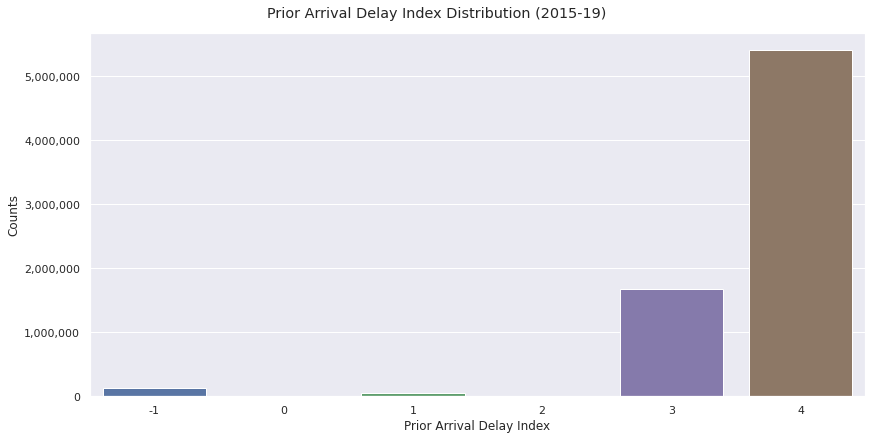

In [0]:
"""Plot PRIOR_ARR_DEL_INDEX distribution.
"""
prior_df = spark.read.option("header", "true").parquet(f'{ROOT_TEAM30_URL}/prior_del_test.parquet').cache()

pddf = prior_df.select('PRIOR_ARR_DEL_INDEX').toPandas()
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle('Prior Arrival Delay Index Distribution (2015-19)')
sns.countplot(x='PRIOR_ARR_DEL_INDEX', data=pddf, ax=ax)
ax.set_xlabel("Prior Arrival Delay Index")
ax.set_ylabel("Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 

print('''
Index Dictionary:
0 if on-time 
1 if late prior arrival
2 if early prior arrival & time length >= 15 minutes
3 if ground time >= 4 hours
4 if ground time <= 2 hours & flight has not arrived (so we don't know if there is a late arrival)
-1 if delay info is not avaliable for all other reasons such as a cancelled flight''')
plt.show()
pass

#### Real Pilot Inputs: Visibility, Ice Point, and Fog Risk

We spoke to a pilot to understand the weather parameters that actually affect takeoff. We gathered that a visibility of 400m or greater is considered good. We also found out that the risk of fog occurs as the air temperature nears the dew point temperature. Also, de-icing of the plane during cold conditions results in significant takeoff delays.

With this information, we created new features where:

 - `ORIGIN_ICE_POINT` and `DEST_ICE_POINT` where the temperature is below 5 degrees celsius.
 - `ORIGIN_POOR_VIS` and `DEST_POOR_VIS` where the visibility is les than 400m.
 - `ORIGIN_UNKNOWN_VIS` and `DEST_UNKNOWN_VIS` where the visibility distance value is 999999.
 - `ORIGIN_FOG_RISK` and `DEST_FOG_RISK` which shows the difference between the air and dew temperature.

In [0]:
def add_weather_features(df: pyspark.sql.dataframe.DataFrame) -> pyspark.sql.dataframe.DataFrame:
    """Function to add ice point and poor/fog visibility features to the master dataset.
    - ORIGIN_ICE_POINT
    - ORIGIN_POOR_VIS
    - ORIGIN_FOG_RISK
    - ORIGIN_UNKNOWN_VIS
    - DEST_POOR_VIS
    - DEST_ICE_POINT
    - DEST_FOG_RISK
    - DEST_UNKNOWN_VIS
    """
    # origin
    df = df.withColumn('ORIGIN_ICE_POINT', f.when(df.ORIGIN_W_TMP_DIM < 50, 1).otherwise(0)) \
           .withColumn('ORIGIN_POOR_VIS', f.when(df.ORIGIN_W_VIS_DIM < 4001, 1).otherwise(0)) \
           .withColumn('ORIGIN_FOG_RISK', df.ORIGIN_W_TMP_DIM - df.ORIGIN_W_DEW_DIM) \
           .withColumn('ORIGIN_UNKNOWN_VIS', f.when(df.ORIGIN_W_VIS_DIM == 999999, 1).otherwise(0))
    
    # dest
    df = df.withColumn('DEST_POOR_VIS', f.when(df.DEST_W_VIS_DIM < 4001, 1).otherwise(0)) \
           .withColumn('DEST_ICE_POINT', f.when(df.DEST_W_TMP_DIM < 50, 1).otherwise(0)) \
           .withColumn('DEST_FOG_RISK', df.DEST_W_TMP_DIM - df.DEST_W_DEW_DIM) \
           .withColumn('DEST_UNKNOWN_VIS', f.when(df.DEST_W_VIS_DIM == 999999, 1).otherwise(0))

    # casting for created features
    df = df.withColumn("ORIGIN_ICE_POINT", df.ORIGIN_ICE_POINT.cast('string')) \
           .withColumn("ORIGIN_POOR_VIS", df.ORIGIN_POOR_VIS.cast('string')) \
           .withColumn("ORIGIN_UNKNOWN_VIS", df.ORIGIN_UNKNOWN_VIS.cast('string')) \
           .withColumn("DEST_POOR_VIS", df.DEST_POOR_VIS.cast('string')) \
           .withColumn("DEST_ICE_POINT", df.DEST_ICE_POINT.cast('string')) \
           .withColumn("DEST_UNKNOWN_VIS", df.DEST_UNKNOWN_VIS.cast('string'))
            
    return df

From the 2 charts below, we can see that **ice point** and **poor visibility** occur only for a minority of the flights. Similarly, the *FOG RISK* for most flights is centered around 0, indicating that most flights have low fog risk. Hence, we do not expect these weather features to have stronger predictive power, compared to the earlier non-weather based features. For the *FOG RISK* chart, there are values clustered at the -10,000 and 10,000 regions, due to the impact of un-altered missing values (9999) within the temperature columns. We have made the decision not to alter the missing values at this point of the project, and will adjust for missing values subsequently during the model section.

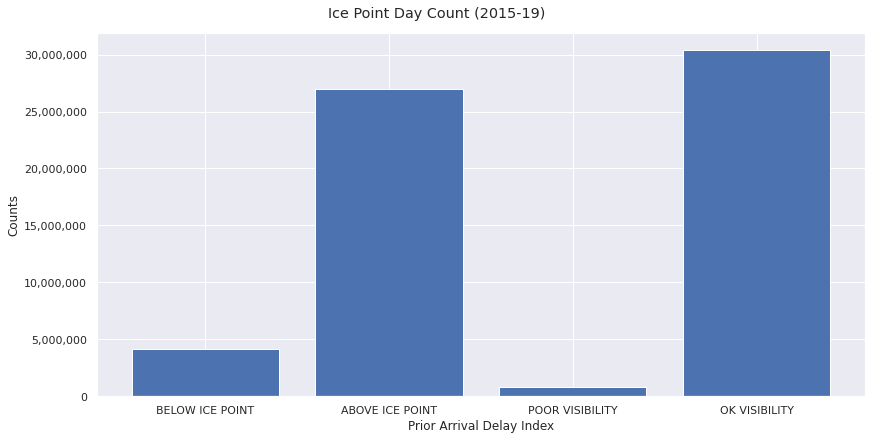

In [0]:
df = add_weather_features(master_steroid_df).cache()

# build stats
count_ice_1 = df.where(f.col('ORIGIN_ICE_POINT') == 1).count()
count_ice_0 = df.where(f.col('ORIGIN_ICE_POINT') == 0).count()
count_poor_vis_1 = df.where(f.col('ORIGIN_POOR_VIS') == 1).count()
count_poor_vis_0 = df.where(f.col('ORIGIN_POOR_VIS') == 0).count()

# plot visibility & ice point
pddf = pd.DataFrame(
            {'BELOW ICE POINT': [count_ice_1],
             'ABOVE ICE POINT': [count_ice_0],
             'POOR VISIBILITY': [count_poor_vis_1],
             'OK VISIBILITY': [count_poor_vis_0]})
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle('Ice Point Day Count (2015-19)')
ax.bar(pddf.columns, pddf.iloc[0,:])
ax.set_xlabel("Prior Arrival Delay Index")
ax.set_ylabel("Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 

plt.show()
pass

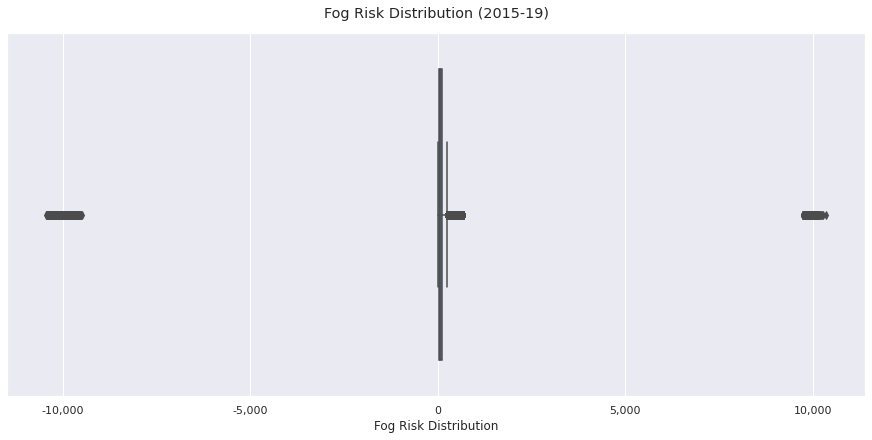

In [0]:
# plot fog risk
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle("Fog Risk Distribution (2015-19)")
sns.boxplot(df.select('ORIGIN_FOG_RISK').toPandas())
ax.set_xlabel("Fog Risk Distribution")
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=0)
pass

#### Lag Hourly Weather Delay Trend Distribution

According to our EDA and modeling experiments, weather is NOT the reason for the majority of delays. However, both data and our research show that when weather does become the reason for the delay (e.g. a snow storm), the effect can quickly propagate throughout the entire airport. It is also known that weather can change by minutes and while safety is the top priority, airports and airlines do want to resume operations as soon as possible.

In this section, we built a total of 6 features to measure the delay distribution due to weather:

- `DEP_WEATHER_DEL_ORG_SLOPE_1HR` measures the strength of the increasing/decreasing delays due to weather. It is given by "number of weather delays between 0 and -1 hour" divided by "# of weather delays between -1 and -2 hours" from the prediction time. ORG refers to the origin airport.
- `DEP_WEATHER_DEL_ORG_TREND_UP_1HR` indicates if the number of delays at the origin airport is currently trending up at the prediction time.
- `DEP_WEATHER_DEL_PROB_ORG_PRIOR_1HR` measures the total number of delays for the hour prior to prediction time at the origin airport. 
- `DEP_WEATHER_DEL_DEST_SLOPE_1HR` measures the strength of the increasing/decreasing delays due to weather. It is given by "number of weather delays between 0 and -1 hour" divided by "# of weather delays between -1 and -2 hours" from the prediction time. DEST refers to the destination airport.
- `DEP_WEATHER_DEL_DEST_TREND_UP_1HR` indicates if the number of delays at the destination airport is currently trending up at the prediction time.
- `DEP_WEATHER_DEL_PROB_DEST_PRIOR_1HR` measures the total number of delays for the hour prior to prediction time at destination airport.

In [0]:
# use 2019 January data just as a demo
MASTER_DF = master_full_df.where((f.col('YEAR')==2019) & (f.col('MONTH')==1) & (f.col('DAY_OF_MONTH')==1)).cache()
DEMO = False

def add_weather_delay_distribution(
                    master_df: pyspark.sql.dataframe.DataFrame, 
                    prior_hour_window: int = 1) -> pyspark.sql.dataframe.DataFrame:
    """
    DEP_WEATHER_DEL_ORG_SLOPE_{prior_hour_window}HR
    DEP_WEATHER_DEL_ORG_TREND_UP_{prior_hour_window}HR
    DEP_WEATHER_DEL_PROB_ORG_PRIOR_{prior_hour_window}HR
    DEP_WEATHER_DEL_DEST_SLOPE_{prior_hour_window}HR
    DEP_WEATHER_DEL_DEST_TREND_UP_{prior_hour_window}HR
    DEP_WEATHER_DEL_PROB_DEST_PRIOR_{prior_hour_window}HR
    """
    
    # build window ranges
    # the range endpoint is set to -1 to avoid leak; the flight itself will be included if set to 0
    win1_range = (-prior_hour_window*60*60, -1)
    win2_range = (-prior_hour_window*60*60*2, win1_range[0])
    
    # build windows
    # DEP_DELAY_NEW is adjusted to avoid leaks
    win1_org = Window.partitionBy('ORIGIN_AIRPORT_ID') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(win1_range[0], win1_range[1])
    win2_org = Window.partitionBy('ORIGIN_AIRPORT_ID') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(win2_range[0], win2_range[1])
    win1_dst = Window.partitionBy('DEST_AIRPORT_ID') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(win1_range[0], win1_range[1])
    win2_dst = Window.partitionBy('DEST_AIRPORT_ID') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(win2_range[0], win2_range[1])
    
    # build origin delay slope
    df = master_df.withColumn('WEATHER_DELAY_NEW', f.when(f.col('WEATHER_DELAY').isNull(), 0).otherwise(f.col('WEATHER_DELAY'))) \
                  .withColumn('PREDICTION_TIME_UNIX', (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*60*60)) \
                  .withColumn('W_DELAY', f.when(f.col('WEATHER_DELAY_NEW') > 0, 1).otherwise(0)) \
                  .withColumn('WIN1_FLIGHT_COUNT', f.count('ID').over(win1_org)) \
                  .withColumn('WIN1_FLIGHT_COUNT', f.when(f.col('WIN1_FLIGHT_COUNT') > 0, f.col('WIN1_FLIGHT_COUNT')).otherwise(1)) \
                  .withColumn('WIN1_W_DELAY_COUNT', f.sum(f.col('W_DELAY')).over(win1_org)) \
                  .withColumn('WIN1_DELAY', f.sum('WEATHER_DELAY_NEW').over(win1_org)) \
                  .withColumn('WIN1_DELAY', f.when(f.col('WIN1_DELAY').isNotNull(), f.col('WIN1_DELAY')).otherwise(0)) \
                  .withColumn('WIN2_DELAY', f.sum('WEATHER_DELAY_NEW').over(win2_org)) \
                  .withColumn('WIN2_DELAY', f.when(f.col('WIN2_DELAY') > 0, f.col('WIN2_DELAY')).otherwise(1)) \
                  .withColumn(f'DEP_WEATHER_DEL_ORG_SLOPE_{prior_hour_window}HR', f.col('WIN1_DELAY') / f.col('WIN2_DELAY')) \
                  .withColumn(f'DEP_WEATHER_DEL_ORG_TREND_UP_{prior_hour_window}HR', f.when(f.col(f'DEP_WEATHER_DEL_ORG_SLOPE_{prior_hour_window}HR') > 1, 1).otherwise(0)) \
                  .withColumn(f'DEP_WEATHER_DEL_PROB_ORG_PRIOR_{prior_hour_window}HR', f.col('WIN1_W_DELAY_COUNT') / f.col('WIN1_FLIGHT_COUNT')) \
                  .withColumn(f'DEP_WEATHER_DEL_PROB_ORG_PRIOR_{prior_hour_window}HR', 
                              f.when(f.col(f'DEP_WEATHER_DEL_PROB_ORG_PRIOR_{prior_hour_window}HR').isNotNull(), f.col(f'DEP_WEATHER_DEL_PROB_ORG_PRIOR_{prior_hour_window}HR')).otherwise(0)) \
                  .drop('WIN1_FLIGHT_COUNT',
                        'WIN1_W_DELAY_COUNT',
                        'WIN1_DELAY',
                        'WIN2_DELAY')
    
    # build origin delay slope
    df = df.withColumn('WIN1_FLIGHT_COUNT', f.count('ID').over(win1_dst)) \
           .withColumn('WIN1_FLIGHT_COUNT', f.when(f.col('WIN1_FLIGHT_COUNT') > 0, f.col('WIN1_FLIGHT_COUNT')).otherwise(1)) \
           .withColumn('WIN1_W_DELAY_COUNT', f.sum(f.col('W_DELAY')).over(win1_dst)) \
           .withColumn('WIN1_DELAY', f.count('WEATHER_DELAY_NEW').over(win1_dst)) \
           .withColumn('WIN1_DELAY', f.when(f.col('WIN1_DELAY').isNotNull(), f.col('WIN1_DELAY')).otherwise(0)) \
           .withColumn('WIN2_DELAY', f.sum('WEATHER_DELAY_NEW').over(win2_dst)) \
           .withColumn('WIN2_DELAY', f.when(f.col('WIN2_DELAY') > 0, f.col('WIN2_DELAY')).otherwise(1)) \
           .withColumn(f'DEP_WEATHER_DEL_DEST_SLOPE_{prior_hour_window}HR', f.col('WIN1_DELAY') / f.col('WIN2_DELAY')) \
           .withColumn(f'DEP_WEATHER_DEL_DEST_TREND_UP_{prior_hour_window}HR', f.when(f.col(f'DEP_WEATHER_DEL_DEST_SLOPE_{prior_hour_window}HR') > 1, 1).otherwise(0)) \
           .withColumn(f'DEP_WEATHER_DEL_PROB_DEST_PRIOR_{prior_hour_window}HR', f.col('WIN1_W_DELAY_COUNT') / f.col('WIN1_FLIGHT_COUNT')) \
           .withColumn(f'DEP_WEATHER_DEL_PROB_DEST_PRIOR_{prior_hour_window}HR', 
                              f.when(f.col(f'DEP_WEATHER_DEL_PROB_DEST_PRIOR_{prior_hour_window}HR').isNotNull(), f.col(f'DEP_WEATHER_DEL_PROB_DEST_PRIOR_{prior_hour_window}HR')).otherwise(0)) \
           .drop('W_DELAY',
                 'PREDICTION_TIME_UNIX', 
                 'WEATHER_DELAY_NEW',
                 'WIN1_FLIGHT_COUNT',
                 'WIN1_W_DELAY_COUNT',
                 'WIN1_DELAY',
                 'WIN2_DELAY')
    
    return df
  
if DEMO:
    display(add_weather_delay_distribution(MASTER_DF))

#### Lag Hourly Airport Stress Trend

Delay can propagate through space. A delay in an airport can affect the operation of other flights at the same airport. To account for the delay propagation through space, we build 4 features that measures the airport stress trends at the prediction time.

- `DEP_DEL_ORG_SLOPE_1HR` indicate is the slope of the delay count trend at the origin airport. It is calculated by “total delay minutes between 0 and -1 hour” divided by “total delay minutes between -1 and -2 hours” at the prediction time.
- `DEP_DEL_OEG_TREND_UP_1HR` indicates if the total delay minutes is trending up (1) or down (0) at the origin airport.
- `DEP_DEL_DEST_SLOPE_1HR` indicate is the slope of the delay count trend at the destination airport. It is calculated by “total delay minutes between 0 and -1 hour” divided by “total delay minutes between -1 and -2 hours” at the prediction time.
- `DEP_DEL_DEST_TREND_UP_1HR` indicates if the total delay minutes is trending up (1) or down (0) at the destination airport.

In [0]:
# use 2019 January data just as a demo
MASTER_DF = master_full_df.where((f.col('YEAR')==2019) & (f.col('MONTH')==1) & (f.col('DAY_OF_MONTH')==1)).cache()
DEMO = False

def add_delay_slope(master_df: pyspark.sql.dataframe.DataFrame, 
                    prior_hour_window: int = 1) -> pyspark.sql.dataframe.DataFrame:
    """Departure/arrival delay change by hours, and thetrend could be upward or downward. This function add
    features to indicate such trends in the input DF.
        - DEP_DEL_ORG_SLOPE_{prior_hour_window}HR
        - DEP_DEL_OEG_TREND_UP_{prior_hour_window}HR
        - DEP_DEL_DEST_SLOPE_{prior_hour_window}HR
        - DEP_DEL_DEST_TREND_UP_{prior_hour_window}HR
    """
    
    # build window ranges
    # the range endpoint is set to -1 to avoid leak; the flight itself will be included if set to 0
    win1_range = (-prior_hour_window*60*60, -1)
    win2_range = (-prior_hour_window*60*60*2, win1_range[0])
    
    # build windows
    # DEP_DELAY_NEW is adjusted to avoid leaks
    win1_org = Window.partitionBy('ORIGIN_AIRPORT_ID') \
                     .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                     .rangeBetween(win1_range[0], win1_range[1])
    win2_org = Window.partitionBy('ORIGIN_AIRPORT_ID') \
                     .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                     .rangeBetween(win2_range[0], win2_range[1])
    win1_dst = Window.partitionBy('DEST_AIRPORT_ID') \
                     .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                     .rangeBetween(win1_range[0], win1_range[1])
    win2_dst = Window.partitionBy('DEST_AIRPORT_ID') \
                     .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                     .rangeBetween(win2_range[0], win2_range[1])
    
    # build origin delay slope
    df = master_df.withColumn('DEP_DELAY_NEW_ADJUST', f.when(f.col('DEP_DELAY_NEW') >= 120, 120).otherwise(f.col('DEP_DELAY_NEW'))) \
                  .withColumn('PREDICTION_TIME_UNIX', (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*60*60)) \
                  .withColumn('WIN1_DELAY', f.sum('DEP_DELAY_NEW_ADJUST').over(win1_org)) \
                  .withColumn('WIN1_DELAY', f.when(f.col('WIN1_DELAY').isNotNull(), f.col('WIN1_DELAY')).otherwise(0)) \
                  .withColumn('WIN2_DELAY', f.sum('DEP_DELAY_NEW_ADJUST').over(win2_org)) \
                  .withColumn('WIN2_DELAY', f.when(f.col('WIN2_DELAY') > 0, f.col('WIN2_DELAY')).otherwise(1)) \
                  .withColumn(f'DEP_DEL_ORG_SLOPE_{prior_hour_window}HR', f.col('WIN1_DELAY') / f.col('WIN2_DELAY')) \
                  .withColumn(f'DEP_DEL_OEG_TREND_UP_{prior_hour_window}HR', f.when(f.col(f'DEP_DEL_ORG_SLOPE_{prior_hour_window}HR') > 1, 1).otherwise(0)) \
                  .drop('WIN1_DELAY'
                        'WIN1_DELAY'
                        'WIN2_DELAY'
                        'WIN2_DELAY')
    
    # build origin delay slope
    df = df.withColumn('WIN1_DELAY', f.sum('DEP_DELAY_NEW_ADJUST').over(win1_dst)) \
           .withColumn('WIN1_DELAY', f.when(f.col('WIN1_DELAY').isNotNull(), f.col('WIN1_DELAY')).otherwise(0)) \
           .withColumn('WIN2_DELAY', f.sum('DEP_DELAY_NEW_ADJUST').over(win2_dst)) \
           .withColumn('WIN2_DELAY', f.when(f.col('WIN2_DELAY') > 0, f.col('WIN2_DELAY')).otherwise(1)) \
           .withColumn(f'DEP_DEL_DEST_SLOPE_{prior_hour_window}HR', f.col('WIN1_DELAY') / f.col('WIN2_DELAY')) \
           .withColumn(f'DEP_DEL_DEST_TREND_UP_{prior_hour_window}HR', f.when(f.col(f'DEP_DEL_DEST_SLOPE_{prior_hour_window}HR') > 1, 1).otherwise(0)) \
           .drop('PREDICTION_TIME_UNIX', 
                 'DEP_DELAY_NEW_ADJUST',
                 'WIN1_DELAY'
                 'WIN2_DELAY')
    
    return df
  
if DEMO:
    display(add_delay_slope(MASTER_DF))

#### Lag Hourly Route Stress Distribution
A route is defined by an origin-destination pair. A total of 4 features are built to measure the stress per route.  
- `DEP_DEL15_PROB_ODPAIR_PRIOR2HR` measures the 15-minute departure delay probability for the origin-destination pair in the past 2 hours from the prediction time.
- `DEP_DEL_PROB_ODPAIR_PRIOR2HR` measures departure delay probability for the origin-destination pair in the past 2 hours from the prediction time.
- `DEP_DEL_MEAN_ODPAIR_PRIOR2HR` measures the mean of departure delay minutes for the origin-destination pair in the past 2 hours from the prediction time.
- `DEP_DEL_MEDIAN_ODPAIR_PRIOR2HR` measures the median of departure delay minutes for the origin-destination pair in the past 2 hours from the prediction time.

In [0]:
# use 2019 January data just as a demo
MASTER_DF = master_full_df.where((f.col('YEAR')==2019) & (f.col('MONTH')==1) & (f.col('DAY_OF_MONTH')==1)).cache()
DEMO = False

def add_od_pair_stress(master_df: pyspark.sql.dataframe.DataFrame, 
                       prior_hour_window: int = 2) -> pyspark.sql.dataframe.DataFrame:
    """Add the following drigin-destination pair prior delay info:
          - DEP_DEL15_PROB_ODPAIR_PRIOR{prior_hour_window}HR
          - DEP_DEL_PROB_ODPAIR_PRIOR{prior_hour_window}HR
          - DEP_DEL_MEAN_ODPAIR_PRIOR{prior_hour_window}HR
          - DEP_DEL_MEDIAN_ODPAIR_PRIOR{prior_hour_window}HR
    """
    magic_median = f.expr('percentile_approx(DEP_DELAY_NEW_ADJUST, 0.5)')
    # the range endpoint is set to -1 to avoid leak; the flight itself will be included if set to 0
    win = Window.partitionBy('ORG_DEST_PAIR') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(-prior_hour_window*60*60, -1) 
    
    # note: the mx delay minutes a flight can have within the window is limited to the "width" of the window
    max_delay_minute = prior_hour_window * 60
    df = master_df.withColumn('ORG_DEST_PAIR', f.concat(f.col('ORIGIN'), f.lit('-'), f.col('DEST'))) \
                  .withColumn('DEP_DEL_BINARY', f.when(f.col('DEP_DELAY_NEW') > 0, 1).otherwise(0)) \
                  .withColumn('DEP_DELAY_NEW_ADJUST', f.when(f.col('DEP_DELAY_NEW') >= max_delay_minute, max_delay_minute).otherwise(f.col('DEP_DELAY_NEW'))) \
                  .withColumn('PREDICTION_TIME_UNIX', (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*60*60)) \
                  .withColumn('FLIGHT_COUNT', f.count('ID').over(win)) \
                  .withColumn('FLIGHT_COUNT', f.when(f.col('FLIGHT_COUNT') > 0, f.col('FLIGHT_COUNT')).otherwise(1)) # remove null vlaues & prevent zero division
    
    # build new features
    df = df.withColumn(f'DEP_DEL15_PROB_ODPAIR_PRIOR{prior_hour_window}HR', f.sum('DEP_DEL15').over(win) / f.col('FLIGHT_COUNT')) \
           .withColumn(f'DEP_DEL_PROB_ODPAIR_PRIOR{prior_hour_window}HR', f.sum('DEP_DEL_BINARY').over(win) / f.col('FLIGHT_COUNT')) \
           .withColumn(f'DEP_DEL_MEAN_ODPAIR_PRIOR{prior_hour_window}HR', f.sum('DEP_DELAY_NEW_ADJUST').over(win) / f.col('FLIGHT_COUNT')) \
           .withColumn(f'DEP_DEL_MEDIAN_ODPAIR_PRIOR{prior_hour_window}HR', magic_median.over(win)) \
           .drop('ORG_DEST_PAIR', 'DEP_DEL_BINARY', 'PREDICTION_TIME_UNIX', 'DEP_DELAY_NEW_ADJUST', 'FLIGHT_COUNT')
    
    # fill null
    df = df.fillna({f'DEP_DEL15_PROB_ODPAIR_PRIOR{prior_hour_window}HR': 0,
                    f'DEP_DEL_PROB_ODPAIR_PRIOR{prior_hour_window}HR': 0,
                    f'DEP_DEL_MEAN_ODPAIR_PRIOR{prior_hour_window}HR': 0,
                    f'DEP_DEL_MEDIAN_ODPAIR_PRIOR{prior_hour_window}HR': 0})
    
    return df

if DEMO:
    display(add_od_pair_stress(MASTER_DF))

#### Lag Airport Stress Distribution

Lag hourly airport stress distribution features are similar to the features for hourly route stress distribution. The only difference is that now the distribution is calculated per airport instead of per origin-destination pair route. A total of 16 features are built in this section. 8 of which lag by 2 hours and the other 8 lag by 24 hours. Each lag group can further be separated into 4 departure airport features, and 4 arrival airport features.

2 Hours Lag Features:
- `AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL15_PROB` measures the 15-minute delay probability over the past 2 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB` measures the delay minutes over the past 2 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_MEAN` measures the average delay minutes over the past 2 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_MEDIAN` measures the median delay minutes over the past 2 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL15_PROB` measures the 15-minute delay probability over the past 2 hours from the prediction time at the destination airport.
- `AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB` measures the delay minutes over the past 2 hours from the prediction time at the destination airport.
- `AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_MEAN` measures the average delay minutes over the past 2 hours from the prediction time at the destination airport.
- `AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_MEDIAN` measures the median delay minutes over the past 2 hours from the prediction time at the destination airport.

24 Hours Lag Features:
- `AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB` measures the 15-minute delay probability over the past 24 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_PROB` measures the delay minutes over the past 24 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_MEAN` measures the average delay minutes over the past 24 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_MEDIAN` measures the median delay minutes over the past 24 hours from the prediction time at the origin airport.
- `AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL15_PROB` measures the 15-minute delay probability over the past 24 hours from the prediction time at the destination airport.
- `AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_PROB` measures the delay minutes over the past 24 hours from the prediction time at the destination airport.
- `AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_MEAN` measures the average delay minutes over the past 24 hours from the prediction time at the destination airport.
- `AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_MEDIAN` measures the median delay minutes over the past 24 hours from the prediction time at the destination airport.

In [0]:
# use 2019 January data just as a demo
MASTER_DF = master_full_df.where((f.col('YEAR')==2019) & (f.col('MONTH')==1) & (f.col('DAY_OF_MONTH')==1)).cache()
DEMO = False

def add_airport_stress(master_df: pyspark.sql.dataframe.DataFrame, 
                       prior_hour_window: int = 2) -> pyspark.sql.dataframe.DataFrame:
    """Add the following airport stress indicators to the input DF:
        - AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB
        - AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_PROB
        - AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN
        - AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN
        - AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB
        - AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_PROB
        - AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN
        - AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN
    """
    magic_median = f.expr('percentile_approx(DEP_DELAY_NEW_ADJUST, 0.5)')
    
    # add origin airport stress
    # the range endpoint is set to -1 to avoid leak; the flight itself will be included if set to 0
    win = Window.partitionBy('ORIGIN_AIRPORT_ID') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(-prior_hour_window*60*60, -1)
    max_delay_minute = prior_hour_window * 60
    df = master_df.withColumn('DEP_DEL_BINARY', f.when(f.col('DEP_DELAY_NEW') > 0, 1).otherwise(0)) \
                  .withColumn('PREDICTION_TIME_UNIX', (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*60*60)) \
                  .withColumn('DEP_DELAY_NEW_ADJUST', f.when(f.col('DEP_DELAY_NEW') >= max_delay_minute, max_delay_minute).otherwise(f.col('DEP_DELAY_NEW'))) \
                  .withColumn('FLIGHT_COUNT', f.count('ID').over(win)) \
                  .withColumn('FLIGHT_COUNT', f.when(f.col('FLIGHT_COUNT') > 0, f.col('FLIGHT_COUNT')).otherwise(1)) \
                  .withColumn(f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB', f.sum('DEP_DEL15').over(win) / f.col('FLIGHT_COUNT')) \
                  .withColumn(f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_PROB', f.sum('DEP_DEL_BINARY').over(win) / f.col('FLIGHT_COUNT')) \
                  .withColumn(f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN', f.sum('DEP_DELAY_NEW_ADJUST').over(win) / f.col('FLIGHT_COUNT')) \
                  .withColumn(f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN', magic_median.over(win)) \
                  .drop('DEP_DEL_BINARY', 'PREDICTION_TIME_UNIX', 'DEP_DELAY_NEW_ADJUST', 'FLIGHT_COUNT')
    
    # add dest airport stress
    # the range endpoint is set to -1 to avoid leak; the flight itself will be included if set to 0
    win = Window.partitionBy('DEST_AIRPORT_ID') \
                .orderBy(f.col('PREDICTION_TIME_UNIX').asc()) \
                .rangeBetween(-prior_hour_window*60*60, -1)
    max_delay_minute = prior_hour_window * 60
    df = df.withColumn('DEP_DEL_BINARY', f.when(f.col('DEP_DELAY_NEW') > 0, 1).otherwise(0)) \
           .withColumn('PREDICTION_TIME_UNIX', (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*60*60)) \
           .withColumn('DEP_DELAY_NEW_ADJUST', f.when(f.col('DEP_DELAY_NEW') >= max_delay_minute, max_delay_minute).otherwise(f.col('DEP_DELAY_NEW'))) \
           .withColumn('FLIGHT_COUNT', f.count('ID').over(win)) \
           .withColumn('FLIGHT_COUNT', f.when(f.col('FLIGHT_COUNT') > 0, f.col('FLIGHT_COUNT')).otherwise(1)) \
           .withColumn(f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB', f.sum('DEP_DEL15').over(win) / f.col('FLIGHT_COUNT')) \
           .withColumn(f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_PROB', f.sum('DEP_DEL_BINARY').over(win) / f.col('FLIGHT_COUNT')) \
           .withColumn(f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN', f.sum('DEP_DELAY_NEW_ADJUST').over(win) / f.col('FLIGHT_COUNT')) \
           .withColumn(f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN', magic_median.over(win)) \
           .drop('DEP_DEL_BINARY', 'PREDICTION_TIME_UNIX', 'DEP_DELAY_NEW_ADJUST', 'FLIGHT_COUNT')
    
    # fill null
    df = df.fillna({f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB': 0,
                    f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_PROB': 0,
                    f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN': 0,
                    f'AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN': 0,
                    f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB': 0,
                    f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_PROB': 0,
                    f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN': 0,
                    f'AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN': 0})
    
    return df

if DEMO:
    display(add_airport_stress(MASTER_DF))

#### Other Features
Three features are built in this section:
- `OUT_OF_STATE` indicates if a flight flies across states.
- `CRS_DEP_HOUR` transforms the CRS departure time to the full hour. 
- `CRS_ARR_HOUR` transforms the CRS arrival time to the full hour. 

The following two variables are **NOT** features but labels to indicate if a flight belons to group 12 delays (i.e. delays longer than 3 hours).
- `ARR_DELAY15_12` indicates if a flight has a group-12 delay (delay longer than 3 hours)
- `DEP_DELAY15_1_TO_11` indicates if a flight has a group-11 to 12 delay (delay between 15 minutes and 3 hours)

In [0]:
def add_out_of_state(df: pyspark.sql.dataframe.DataFrame) -> pyspark.sql.dataframe.DataFrame:                                                              
    """Add feature to indicate if a flight is flying across states: OUT_OF_STATE.
    """
    df = df.withColumn('OUT_OF_STATE', f.when(f.col("ORIGIN_STATE_ABR") == f.col("DEST_STATE_ABR"), 0).otherwise(1))
    return df
      
def add_CRS_HOUR(df: pyspark.sql.dataframe.DataFrame) -> pyspark.sql.dataframe.DataFrame:
    """Add features to indicate which hour is arrival and departure:
    - CRS_DEP_HOUR
    - CRS_ARR_HOUR
    """
    # convert CRS timings to hourly values
    df = df.withColumn('CRS_DEP_HOUR', (df.CRS_DEP_TIME * (10 ** (-2)))/((10 ** (-2))*100)) \
           .withColumn('CRS_ARR_HOUR', (df.CRS_ARR_TIME * (10 ** (-2)))/((10 ** (-2))*100))
    
    # casting for created features
    df = df.withColumn("CRS_DEP_HOUR", df["CRS_DEP_HOUR"].cast("int")) \
           .withColumn("CRS_ARR_HOUR", df["CRS_ARR_HOUR"].cast("int"))
    
    return df
  
def build_delay_labels(df: pyspark.sql.dataframe.DataFrame) -> pyspark.sql.dataframe.DataFrame:
    """Add two new columns to the DF: DELAY_GROUP_12 & DELAY_GROUP_1_TO_11
    """
    
    # construct new label to separate delay group 12
    df = df.withColumn('DEP_DELAY15_12', f.when(f.col('DEP_DELAY_GROUP') == 12, 1).otherwise(0)) \
           .withColumn('DEP_DELAY15_1_TO_11', f.when((f.col('DEP_DELAY_GROUP') >= 1) & (f.col('DEP_DELAY_GROUP') <= 11), 1).otherwise(0))
    
    df = df.withColumn('ARR_DELAY15_12', f.when(f.col('ARR_DELAY_GROUP') == 12, 1).otherwise(0)) \
           .withColumn('ARR_DELAY15_1_TO_11', f.when((f.col('ARR_DELAY_GROUP') >= 1) & (f.col('ARR_DELAY_GROUP') <= 11), 1).otherwise(0))
    
    return df

### Joining New Features

We have a total of 41 features built and joined to the raw dataset. Custom features are added to the overall master dataframe using one of the two methods: 
- Some features such as “prior departure delay distribution” are pre-built and saved as a separate parquet file. These features are joined by record ID and `CRS_DEP_TIME_UTC`.
- Most features, however, are relatively lightweight and queries can be executed in real-time during the join. The queries for these features are wrapped in their own functions and called in this section.

Overall, the full custom feature join process takes between 20 to 30 minutes. Note that the base master dataset (i.e. the dataset with the Airlines and Weather datasets joined) is pre-built so no new features can be added incrementally as they are created without having to rebuild the joined dataset from the ground up.

In [0]:
MASTER_PARQUET_SUFFIX = 'yc'

# prior features
# PRIOR_DISTANCE_GROUP
# PRIOR_DISTANCE
# PRIOR_ARR_DEL_INDEX
# PRIOR_ARR_DEL15
# PRIOR_ARR_DEL_MINUTE
# PRIOR_DEP_DEL_MINUTE
# PRIOR_DEP_DEL15
prior_df = spark.read.option("header", "true").parquet(f'{ROOT_TEAM30_URL}/prior_del_full.parquet').cache()
prior_df = prior_df.select('ID', 'CRS_DEP_TIME_UTC', 
                           'CRS_GROUND_TIME_HOUR', 'PRIOR_DISTANCE', 'PRIOR_DISTANCE_GROUP',
                           'PRIOR_ARR_DEL_INDEX', 'PRIOR_ARR_DEL15', 'PRIOR_ARR_DEL_MINUTE', 
                           'PRIOR_DEP_DEL_MINUTE', 'PRIOR_DEP_DEL15')
master_steroid_df = master_full_df.join(prior_df, on=['ID', 'CRS_DEP_TIME_UTC'], how='left')

# build visibility, ice point, and fog risk according to interview with the real pilot
# ORIGIN_ICE_POINT
# ORIGIN_POOR_VIS
# ORIGIN_FOG_RISK
# ORIGIN_UNKNOWN_VIS
# DEST_POOR_VIS
# DEST_ICE_POINT
# DEST_FOG_RISK
# DEST_UNKNOWN_VIS
master_steroid_df = add_weather_features(master_steroid_df)

# DEP_WEATHER_DEL_ORG_SLOPE_{prior_hour_window}HR
# DEP_WEATHER_DEL_ORG_TREND_UP_{prior_hour_window}HR
# DEP_WEATHER_DEL_PROB_ORG_PRIOR_{prior_hour_window}HR
# DEP_WEATHER_DEL_DEST_SLOPE_{prior_hour_window}HR
# DEP_WEATHER_DEL_DEST_TREND_UP_{prior_hour_window}HR
# DEP_WEATHER_DEL_PROB_DEST_PRIOR_{prior_hour_window}HR
master_steroid_df = add_weather_delay_distribution(master_steroid_df, prior_hour_window=1)

# feature to indicate if a flight is crossing states
# OUT_OF_STATE
master_steroid_df = add_out_of_state(master_steroid_df)

# feature to indicate the hour of the departure and arrival
# CRS_DEP_HOUR
# CRS_ARR_HOUR
master_steroid_df = add_CRS_HOUR(master_steroid_df)

# add route stress distribution
# DEP_DEL15_PROB_ODPAIR_PRIOR{prior_hour_window}HR
# DEP_DEL_PROB_ODPAIR_PRIOR{prior_hour_window}HR
# DEP_DEL_MEAN_ODPAIR_PRIOR{prior_hour_window}HR
master_steroid_df = add_od_pair_stress(master_steroid_df, prior_hour_window=2)

# add airport stress distribution
# AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB
# AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_PROB
# AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN
# AIRPORT_STRESS_ORG_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN
# AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL15_PROB
# AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_PROB
# AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEAN
# AIRPORT_STRESS_DEST_PRIOR{prior_hour_window}HR_DEP_DEL_MEDIAN
master_steroid_df = add_airport_stress(master_steroid_df, prior_hour_window=2)
master_steroid_df = add_airport_stress(master_steroid_df, prior_hour_window=24)

# add airport stress trends
# DEP_DEL_ORG_SLOPE_{prior_hour_window}HR
# DEP_DEL_OEG_TREND_UP_{prior_hour_window}HR
# DEP_DEL_DEST_SLOPE_{prior_hour_window}HR
# DEP_DEL_DEST_TREND_UP_{prior_hour_window}HR
master_steroid_df = add_delay_slope(master_steroid_df, prior_hour_window=1)

# build new labels to indicate if a flight is GROUP_12
master_steroid_df = build_delay_labels(master_steroid_df)

# write to parquet
master_steroid_df.write.parquet(f'{ROOT_TEAM30_DBFS}/master_steroid_{MASTER_PARQUET_SUFFIX}.parquet', mode='overwrite')

## Data Splits
Our data split strategy is illustrated by the diagram below. Preventing data leaks (i.e. using future data to predict past flights) is key to building a model that works for the real production environment, and we employ the following steps to ensure a leakage free split. 
- First, we reserve 2019 as the test dataset.
- For baseline modeling and hyperparameter fine-tuning, we use 2018 as validation and 2017 as training. 
- We do not have any aggregated features irrespective of the current prediction time (e.g. no features such as an airport's monthly delay distribution), so we no longer have to reserve 2016 for aggregation as proposed previously.   
- For the final model, instead of using a validation set, we will use all 4 years (2015-2018) as the training set, and 2019 as the test set. This is because we believe the process of fine-tuning on our baseline model which already uses a significant amount of data for training and validation, has provided us an optimal balance between performance and efficiency, which we can apply to the final model.


![Data Split](https://www.dropbox.com/s/2j6sfe4ycuccuje/split.png?raw=1)

In [0]:
"""Define config constants required for the split.
"""
SPLIT_PARQUET_SUFIX = 'yyc'
MASTER_PARQUET_SUFFIX = 'yc'
MASTER_DF = spark.read.option("header", "true").parquet(f'{ROOT_TEAM30_URL}/master_steroid_{MASTER_PARQUET_SUFFIX}.parquet').cache()

LABEL = ['DEP_DEL15']
CAT_FEATURES_ALL_RELEVANT = [
          'MONTH', 
          'DAY_OF_MONTH', 
          'DAY_OF_WEEK', 
          'OP_CARRIER_AIRLINE_ID', 
          'TAIL_NUM', 
          'OP_CARRIER_FL_NUM', 
          'ORIGIN_AIRPORT_ID', 
          'ORIGIN',
          'ORIGIN_STATE_ABR',
          'DEST_AIRPORT_ID', 
          'DEST',
          'DEST_STATE_ABR',
          'DEP_TIME_BLK',
          'ARR_TIME_BLK',
          'CRS_DEP_HOUR',
          'CRS_ARR_HOUR',
          'DISTANCE_GROUP',

          # weather stress
          'ORIGIN_W_WND_TYPE',
          'DEST_W_WND_TYPE',
          'ORIGIN_ICE_POINT',
          'ORIGIN_POOR_VIS',
          'DEST_POOR_VIS',
          'DEST_ICE_POINT',
          'ORIGIN_UNKNOWN_VIS',
          'DEST_UNKNOWN_VIS',  
  
          # prior flight stress
          'PRIOR_ARR_DEL_INDEX',
          'PRIOR_ARR_DEL15',
          'PRIOR_DEP_DEL15', 
          'PRIOR_DISTANCE_GROUP',
          
          # airport stress trend
          'DEP_DEL_OEG_TREND_UP_1HR',
          'DEP_DEL_DEST_TREND_UP_1HR',

          # current flight stress
          'OUT_OF_STATE',
]

NUM_FEATURES_ALL_RELEVANT = [
        'DISTANCE',
        'TAXI_IN',
        'CRS_ELAPSED_TIME',
        
        # weather
        'ORIGIN_W_WND_SPD', 
        'ORIGIN_W_CIG_DIM', 
        'ORIGIN_W_VIS_DIM', 
        'ORIGIN_W_TMP_DIM', 
        'ORIGIN_W_DEW_DIM', 
        'ORIGIN_W_SLP_DIM',
        'DEST_W_WND_SPD', 
        'DEST_W_CIG_DIM', 
        'DEST_W_VIS_DIM', 
        'DEST_W_TMP_DIM', 
        'DEST_W_DEW_DIM', 
        'DEST_W_SLP_DIM',
  
        # weather stress features by pilot interview
        'ORIGIN_FOG_RISK',
        'DEST_FOG_RISK',

        # prior flight stress
        'CRS_GROUND_TIME_HOUR', 
        'PRIOR_DEP_DEL_MINUTE',
        'PRIOR_ARR_DEL_MINUTE',
        'PRIOR_DISTANCE',
        
        # origin-dest pair stress
        'DEP_DEL15_PROB_ODPAIR_PRIOR2HR',
        'DEP_DEL_PROB_ODPAIR_PRIOR2HR',
        'DEP_DEL_MEAN_ODPAIR_PRIOR2HR',
        'DEP_DEL_MEDIAN_ODPAIR_PRIOR2HR',
        
        # airport stress
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_MEAN',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_MEDIAN',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_MEAN',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_MEDIAN',
  
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_MEAN',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_MEDIAN',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_MEAN',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_MEDIAN',  

        # weather delay distribution
        'DEP_WEATHER_DEL_ORG_SLOPE_1HR',
        'DEP_WEATHER_DEL_ORG_TREND_UP_1HR',
        'DEP_WEATHER_DEL_PROB_ORG_PRIOR_1HR',
        'DEP_WEATHER_DEL_DEST_SLOPE_1HR',
        'DEP_WEATHER_DEL_DEST_TREND_UP_1HR',
        'DEP_WEATHER_DEL_PROB_DEST_PRIOR_1HR',
  
        # airport stress trend
        'DEP_DEL_ORG_SLOPE_1HR',
        'DEP_DEL_DEST_SLOPE_1HR'
]

In [0]:
"""Split data.
"""
def split_data(df              : pyspark.sql.dataframe.DataFrame, 
               features        : tuple = (CAT_FEATURES_ALL_RELEVANT, NUM_FEATURES_ALL_RELEVANT, LABEL), 
               test_years      : list = [2019],
               train_years     : list = [2017],
               valid_years     : list = [2018],
               months          : list = list(range(1,13)),
               parquet_suffix  : str = 'team30',
               save_parquet    : bool = True,
               rm_weather_null : bool = True,
               rm_cancel       : bool = True,
               rm_g12_delay    : bool = False,
               build_test      : bool = True) -> dict:
    """Split the Master dataset to train/valid/test dataset.
    Returns:
      (dict) dict['train'], dict['valid'], dict['test']
    """
    # filter features
    if rm_cancel:
        df = df.where(f.col('CANCELLED') == 0)
    if rm_g12_delay:
        df = df.where(f.col('DEP_DELAY_GROUP') != 12)
    if rm_weather_null:
        df = df.where(f.col('ORIGIN_W_WND_DIR').isNotNull()) \
               .where(f.col('DEST_W_WND_DIR').isNotNull())
    df = df.where(f.col('MONTH').isin(months))
    
    # convert data types
    for c in features[0]:
        df = df.withColumn(c, f.col(c).cast('string')) # cat features
    for c in features[1]:
        df = df.withColumn(c, f.col(c).cast('float')) # num features
    for c in features[2]:
        df = df.withColumn(c, f.col(c).cast('int')) # label
    
    # build datasets
    data = {}
    data['train'] = df.where(f.col('YEAR').isin(train_years))
    data['valid'] = df.where(f.col('YEAR').isin(valid_years))
    if build_test:
        data['test'] = df.where(f.col('YEAR').isin(test_years))
    else:
        data['test'] = None
    
    # cache
    data['train'] = data['train'].cache()
    data['valid'] = data['valid'].cache()
    data['test'] = data['test'].cache()
    
    # save parquets
    if save_parquet:
        data['train'].write.parquet(f'{ROOT_TEAM30_URL}/train/train_{parquet_suffix}.parquet', mode='overwrite')
        data['valid'].write.parquet(f'{ROOT_TEAM30_URL}/train/valid_{parquet_suffix}.parquet', mode='overwrite')
        data['test'].write.parquet(f'{ROOT_TEAM30_URL}/train/test_{parquet_suffix}.parquet', mode='overwrite')
    else:
        data['train'].count()
        data['valid'].count()
        data['test'].count()
    
    return data

In [0]:
# Caution: Update parquet_suffix to avoid overwriting your teamates' parquets!!!
data = split_data(df=MASTER_DF, 
                  features=(CAT_FEATURES_ALL_RELEVANT, NUM_FEATURES_ALL_RELEVANT, LABEL), 
                  train_years=[2015, 2016, 2017, 2018],
                  valid_years=[2015, 2016, 2017, 2018],
                  test_years=[2019],
                  parquet_suffix=SPLIT_PARQUET_SUFIX)

## Feature Selection

The two raw datasets, airlines and weather, come with a total of 325 features. The final joined dataset, after cleaning/removing irrelevant columns and adding the 41 custom-built features, has a total of **81** features. To identify the features best for modeling both in terms of the performance and efficiency, we employ 3-step feature selection funnel: 
1. Identifying feature relevance, based on description within the respective data dictionaries
2. Extracting features with predictive power, based on the *Information Value* derived from a **Weight of Evidence** analysis
3. Identifying correlated features with a correlation heatmap

Note that the feature selection funnel is a part of an iterative process that include new feature brainstorming/building, feature selection, and performance evaluation. We have gone through a number of iterations before finalizing the list of the features used for training the final model.
  
Note that feature selection including WOE and correlation heatmap analysis takes place AFTER the data split and ONLY on our training dataset.

![Features Selection](https://www.dropbox.com/s/e692fjfb41lirnh/feature_selection.png?raw=1)

### Feature Relevance

The very first step for feature selection is to identify relevance based on information provided in data dictionaries. We utilize the following data dictionaries for each primary dataset, to understand the information conveyed by each feature.

- Data dictionary for the **Airline dataset** from the Bureau of Transportation Statistics
  - Source: Marketing Carrier On-Time Performance, [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGK](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGK)
- Data dictionary for the **Weather dataset** from the National Oceanic and Atmospheric Administration 
  - Source: Federal Climate Complex Data Documentation for Integrated Surface Data, [https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)
  
Based on the target outcome of identifying delays 2 hours before the scheduled flight time, we first remove features which do not logically offer information that would help in delay prediction. These features include *Gate Return Information at Origin Airport* and *Diverted Airport Information*. We then removed features which offer similar information. For example, to identify airports, we kept *OriginAirportID* and dropped similar-level features such as *OriginAirportSeqID* and *OriginCityMarketID*. Lastly, we reduced the features used from the weather set by selecting only the most relevant feature describing each given weather element. For example, for *WIND-OBSERVATION*, we kept *speed rate* and dropped *direction angle*, *direction quality code* and *speed quality code*. We also use this opportunity to label our features according as `LABEL`, `CAT_FEATURES` and `NUM_FEATURES`. With this process, we get a total of *77* features.

Note that the feature relvance selection is done prior to data split in order to save storage, so here we simply copy the feature set over from the data split stage.

In [0]:
cols = NUM_FEATURES_ALL_RELEVANT + CAT_FEATURES_ALL_RELEVANT + LABEL
train_set = train_set.select(*cols)

### Weight of Evidence Analysis

The weight of evidence measures the predictive power of a feature with respect to the outcome variable. It allows us to screen through our features, and derive the respective Information Values which indicates how good a specific feature is with respect to determining the outcome.

The weight of evidence is given by the formula:
$$ WOE = \ln \frac{percentage\ of\ non events}{percentage\ of\ events} $$

Information value is given by the formula:
$$ Information\ Value\ = \sum (percentage\ of\ non events -\ percentage\ of\ events)\ \cdot WOE $$

In this case, events and non-events refer to `DEP_DEL15`.

We use WOE to identify the features with predictive power, by looking at the Information Value (IV). For features with high IV, we return to cross check the feature to ensure that there were no leaks during the feature engineering process. We also use the WOE to reduce the size of our feature space.  We will also remove features providing similar information (eg, `ORIGIN_STATE_ABR`, `DEP_TIME_BLK`). Based on our findings, we keep 39 features, shrinking our feature space to under half of the original size.

We can see that most of our remaining features were engineered, with original baseline features making up a minority. We also see that time-based features offer the most value, in contrast to weather and location based features.

In [0]:
"""Functions for retrieving the Weight of Evidence and Information value by feature
code referenced from: https://github.com/klaudia-nazarko/iv-and-woe-python
"""

from pandas.api.types import is_numeric_dtype
import scipy.stats as stats

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'label']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'label']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'label': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['label'])

            if (
                    abs(r)==1 and                                                        # check if woe for bins are monotonic
                    df_grouped[self.feature].min() > self.bin_min_size                   # check if bin size is greater than 5%
                    and not (df_grouped[self.feature] == df_grouped['label']).any()      # check if number of good and bad is not equal to 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'label']]
      
pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(20, 10))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('Feature Information Values (1 year training set)')
        plt.xticks(rotation=90)
        plt.show()


class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'label': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()


/databricks/python/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
 result = getattr(ufunc, method)(*inputs, **kwargs)

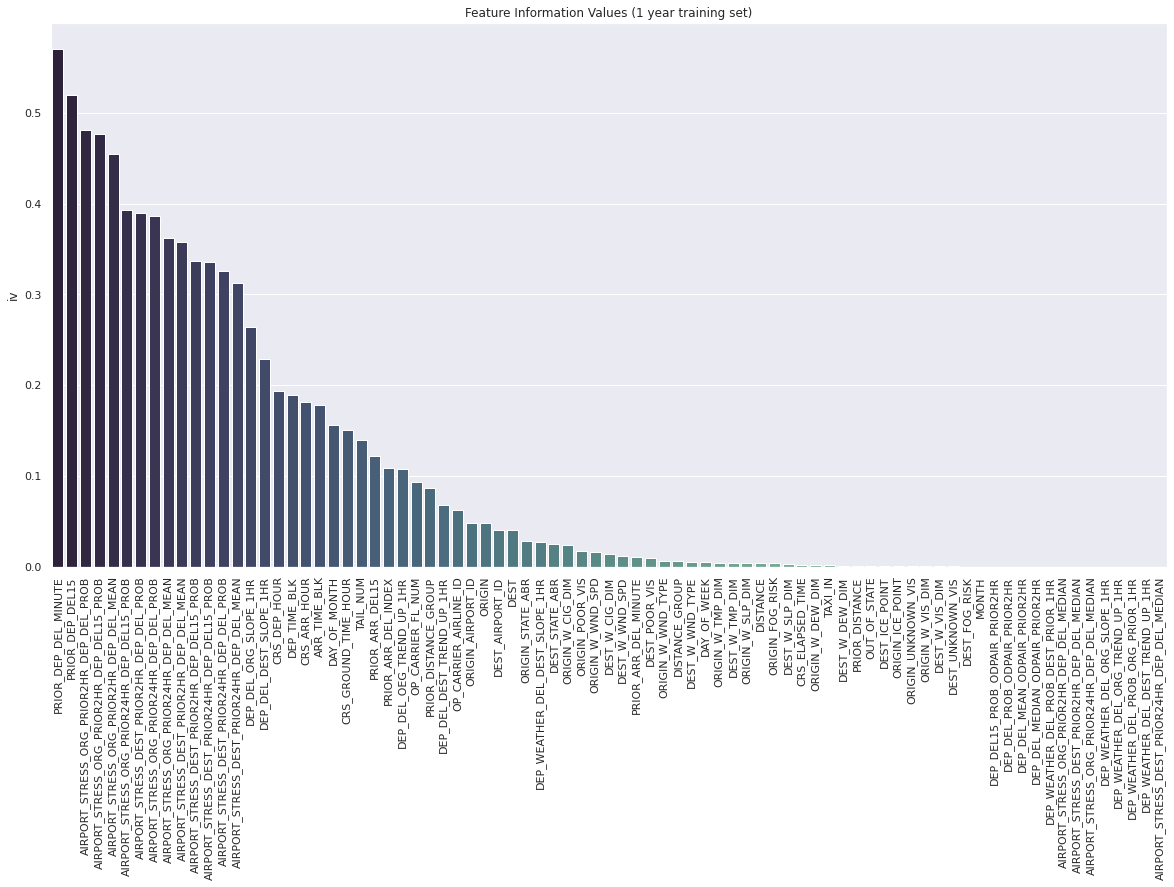

In [0]:
df = train_set.toPandas()
df = df.rename({'DEP_DEL15': 'label'}, axis=1)

# classifying types of features
feats_dict = {}

for col in [c for c in df.columns if c != 'label']:
    if is_numeric_dtype(df[col]):
        feats_dict[col] = ContinuousFeature(df, col)
    else:
        feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

# getting the Information Value
iv = IV()
ar = AttributeRelevance()
ar.draw_iv(feats, iv)

In [0]:
""" Trim features after using WOE+IV (39 features left)
"""
LABEL = ['DEP_DEL15']

CAT_FEATURES_SELECT_BY_WOE = [
          'MONTH', 
          'DAY_OF_MONTH', 
          'DAY_OF_WEEK', 
          'OP_CARRIER_AIRLINE_ID', 
          'TAIL_NUM', 
          'OP_CARRIER_FL_NUM', 
          'ORIGIN_AIRPORT_ID', 
#          'ORIGIN',
#          'ORIGIN_STATE_ABR',
          'DEST_AIRPORT_ID', 
#          'DEST',
#          'DEST_STATE_ABR',
#          'DEP_TIME_BLK',
#          'ARR_TIME_BLK',
          'CRS_DEP_HOUR',
          'CRS_ARR_HOUR',
#          'DISTANCE_GROUP',

          # weather stress
#          'ORIGIN_W_WND_TYPE',
#          'DEST_W_WND_TYPE',
#          'ORIGIN_ICE_POINT',
          'ORIGIN_POOR_VIS',
          'DEST_POOR_VIS',
#          'DEST_ICE_POINT',
#          'ORIGIN_UNKNOWN_VIS',
#          'DEST_UNKNOWN_VIS',  
  
          # prior flight stress
          'PRIOR_ARR_DEL_INDEX',
#          'PRIOR_ARR_DEL15',
          'PRIOR_DEP_DEL15', 
          'PRIOR_DISTANCE_GROUP',
          
          # airport stress trend
          'DEP_DEL_OEG_TREND_UP_1HR',
          'DEP_DEL_DEST_TREND_UP_1HR',

          # current flight stress
#          'OUT_OF_STATE',
]

NUM_FEATURES_SELECT_BY_WOE = [
#        'DISTANCE',
#        'TAXI_IN',
        'CRS_ELAPSED_TIME',
        
        # weather
        'ORIGIN_W_WND_SPD', 
        'ORIGIN_W_CIG_DIM', 
#        'ORIGIN_W_VIS_DIM', 
#        'ORIGIN_W_TMP_DIM', 
#        'ORIGIN_W_DEW_DIM', 
#        'ORIGIN_W_SLP_DIM',
        'DEST_W_WND_SPD', #9999
        'DEST_W_CIG_DIM', #99999
#        'DEST_W_VIS_DIM', 
#        'DEST_W_TMP_DIM', 
#        'DEST_W_DEW_DIM', 
#        'DEST_W_SLP_DIM',
  
        # weather stress features by pilot interview
#        'ORIGIN_FOG_RISK',
#        'DEST_FOG_RISK',

        # prior flight stress
        'CRS_GROUND_TIME_HOUR', 
        'PRIOR_DEP_DEL_MINUTE',
        'PRIOR_ARR_DEL_MINUTE',
#        'PRIOR_DISTANCE',
        
        # origin-dest pair stress
#        'DEP_DEL15_PROB_ODPAIR_PRIOR2HR',
#        'DEP_DEL_PROB_ODPAIR_PRIOR2HR',
#        'DEP_DEL_MEAN_ODPAIR_PRIOR2HR',
#        'DEP_DEL_MEDIAN_ODPAIR_PRIOR2HR',
        
        # airport stress
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_MEAN',
#        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_MEDIAN',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_MEAN',
#        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_MEDIAN',
  
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_MEAN',
#        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL_MEDIAN',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_MEAN',
#        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL_MEDIAN',  

        # weather delay distribution
        'DEP_WEATHER_DEL_ORG_SLOPE_1HR',
#        'DEP_WEATHER_DEL_ORG_TREND_UP_1HR',
#        'DEP_WEATHER_DEL_PROB_ORG_PRIOR_1HR',
        'DEP_WEATHER_DEL_DEST_SLOPE_1HR',
#        'DEP_WEATHER_DEL_DEST_TREND_UP_1HR',
#        'DEP_WEATHER_DEL_PROB_DEST_PRIOR_1HR',
  
        # airport stress trend
#        'DEP_DEL_ORG_SLOPE_1HR',
        'DEP_DEL_DEST_SLOPE_1HR'
]

FEATURES_SELECT_BY_WOE = NUM_FEATURES_SELECT_BY_WOE + CAT_FEATURES_SELECT_BY_WOE + LABEL

### Removing Correlated Features

After selecting the features using the Weight of Evidence, we will apply a correlation heatmap upon these features to remove correlated features, further reducing the feature space.

We remove features with have a correlation of more than 0.70 within themselves and get a total of *30* features for us to input into the pipeline for the models.

Out[7]:

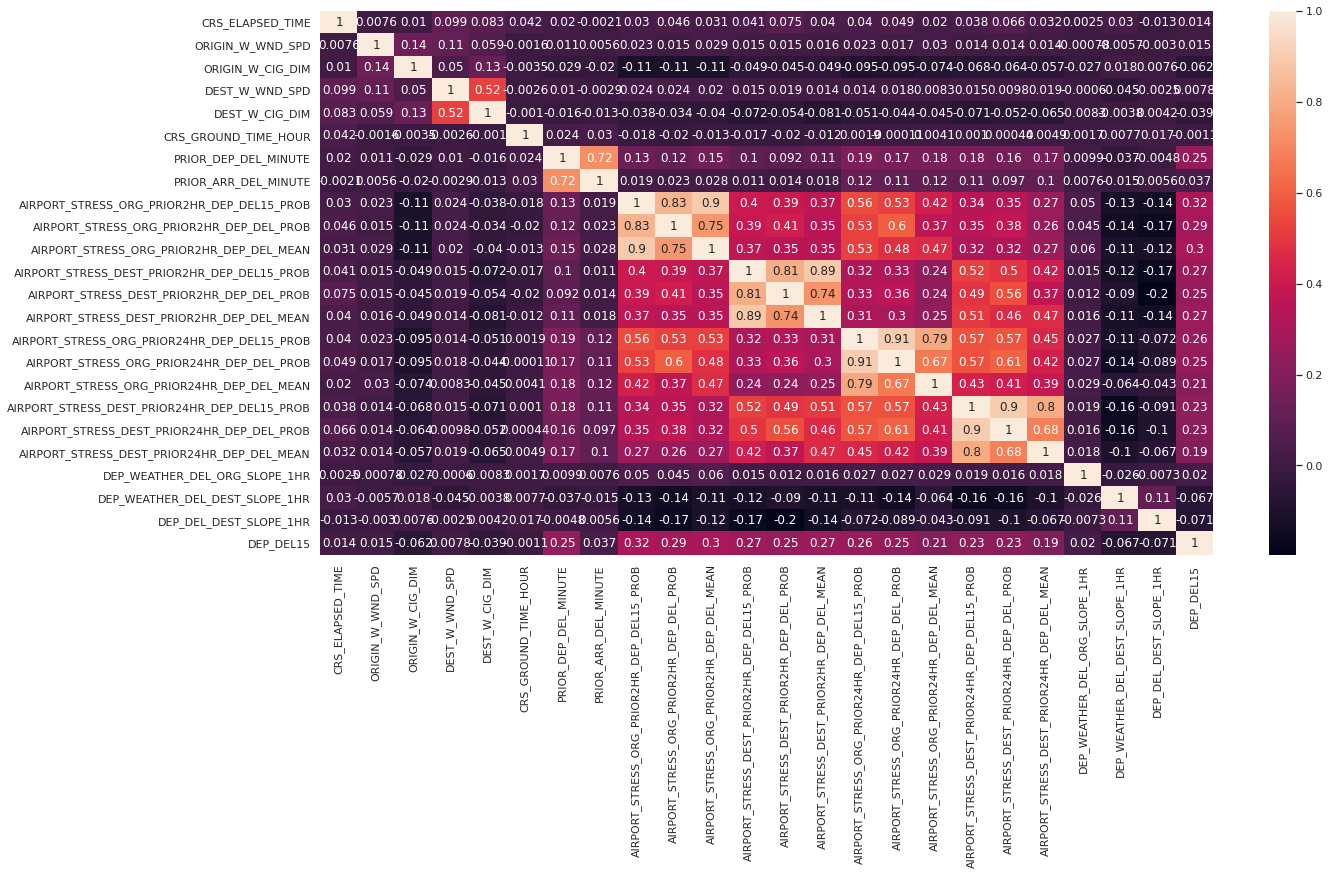

<matplotlib.axes._subplots.AxesSubplot at 0x7f3a8e2377f0>

In [0]:
train_set_woe_pddf = train_set.select(*FEATURES_SELECT_BY_WOE).toPandas()
plt.figure(figsize=(20,10))
sns.heatmap(train_set_woe_pddf.corr(), annot=True)

In [0]:
""" Trim features after using correlation heatmap on the prior WOE+IV filtered features (30 features left)
"""
LABEL = ['DEP_DEL15']
CAT_FEATURES_SELECT = [
          'MONTH', 
          'DAY_OF_MONTH', 
          'DAY_OF_WEEK', 
          'OP_CARRIER_AIRLINE_ID', 
          'TAIL_NUM', 
          'OP_CARRIER_FL_NUM', 
          'ORIGIN_AIRPORT_ID', 
          'DEST_AIRPORT_ID', 
          'CRS_DEP_HOUR',
          'CRS_ARR_HOUR',
          'ORIGIN_POOR_VIS',
          'DEST_POOR_VIS',
          'PRIOR_ARR_DEL_INDEX',
          'PRIOR_DEP_DEL15', 
          'PRIOR_DISTANCE_GROUP',
          'DEP_DEL_OEG_TREND_UP_1HR',
          'DEP_DEL_DEST_TREND_UP_1HR',
]
NUM_FEATURES_SELECT = [
        'CRS_ELAPSED_TIME',
        'ORIGIN_W_WND_SPD', 
        'ORIGIN_W_CIG_DIM', 
        'DEST_W_WND_SPD', 
        'DEST_W_CIG_DIM', 
        'CRS_GROUND_TIME_HOUR', 
        'PRIOR_DEP_DEL_MINUTE',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB',
        'DEP_WEATHER_DEL_ORG_SLOPE_1HR',
        'DEP_WEATHER_DEL_DEST_SLOPE_1HR',
        'DEP_DEL_DEST_SLOPE_1HR'
]

## Training Pipeline

Our pipeline is built using SPARK’s `Pipeline` library. During the data split stage, all categorical features are transformed to string type while all numerical features are transformed to float type. The label, `DEP_DEL15`, on the other hand, is transformed to int. During the pipeline building process in this section, we then encode all categorical features first using `StringIndexer` and then `OneHotEncoder`. The one hot encoding after `StringIndexer` is necessary for fitting to a wide range of models including Gradient Boosted Decision Tree (GBT). For example, without one hot encoding after `StringIndexer`, the hyperparameter `maxBins` would have to be set extremely high because of the large range of options presented by some categorical variables such as flight number in our dataset.  

Our function to assemble the training pipeline also include additional arguments including filling the missing value using the means (for toying with the logistic regression baseline model that we decide not to fine-tune), scaling the numerical variables, and downsampling the negative examples, which is an important hyperparameter for fine-tuning our final model, GBT. At the end of the pipeline, assemble all features values into one single “vectorized” column named `features` as the input for the model.

In [0]:
"""Functions for building the training pipeline.
"""
# yyc - full year
# yc - dec only
# yc_3m - 10, 11, 12
SPLIT_PARQUET_SUFIX = 'yc_3m'
TRAIN_DATA_PATH = f'{ROOT_TEAM30_URL}/train/train_{SPLIT_PARQUET_SUFIX}.parquet'
VALID_DATA_PATH = f'{ROOT_TEAM30_URL}/train/valid_{SPLIT_PARQUET_SUFIX}.parquet'
TEST_DATA_PATH = f'{ROOT_TEAM30_URL}/train/test_{SPLIT_PARQUET_SUFIX}.parquet'

def build_datasets(cat_features : list,
                   num_features : list,
                   train_years  : list = [2017],
                   valid_years  : list = [2018],
                   test_years   : list = [2019],
                   label        : str = 'DEP_DEL15',
                   train_path   : str = TRAIN_DATA_PATH,
                   valid_path   : str = VALID_DATA_PATH,
                   test_path    : str = TEST_DATA_PATH,
                   build_test   : bool = False,
                   scale        : bool = False,
                   downsample   : tuple = (False, 1),
                   missing      : bool = False,
                   filter_data  : bool = True) -> tuple:
    """Build datasets for training/evaluating model.
    """
    if filter_data:
        train_df = spark.read.option("header", "true") \
                        .parquet(train_path) \
                        .select(cat_features + num_features + [label]) \
                        .where(f.col('YEAR').isin(train_years))
        valid_df = spark.read.option("header", "true") \
                        .parquet(valid_path) \
                        .select(cat_features + num_features + [label]) \
                        .where(f.col('YEAR').isin(valid_years))
        test_df = spark.read.option("header", "true") \
                       .parquet(test_path) \
                       .select(cat_features + num_features + [label]) \
                       .where(f.col('YEAR').isin(test_years))
    else:
        train_df = spark.read.option("header", "true") \
                        .parquet(train_path) \
                        .where(f.col('YEAR').isin(train_years))
        valid_df = spark.read.option("header", "true") \
                        .parquet(valid_path) \
                        .where(f.col('YEAR').isin(valid_years))
        test_df = spark.read.option("header", "true") \
                       .parquet(test_path) \
                       .where(f.col('YEAR').isin(test_years))
    
    # missing values are simply filled with means
    # this is mostly just for toying with logistic regression; tres models will skip filling the mising values
    if missing:
        avg_ORIGIN_W_WND_SPD = train_df.where(f.col("ORIGIN_W_WND_SPD") != 9999).agg(f.avg("ORIGIN_W_WND_SPD")).first()[0]
        train_df.withColumn("ORIGIN_W_WND_SPD", f.when((f.col("ORIGIN_W_WND_SPD") == 9999), avg_ORIGIN_W_WND_SPD).otherwise(f.col("ORIGIN_W_WND_SPD")))
        avg_DEST_W_WND_SPD = train_df.where(f.col("DEST_W_WND_SPD") != 9999).agg(f.avg("DEST_W_WND_SPD")).first()[0]
        train_df.withColumn("DEST_W_WND_SPD", f.when((f.col("DEST_W_WND_SPD") == 9999), avg_DEST_W_WND_SPD).otherwise(f.col("DEST_W_WND_SPD")))
        
        avg_ORIGIN_W_CIG_DIM = train_df.where(f.col("ORIGIN_W_CIG_DIM") != 99999).agg(f.avg("ORIGIN_W_CIG_DIM")).first()[0]
        train_df.withColumn("ORIGIN_W_CIG_DIM", f.when((f.col("ORIGIN_W_CIG_DIM") == 99999), avg_ORIGIN_W_CIG_DIM).otherwise(f.col("ORIGIN_W_CIG_DIM")))
        avg_DEST_W_CIG_DIM = train_df.where(f.col("DEST_W_CIG_DIM") != 99999).agg(f.avg("DEST_W_CIG_DIM")).first()[0]
        train_df.withColumn("DEST_W_CIG_DIM", f.when((f.col("DEST_W_CIG_DIM") == 99999), avg_DEST_W_CIG_DIM).otherwise(f.col("DEST_W_CIG_DIM")))        

        avg_ORIGIN_W_WND_SPD = valid_df.where(f.col("ORIGIN_W_WND_SPD") != 9999).agg(f.avg("ORIGIN_W_WND_SPD")).first()[0]
        valid_df.withColumn("ORIGIN_W_WND_SPD", f.when((f.col("ORIGIN_W_WND_SPD") == 9999), avg_ORIGIN_W_WND_SPD).otherwise(f.col("ORIGIN_W_WND_SPD")))
        avg_DEST_W_WND_SPD = valid_df.where(f.col("DEST_W_WND_SPD") != 9999).agg(f.avg("DEST_W_WND_SPD")).first()[0]
        valid_df.withColumn("DEST_W_WND_SPD", f.when((f.col("DEST_W_WND_SPD") == 9999), avg_DEST_W_WND_SPD).otherwise(f.col("DEST_W_WND_SPD")))
        
        avg_ORIGIN_W_CIG_DIM = valid_df.where(f.col("ORIGIN_W_CIG_DIM") != 99999).agg(f.avg("ORIGIN_W_CIG_DIM")).first()[0]
        valid_df.withColumn("ORIGIN_W_CIG_DIM", f.when((f.col("ORIGIN_W_CIG_DIM") == 99999), avg_ORIGIN_W_CIG_DIM).otherwise(f.col("ORIGIN_W_CIG_DIM")))
        avg_DEST_W_CIG_DIM = valid_df.where(f.col("DEST_W_CIG_DIM") != 99999).agg(f.avg("DEST_W_CIG_DIM")).first()[0]
        valid_df.withColumn("DEST_W_CIG_DIM", f.when((f.col("DEST_W_CIG_DIM") == 99999), avg_DEST_W_CIG_DIM).otherwise(f.col("DEST_W_CIG_DIM")))           
      
        avg_ORIGIN_W_WND_SPD = test_df.where(f.col("ORIGIN_W_WND_SPD") != 9999).agg(f.avg("ORIGIN_W_WND_SPD")).first()[0]
        test_df.withColumn("ORIGIN_W_WND_SPD", f.when((f.col("ORIGIN_W_WND_SPD") == 9999), avg_ORIGIN_W_WND_SPD).otherwise(f.col("ORIGIN_W_WND_SPD")))
        avg_DEST_W_WND_SPD = test_df.where(f.col("DEST_W_WND_SPD") != 9999).agg(f.avg("DEST_W_WND_SPD")).first()[0]
        test_df.withColumn("DEST_W_WND_SPD", f.when((f.col("DEST_W_WND_SPD") == 9999), avg_DEST_W_WND_SPD).otherwise(f.col("DEST_W_WND_SPD")))
        
        avg_ORIGIN_W_CIG_DIM = test_df.where(f.col("ORIGIN_W_CIG_DIM") != 99999).agg(f.avg("ORIGIN_W_CIG_DIM")).first()[0]
        test_df.withColumn("ORIGIN_W_CIG_DIM", f.when((f.col("ORIGIN_W_CIG_DIM") == 99999), avg_ORIGIN_W_CIG_DIM).otherwise(f.col("ORIGIN_W_CIG_DIM")))
        avg_DEST_W_CIG_DIM = test_df.where(f.col("DEST_W_CIG_DIM") != 99999).agg(f.avg("DEST_W_CIG_DIM")).first()[0]
        test_df.withColumn("DEST_W_CIG_DIM", f.when((f.col("DEST_W_CIG_DIM") == 99999), avg_DEST_W_CIG_DIM).otherwise(f.col("DEST_W_CIG_DIM")))   
    
    if downsample[0]:
        pos_df = train_df.filter(f.col(label) == 1)
        neg_df = train_df.filter(f.col(label) == 0)
        train_df = neg_df.sample(False, downsample[1], seed=261).unionAll(pos_df)
    
    # build label col
    train_df = train_df.withColumn('LABEL', f.col(label))
    valid_df = valid_df.withColumn('LABEL', f.col(label))
    test_df = test_df.withColumn('LABEL', f.col(label))
    
    # assembly pipeline
    stages=[]

    # encode & assemble categorical features
    for feature in cat_features:
        # From doc:
        # StringIndexer.setHandleInvalid defines the strategy how StringIndexer will 
        # handle unseen labels when you have fit a StringIndexer on one dataset and then 
        # use it to transform another:
        # - 'error': throws an exception (which is the default)
        # - 'skip': skips/removes the rows containing the unseen labels entirely
        # - 'keep': puts unseen labels in a special additional bucket, at index numLabels
        x_si = StringIndexer(inputCol=feature, outputCol=feature+'_SI')
        x_si.setHandleInvalid("keep")
        x_oh = OneHotEncoder(inputCols=[feature+'_SI'], outputCols=[feature+'_OH'])
        stages.extend([x_si, x_oh])
    va_cat = VectorAssembler(inputCols=[f + '_OH' for f in cat_features], outputCol='FEATURES_CAT')
    stages.extend([va_cat])

    # assemble numerical features
    if scale:
        va_num = VectorAssembler(inputCols=num_features, 
                                 outputCol='FEATURES_NUM_NO_SCALE')
        va_num.setHandleInvalid("skip")
        scaler = RobustScaler(inputCol="FEATURES_NUM_NO_SCALE", 
                              outputCol="FEATURES_NUM",
                              withScaling=True, 
                              withCentering=False,
                              lower=0.25, 
                              upper=0.75)
        stages.extend([va_num, scaler])
    else:
        va_num = VectorAssembler(inputCols=num_features, outputCol='FEATURES_NUM')
        va_num.setHandleInvalid("skip")
        stages.extend([va_num])

    # build features col
    va_all = VectorAssembler(inputCols=['FEATURES_CAT', 'FEATURES_NUM'], outputCol="FEATURES")
    stages.append(va_all)

    # train pipeline
    pipeline = Pipeline(stages=stages)
    model_pipeline = pipeline.fit(train_df)

    # transform datasets
    train_df = model_pipeline.transform(train_df)
    valid_df = model_pipeline.transform(valid_df)
    if build_test:
        test_df = model_pipeline.transform(test_df)
    else:
        test_df = None
    
    return (train_df, valid_df, test_df)
  
class CurveMetrics(BinaryClassificationMetrics):
    """Class to return PR/ROC curve points.
    """
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
      
def evaluate(preds_train: pyspark.sql.dataframe.DataFrame, 
             preds_valid: pyspark.sql.dataframe.DataFrame,
             classifier_name: str,
             print_metrics: bool = True,
             train_col_name: str = 'Train',
             valid_col_name: str = 'Validation', 
             print_auc: bool = True) -> pyspark.sql.dataframe.DataFrame:
    """Function to print the performance report.
    """
    if print_auc:
        rdd_train_b = preds_train.select('LABEL','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['LABEL'])))
        rdd_valid_b = preds_valid.select('LABEL','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['LABEL'])))
        metrics_b_train = BinaryClassificationMetrics(rdd_train_b)
        metrics_b_valid = BinaryClassificationMetrics(rdd_valid_b)
    
    preds_train = preds_train.withColumn('LABEL',  f.col('LABEL').cast('double'))
    preds_valid = preds_valid.withColumn('LABEL',  f.col('LABEL').cast('double'))
    
    rdd_train_m = preds_train.select(['prediction', 'LABEL']).rdd
    rdd_valid_m = preds_valid.select(['prediction', 'LABEL']).rdd
    metrics_m_train = MulticlassMetrics(rdd_train_m)
    metrics_m_valid = MulticlassMetrics(rdd_valid_m)
    
    # pull metrics
    if print_auc:
        results_pddf = pd.DataFrame({
                          ' '         : [train_col_name, valid_col_name],
                          'PR AUC'    : [metrics_b_train.areaUnderPR, metrics_b_valid.areaUnderPR],
                          'ROC AUC'   : [metrics_b_train.areaUnderROC, metrics_b_valid.areaUnderROC],
                          'F0.5 Score': [metrics_m_train.fMeasure(1.0), metrics_m_valid.fMeasure(1.0, 0.5)],
                          'F2 Score'  : [metrics_m_train.fMeasure(1.0), metrics_m_valid.fMeasure(1.0, 2.0)],
                          'Recall'    : [metrics_m_train.recall(label=1), metrics_m_valid.recall(1)],
                          'Precision' : [metrics_m_train.precision(1), metrics_m_valid.precision(1)],
                          'Accuracy'  : [metrics_m_train.accuracy, metrics_m_valid.accuracy]})
    else:
        results_pddf = pd.DataFrame({
                          ' '         : [train_col_name, valid_col_name],
                          'F0.5 Score': [metrics_m_train.fMeasure(1.0), metrics_m_valid.fMeasure(1.0, 0.5)],
                          'F2 Score'  : [metrics_m_train.fMeasure(1.0), metrics_m_valid.fMeasure(1.0, 2.0)],
                          'Recall'    : [metrics_m_train.recall(label=1), metrics_m_valid.recall(1)],
                          'Precision' : [metrics_m_train.precision(1), metrics_m_valid.precision(1)],
                          'Accuracy'  : [metrics_m_train.accuracy, metrics_m_valid.accuracy]})
    results_pddf = results_pddf.set_index(' ')
      
    # print/plot results
    if print_metrics:
        # print results
        pd.set_option("display.precision", 4)
        print(classifier_name)
        print(results_pddf.T)
        
        if print_auc:
            sns.set(font_scale=1, style='whitegrid')
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
            metrics_valid = CurveMetrics(rdd_valid_b)

            # plot PR AUC
            points_pr = metrics_valid.get_curve('pr')
            x_val = [x[0] for x in points_pr]
            y_val = [x[1] for x in points_pr]
            axes[0].plot(x_val, y_val, color='lightsalmon')
            axes[0].set_xlabel('Recall')
            axes[0].set_ylabel('Precision')
            axes[0].set_title(f'PR Curve - {valid_col_name}')

            # plot ROC AUC
            points_roc = metrics_valid.get_curve('roc')
            x_val = [x[0] for x in points_roc]
            y_val = [x[1] for x in points_roc]
            axes[1].plot(x_val, y_val, color='lightsteelblue')
            axes[1].set_xlabel('1-Specificity')
            axes[1].set_ylabel('Recall')
            axes[1].set_title(f'ROC Curve - {valid_col_name}')
            
            plt.show()

        # a dumb hack to take care of the legacy codes
        return None 
    else:
        return results_pddf
    
def plot_confusion_matrix(preds_df: pyspark.sql.dataframe.DataFrame,
                          title: str,
                          rotate_matrix: bool = True,
                          normalize: bool = False) -> None:
    """Plot the confusion matrix. Ref: https://tinyurl.com/yh377wwa
    """
  
    def plot_cm(cm: confusion_matrix, 
                classes: list,
                normalize: bool = normalize,
                title: str = title,
                rotate_matrix: bool = rotate_matrix):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum()
        # rotate the matrix for a more familiar presentation
        if rotate_matrix:
            cm = np.rot90(cm, 2) 

        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()

        # class labels need to be roated as well
        classes_parsed = classes
        if rotate_matrix:
            classes_parsed = np.array(classes_parsed).reshape(2, 1)
            classes_parsed = np.rot90(classes_parsed, 2).flatten().tolist()

        tick_marks = np.arange(len(classes_parsed))
        plt.xticks(tick_marks, classes_parsed)
        plt.yticks(tick_marks, classes_parsed)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Prediction')
        plt.show()
    
    # extract labels
    class_temp = preds_df.select("LABEL").groupBy("LABEL")\
                         .count().sort('count', ascending=False).toPandas()
    class_temp = class_temp["LABEL"].values.tolist()
    class_names = list(map(str, class_temp))
    
    # extract predictions
    y_true = preds_df.select('LABEL').withColumn('LABEL', f.col('LABEL').cast('int').cast('string'))
    y_true = y_true.toPandas()
    y_pred = preds_df.select('PREDICTION').withColumn('PREDICTION', f.col('PREDICTION').cast('int').cast('string'))
    y_pred = y_pred.toPandas()
    cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
    
    # plot
    plot_cm(cnf_matrix, class_names)
    
def print_feature_importance(tree_model, 
                             preds_df: pyspark.sql.dataframe.DataFrame,
                             title: str) -> None:
    """plot the feature importance scores for tree models.  
    """
    feature_names = preds_df.schema["FEATURES"].metadata["ml_attr"]["attrs"]
    dict_feature_names={}
    for key in feature_names.keys():
      for i in range(len(feature_names[key])):
        dict_feature_names[feature_names[key][i]['idx']]= feature_names[key][i]['name']
    
    feature_names = pd.DataFrame(list(dict_feature_names.items()),columns = ['index','name'])
    importance = tree_model.featureImportances
    imp = pd.DataFrame(importance.toArray())
    imp.rename( columns={0:'score'}, inplace=True )
    
    df1 = imp.sort_values('score',ascending = False).head(20)
    df1 = df1.reset_index()
    df2 = pd.merge(feature_names, df1, on='index')
    df2 = df2.sort_values('score', ascending=False)

    sns.set(font_scale=1, style='whitegrid')
    plt.subplots(figsize=(16,10))
    ax = sns.barplot(x='score', y='name', data=df2, color='lightsteelblue')
    ax.set_xlabel('Feature Importance Score')
    ax.set_ylabel('Feature Name')
    ax.set_title(title)

## Baseline Modeling
A total of four baseline models are explored in this section:

- Logistics Regresion (LR)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Gradient Boosted Tree (GBT)

Note that the models are built with minimal effort on fine-tuning (mostly with default hyperparameters) and are trained using only select features from the original raw datasets. All models are trained using 2018 as the validation set and 2017 as the training set. No cross validation is done. The purpose of running these baseline models is to assess the characteristics of their outputs upon the validation set, compared to the training set, for us to determine our final model of choice. We will also consider the bias-variance tradeoff across the models. Given the significant inherent class imbalance present within the dataset, we expect model performance to be affected negatively. After selecting our final model of choice based on experimenting with baseline models, we perform further hyperparameter fine-tuning fine-tune the model performance.

Lastly, given the limited resources, we only include three months of data from each year: October, November, and December. We believe that the three months come with a good representation of the delay distributions across high/low seasons and extreme weather conditions such as a snowstorm.

#### Results Summary & Model Selection  
The results from our four baseline models with minimum effort on fine-tuning are summarized by the table below.  

|                              	|     LR 	|     RF 	|    GBT 	|    SVM 	|
|------------------------------	|-------:	|-------:	|-------:	|-------:	|
| PR AUC                       	| 0.5033 	| 0.4957 	| 0.6277 	|    n/a 	|
| ROC AUC                      	| 0.7841 	| 0.7782 	| 0.8189 	|    n/a 	|
| F0.5 Score                   	| 0.4172 	| 0.4499 	| 0.4763 	| 0.3763 	|
| Recall                       	| 0.6411 	| 0.1793 	| 0.6463 	| 0.6584 	|
| Precision                    	| 0.3837 	| 0.7223 	|  0.447 	| 0.3399 	|
| Accuracy                     	| 0.7707 	| 0.8531 	| 0.8095 	| 0.7133 	|
| 3-Month Training Time (Min.) 	|   1.88 	|   3.43 	|   4.21 	|   2.38 	|

Of the four models we test, GBT shows the most promising performance given our preliminary experiments on features and hyperparameters. However, the baseline performance alone is not enough to justify our model choice. Afterall, all four models have room for improvement given our minimum effort on fine-tuning. In general, we have four evaluation criteria when it comes to choosing our final model:

-	**Performance**: How much room is there for further performance improvement?
-	**Efficiency**: What is the time/space complexity for training and predication? 
-	**Stability**: All four baseline models are trained/validated on 3 months of data from 2017 and 2018. Is the model capable of scaling up with up to 3 to 4 full years of training data? Is the model properly implemented and supported by Sparks?
-	**Interoperability**: Can we interpret the model? Does the model allow us to understand the performance of each feature? Does the model produce a probability or only the classification as the final output?
  
![Model Select](https://www.dropbox.com/s/92y2v0dvsbrsgxr/model_select.png?raw=1)  
  
Overall, GBT is our final choice for the following reasons:
- **Interoperability**: LR, GBT and RF are probabilistic (i.e. model produces a probability for classification at the end) and so are more interpretable than LSVM. Using LR, GBT and RF allows us to produce PR Curve and fine-tune the classification probability threshold for an optimal F0.5.
- **Performance**: RF and GBT have a nature fit with our airlines/weather datasets which come with a wide range of categorical and numerical features with missing values. They are both nonlinear classifier and are generally capable of handling missing values and outliers without the need for normalization.
- **Performance Tradeoffs:**: While LR is known for its efficiency in dealing with large dataset (i.e. less training/predicting time), the two tree models, RF and GBT, in our experiments does seem to result in more performance out of box with minimum efforts on fine-tuning. In this project, we opt for maximum performance instead of efficiency.
- **Model Characteristics**: Between the two tree models, RF and GBT, our final choice is GBT for two reasons: 
  - RF’s random sampling can easily cause data leaks (i.e. using future data to predict past flights) with certain features. 
  - We observe in our baseline models that a tree model can easily be overfit to the training set. A typical resolution for overfitting is to include more variance in the dataset by adding more data. However, we believe that the variance in our dataset is minimal from year to year, so adding more data would provide little to no help. As such, we prefer a model with an emphasis on reducing bias rather than variance.

In [0]:
"""Define the features used for all baseline models.
"""
CAT_FEATURES_BASELINE = [
        'MONTH',
        'DAY_OF_MONTH',
        'DAY_OF_WEEK',
        'OP_CARRIER_AIRLINE_ID',
        'TAIL_NUM',
        'OP_CARRIER_FL_NUM',
        'ORIGIN_AIRPORT_ID',
        'DEST_AIRPORT_ID',
        'CRS_DEP_HOUR',
        'CRS_ARR_HOUR',
        'ORIGIN_POOR_VIS',
        'DEST_POOR_VIS',
        'PRIOR_ARR_DEL_INDEX',
        'PRIOR_ARR_DEL15',
        'PRIOR_DEP_DEL15',
        'PRIOR_DISTANCE_GROUP',
        'DEP_DEL_OEG_TREND_UP_1HR',
        'DEP_DEL_DEST_TREND_UP_1HR',
]
NUM_FEATURES_BASELINE = [
        'CRS_ELAPSED_TIME',
        'ORIGIN_W_WND_SPD',
        'ORIGIN_W_CIG_DIM',
        'DEST_W_WND_SPD', 
        'DEST_W_CIG_DIM',
        'ORIGIN_FOG_RISK',
        'DEST_FOG_RISK',
        'CRS_GROUND_TIME_HOUR',
        'PRIOR_DEP_DEL_MINUTE',
        'DEP_DEL_MEAN_ODPAIR_PRIOR2HR',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL15_PROB',
        'DEP_WEATHER_DEL_DEST_SLOPE_1HR',
        'DEP_WEATHER_DEL_PROB_DEST_PRIOR_1HR',
        'DEP_DEL_DEST_SLOPE_1HR'
]

### Model Candidates

#### Logistic Regression (LR)

**Justification and Tradeoffs**

We use logistic regression as our first baseline model as it is relatively straightforward and efficient to train and the derived coefficients provide information by the magnitude and direction. However, logistic regression assumes a linear boundary between the features and outcome variable, which may not be true due to the size and complexity of the feature space. We also lose information from missing/null values provided by the original dataset, as they need to be cleaned for logistic regression to run. Lastly, we are not using interaction terms for this model, to allow for a closer comparison of the results from this algorithm compared to the others.

**Results**

Using a mix of L1 and L2 regularization, we achieve a PR AUC of 0.5033 and a F0.5 score of 0.4172 on the validation set. We note that the results for the validation set significantly worsen when compared to the training set. This suggests that overfitting is an issue, leading to significant variance for this logistic regression model. The hyperparameters are not tuned completely and we have left the threshold level at 0.5, with no class downsampling used. We will reference this set of results against the following models, to determine the final model for implementation.

Baseline Model: Logistic Regression
 Train Validation
PR AUC 0.7778 0.5033
ROC AUC 0.8024 0.7841
F0.5 Score 0.6681 0.4172
F2 Score 0.6681 0.5653
Recall 0.5942 0.6411
Precision 0.7630 0.3837
Accuracy 0.7467 0.7707

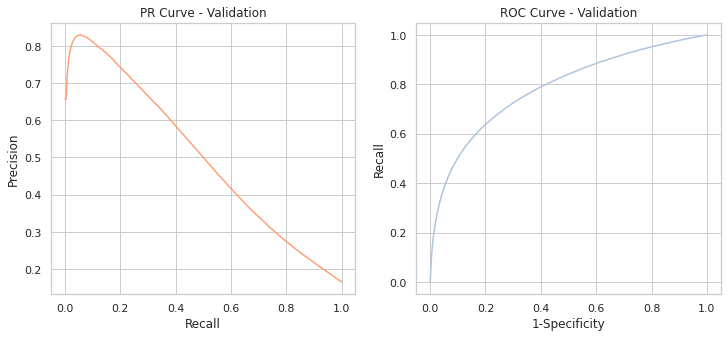

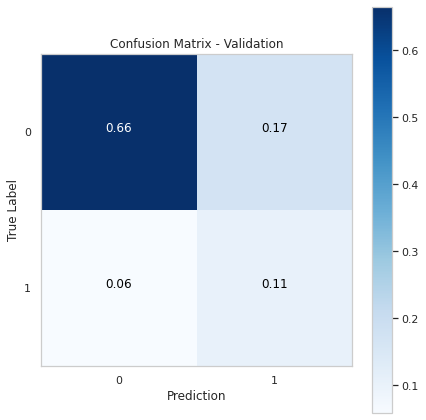

In [0]:
"""LR baseline is trained using the following datasets:
Training Set: 2017, 10, 11, 12
Validation Set: 2018, 10, 11, 12
"""
MAX_ITER = 15
NEGATIVE_DOWNSAMPLE = (True, 0.2)
SCALE = True
ALPHA = 0.1
LAMBDA = 0.01
THD = 0.5

# load datasets
train_df, valid_df, _ = build_datasets(CAT_FEATURES_BASELINE,
                                       NUM_FEATURES_BASELINE,
                                       downsample=NEGATIVE_DOWNSAMPLE, 
                                       scale=SCALE,
                                       missing=True)
# train
lr = LogisticRegression(labelCol="LABEL", 
                        featuresCol="FEATURES", 
                        maxIter=MAX_ITER, 
                        elasticNetParam=ALPHA,
                        regParam=LAMBDA)
model_lr = lr.fit(train_df)

# # prediction & performance evaluation
model_lr.setThreshold(THD)
preds_train = model_lr.transform(train_df.select('LABEL', 'FEATURES'))
preds_valid = model_lr.transform(valid_df.select('LABEL', 'FEATURES'))
evaluate(preds_train, preds_valid, 'Baseline Model: Logistic Regression')
plot_confusion_matrix(preds_valid, 'Confusion Matrix - Validation', rotate_matrix=False, normalize=True)

#### Linear SVM (LSVM)
Note that we cannot print PR AUC and ROC AUC for SVM because SVM does not out probabilities. One heavily critized method is to use the distance to the decision boundary but  

**Justification and Tradeoff**  
SVMs take datapoints belonging to multiple classes and finds a hyperplane that best separates the classes. The best hyperplane is calculated by maximizing margins from the classes in question (binary in our case). SVMs can relatively efficiently create a decision boundary at fairly high accuracy. However in our case, the data imbalance can pose an issue. In our setting (~20% delay, ~80% no delay), we can get a model with deceptively high accuracy (around 80%) simply by predicting no delay for each case. Although this would show decent accuracy, it is a completely useless model and has 0 precision and recall since we do not predict any positives, giving us no true positives. We are using linear SVMs, which can also be problematic if our boundaries are not linear. Further, we cannot print PR AUC and ROC AUC for SVM models because SVMs are non-probabilistic models, and do not naturally output probabilities.
  
**Results**  
The base model gives similar values for F1, precision, recall, accuracy (roughly 0.72~0.75) once we adjust for the class imbalance. However there is clear overfitting, as on unseen data the model performs significantly worse, with all four metrics dropping - F1 and precision take the largest hit, dropping by nearly 30%.

Baseline Model: SVM
 Train Validation
F0.5 Score 0.7646 0.3763
Recall 0.7525 0.6584
Precision 0.7771 0.3399
Accuracy 0.7527 0.7133

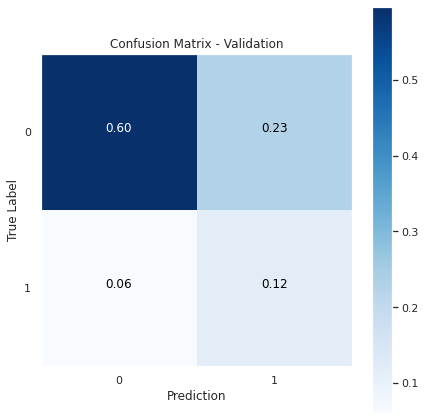

In [0]:
"""SVM baesline is trained using the following datasets:
Training Set: 2017, 10, 11, 12
Validation Set: 2018, 10, 11, 12
"""
MAX_ITER = 10
NEGATIVE_DOWNSAMPLE = (True, 0.2)
SCALE = True
LAMBDA = 0.01
THD = 0.5

# load datasets
train_df, valid_df, test_df = build_datasets(CAT_FEATURES_BASELINE,
                                             NUM_FEATURES_BASELINE,
                                             downsample=NEGATIVE_DOWNSAMPLE, 
                                             scale=SCALE)
# train
lsvm = LinearSVC(labelCol="LABEL", 
                 featuresCol="FEATURES", 
                 maxIter=MAX_ITER, 
                 regParam=LAMBDA)
model_lsvm = lsvm.fit(train_df)

# prediction & performance evaluation
preds_train = model_lsvm.transform(train_df.select('LABEL', 'FEATURES'))
preds_valid = model_lsvm.transform(valid_df.select('LABEL', 'FEATURES'))
evaluate(preds_train, preds_valid, 'Baseline Model: SVM', print_auc=False)
plot_confusion_matrix(preds_valid, 'Confusion Matrix - Validation', rotate_matrix=False, normalize=True)

#### Random Forest (RF)

**Justification and Tradeoffs**  
Random Forest is an ensemble algorithm. The idea is to train multiple base decision trees and take the majority vote as the ensemble prediction. Random Forest does not require special handling of missing values or data scaling, which works well for our datasets with missing values. Another advantage is that it allows randomness of feature selection for each decision tree, since each tress will look for the best features out of a random subset of features. On the other hand, since the dataset is imbalanced, and the ensemble is based on majority vote, it is likely the predictions will heavily weigh towards the negative class.  

**Results**  
We first try building a RF model without downsampling the negative examples, the result is poor: with a ROC AUC not much higher at 0.5 and PR AUC at 0.17 for the validation set. The accuracy, on the other hand, is high at 82%, but it is mainly due to the imbalance in the dataset. By downsampling negative class all the way to 0.2, the results improve significantly: We now have a PR AUC for the validation set at 0.4957 and ROC AUC is 0.7782. However, note that at `NUM_TREE=128`, the poor performance on PR AUC and precision on the validation set shows evidence of overfitting while recall and accuracy seem to suggest an underfit. Overall, we believe the discrepancy in performance between training and validation is a result of underfitting and the model would benefit with further fine-tuning.

Baseline Model: Random Forest
 Train Validation
PR AUC 0.7511 0.4957
ROC AUC 0.7740 0.7782
F0.5 Score 0.2129 0.4499
F2 Score 0.2129 0.2110
Recall 0.1202 0.1793
Precision 0.9294 0.7223
Accuracy 0.6183 0.8531

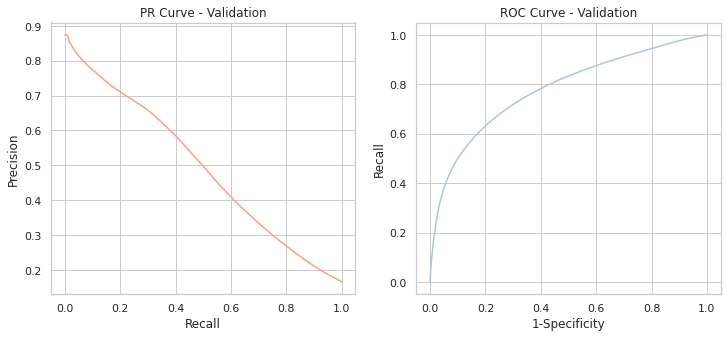

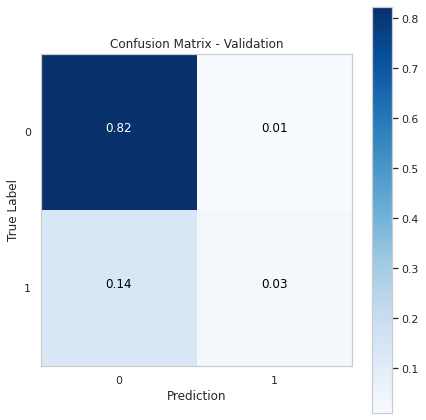

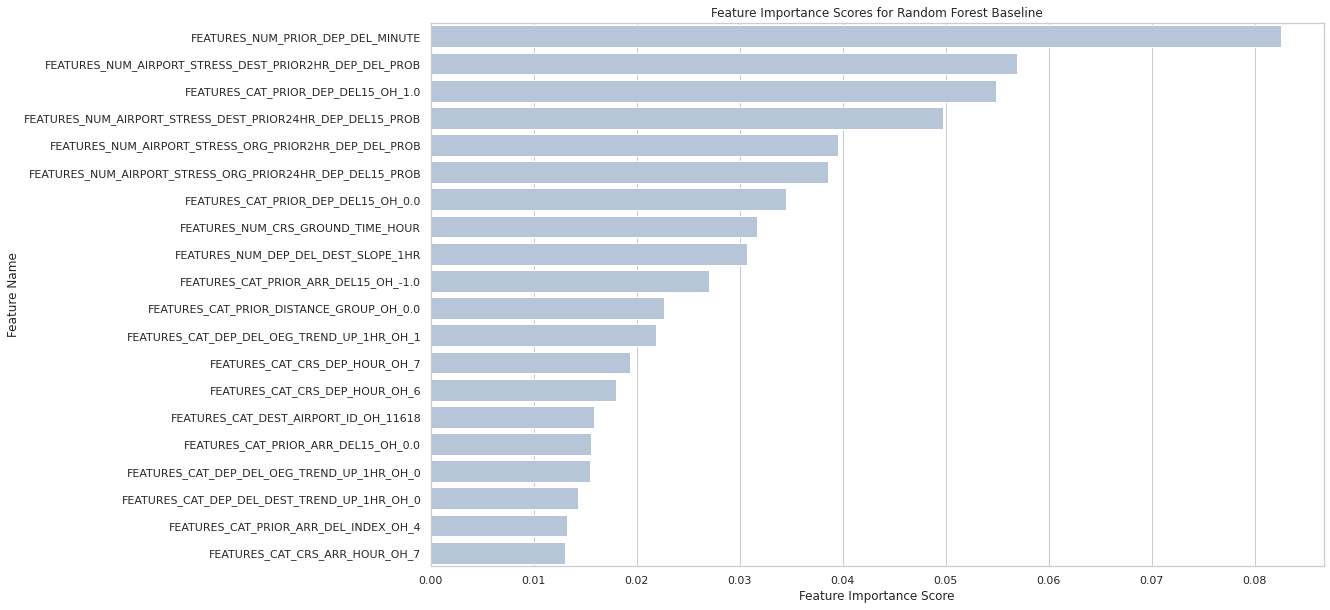

In [0]:
"""RF baeslineis trained using the following datasets:
Training Set: 2017, 10, 11, 12
Validation Set: 2018, 10, 11, 12
"""
NUM_TREE = 128
NEGATIVE_DOWNSAMPLE = (True, 0.2)
SCALE = False

# load datasets
train_df, valid_df, test_df = build_datasets(CAT_FEATURES_BASELINE,
                                             NUM_FEATURES_BASELINE,
                                             downsample=NEGATIVE_DOWNSAMPLE, 
                                             scale=SCALE)
# train
rf = RandomForestClassifier(labelCol="LABEL", 
                            featuresCol="FEATURES",
                            numTrees=NUM_TREE)
model_rf = rf.fit(train_df)

# prediction
preds_train = model_rf.transform(train_df.select('LABEL', 'FEATURES'))
preds_valid = model_rf.transform(valid_df.select('LABEL', 'FEATURES'))

# performance evaluation
evaluate(preds_train, preds_valid, 'Baseline Model: Random Forest')
plot_confusion_matrix(preds_valid, 'Confusion Matrix - Validation', rotate_matrix=False, normalize=True)
print_feature_importance(model_rf, preds_valid, 'Feature Importance Scores for Random Forest Baseline')

#### Gradient-Boosted Trees  

**Justification and Tradeoffs**  
Similar to Random Forest (RF), Gradient-Boosted Trees (GBT) ensembles a series of decision trees to provide an output. Decision Trees is a greedy algorithm that performs a recursive binary partitioning of the features. RF ensembles in parallel, while GBT ensembles sequentially. Both RF and GBT allow non-linear boundaries, avoid the need for manipulating missing/null data points or performing scaling/normalization and are robust against outliers. GBT is also a relatively efficient algorithm with a time complexity of O(T * D *F*nlogn) and space complexity of O(T2^D), where T is the number of trees, D is the depth of each tree, F is the number of features, n is size of the training set.

Both RF and GBT performance suffer when class imbalance is present. With flight delay as the minority (positive) class and non-delay as the majority (negative class), false negatives would have a larger penalty, compared to false positives. The difference in the treatment between false negatives and false positives, would bias the model outcomes. Similar to how we ran the RF model, we use downsampling for the GBT model too.

**Results**  
Using a max iteration of 10 with a tree depth of 5, we achieve a PR AUC of 0.6277 and a F0.5 score of 0.4763 on the validation set. These values are the best amongst the baseline models. We also note that the results between the training and validation sets differ the least in magnitude, when comparing between the baseline models. This suggests that GBT has the best bias-variance tradeoff, compared to the other models. Overall, GBT is efficient, works well with the given dataset, and allows for non-linear results. Given our findings and theoretical justification highlighted earlier in Model Selection, we choose **Gradient-Boosted Trees** as our final model of choice.

**Toy Example & Mathematical Explanation**  
The toy example and mathematical explanation are included in the section after Model Candidates as a reference.

Baseline Model: Gradient Boosted Tree
 Train Validation
PR AUC 0.8137 0.6277
ROC AUC 0.8143 0.8189
F0.5 Score 0.6766 0.4763
F2 Score 0.6766 0.5934
Recall 0.5882 0.6463
Precision 0.7963 0.4470
Accuracy 0.7585 0.8095

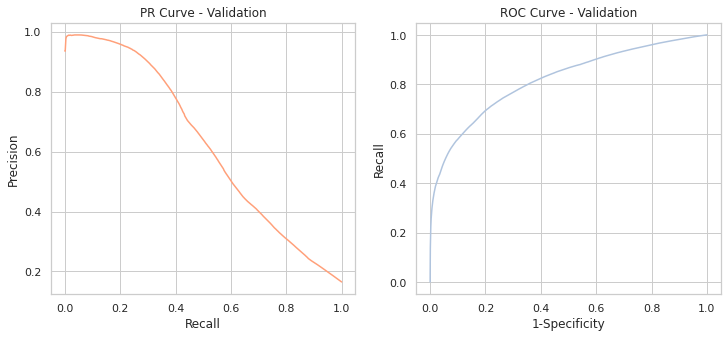

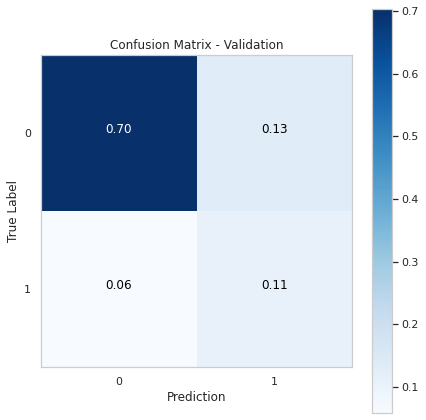

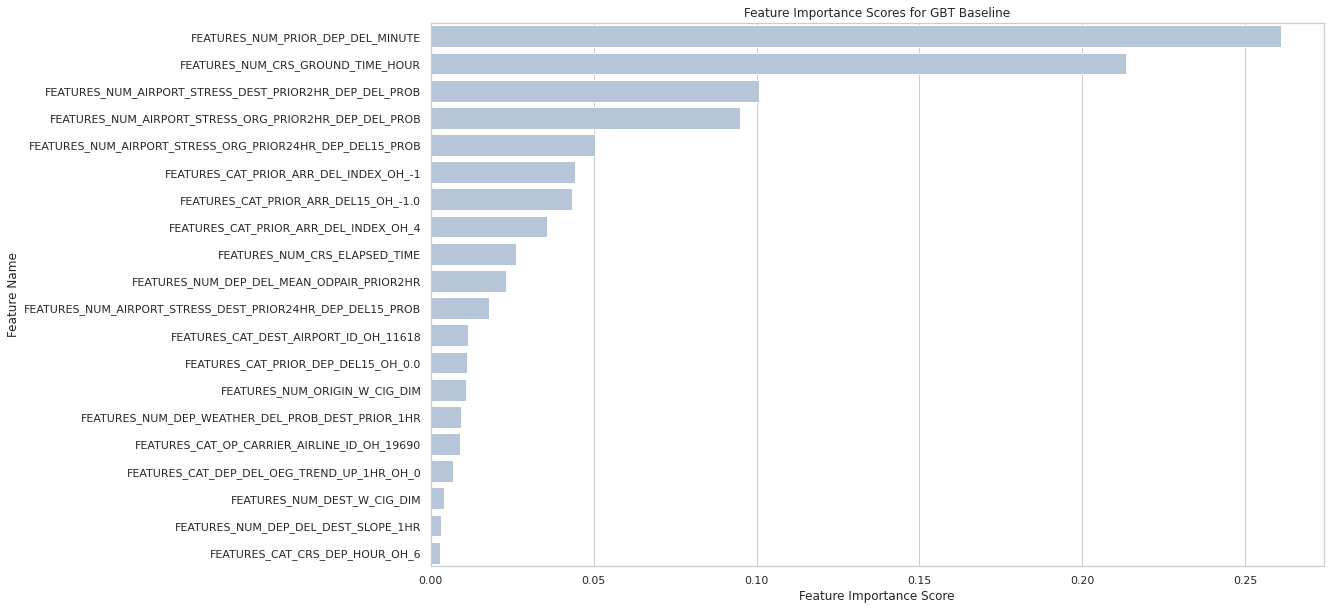

In [0]:
"""GBT baesline is trained using the following datasets:
Training Set: 2017, 10, 11, 12
Validation Set: 2018, 10, 11, 12
"""
LOAD_MODEL = False
MODEL_SAVE_PATH = f'{ROOT_TEAM30_URL}/models'

MAX_ITER = 10
NEGATIVE_DOWNSAMPLE = (True, 0.2)
SCALE = False
MAX_DEPTH = 5
MAX_BINS = 256
STEP_SIZE = 0.1
SCALE = False

# load datasets
train_df, valid_df, _ = build_datasets(CAT_FEATURES_BASELINE,
                                       NUM_FEATURES_BASELINE,
                                       downsample=NEGATIVE_DOWNSAMPLE, 
                                       scale=SCALE)

# train
if LOAD_MODEL:
    model_gbt = GBTClassificationModel().load(f'{MODEL_SAVE_PATH}/gbt_base')
else:
    gbt = GBTClassifier(labelCol="LABEL", 
                        featuresCol="FEATURES", 
                        maxIter=MAX_ITER,
                        maxDepth=MAX_DEPTH,
                        maxBins=MAX_BINS,
                        stepSize=STEP_SIZE)
    model_gbt = gbt.fit(train_df)
    model_gbt.write().overwrite().save(f'{MODEL_SAVE_PATH}/gbt_base')

# prediction
model_gbt.setThresholds([0.5, 0.5])
preds_train = model_gbt.transform(train_df.select('LABEL', 'FEATURES'))
preds_valid = model_gbt.transform(valid_df.select('LABEL', 'FEATURES'))

# performance evaluation
evaluate(preds_train, preds_valid, 'Baseline Model: Gradient Boosted Tree')
plot_confusion_matrix(preds_valid, 'Confusion Matrix - Validation', rotate_matrix=False, normalize=True)
print_feature_importance(model_gbt, preds_valid, 'Feature Importance Scores for GBT Baseline')

### Mathematical Explanation & Toy Example for GBT

#### GBT Math
We take a toy training dataset to explain the math behind GBT, which is the algorithm used in our final model.
The toy dataset consists of 8 features and a  binary lable, "delay/no delay". It contains 952 rows.

Step 1: get the log of odds of delay:

$$ log(\frac{delay}{non-delay}) $$

Step 2: convert log odds to probablity:
$$ \frac {e^{logodds}}{1 + e^{logodds}} $$

and then get the pseudo residuals 

$$ actual\ label - predicted\ probability $$

Step 3: 
build a shallow decision tree to predict the pseudoresiduals from step 2 and train it on the feature set. 
Each leaf of that tree contains one or more flights.
calculate the output from that tree, for each leaf. If a leaf contains multiple predictions/flights, calculate the log odds for the leaf using this formula:

$$ \frac {\sum(log odds)}{\sum((p_{prior}) \cdot (1- p_{prior}))} $$

Note this step is hidden in sklearn decision tree we used and the output is already a single-valued log odds for that leaf. 

Step 4: update original log odds  for each leaf with the new predictions, regularized with a learning rate. For the example, this is a parameter we can change in the funciton. 

$$ log odds + learning rate \cdot (output\ in\ step\ 3) $$

Step 5: use the value from step 4, convert it to probabilities and subtract it from the actual/observed labels to get the updated pseudo residuals..

This runs in a loop until maxIter = 0 and/or the predicted probability reaches a local minimum. These series of steps builds the GBT model, based on the training set.
In the example, the default is 10 loops.

#### GBT Toy Example  
Notebook: [GBT Toy Example](ttps://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441189954/command/1553213441189971)

We have built a toy example to demonstrate how GBT works step by step. The notebook can be found using the link above.

### PCA - Linear Separability

As a part of our model selection process, we ask the question: Are our predictions linearly separable given the features we have? While the question demands an examination using tools such as Linear Discriminant Analysis, intuition suggests that the complex nature of flight delays demand a nonlinear clarification model. To visualize the nonlinear complexity, we perform a quick analysis using PCA on numerical features and confirms that there is no clear linear separation between the two labels (15-minute delay vs. on-time) given our final feature set.

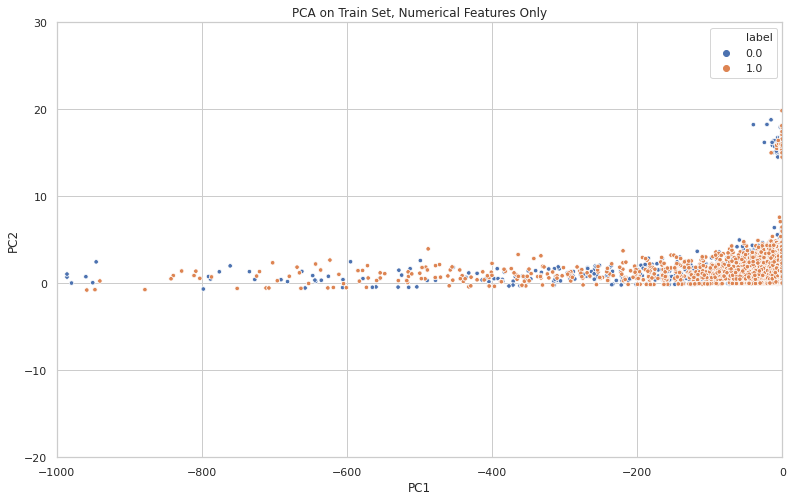

In [0]:
# train PCA
train_df, valid_df, _ = build_datasets(CAT_FEATURES_BASELINE,
                                       NUM_FEATURES_BASELINE,
                                       downsample=(True, 0.2), 
                                       scale=True,
                                       missing=True)
pca = PCA(k=2, inputCol="FEATURES_NUM", outputCol='FEATURES_PCA')
model_pca = pca.fit(train_df)
pca_df = pca_model.transform(train_df)
pca_dims = pca_df.select('FEATURES_PCA').toPandas()

# extract components
df = pd.DataFrame()
df['pc1'] = pca_dims.apply(lambda x: x[0][0], axis=1)
df['pc2'] = pca_dims.apply(lambda x: x[0][1], axis=1)
df['label'] = pca_df.select('LABEL').toPandas()

# plot
sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))
sns.scatterplot(data=df, x="pc1", y="pc2", hue="label", ax=ax, s=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_ylim(-20, 30)
ax.set_xlim(-1000, 0)
ax.set_title(f'PCA on Train Set, Numerical Features Only')
pass

## Model Fine-tuning  
Our fine-tuning funnel consists of three steps. K-fold CV is used for fine-tuning the model hyperparameters while fine-tuning years for training is limited to the simple train-validation split given that we only have 4 years of data in the training set. Lastly, classification probability threshold is fine-tuned by examing the PR Curve after we select out optimal model hyperparameters and number of years to be included for training.  
- Fine-tuning Model Hyperparameters Using K-fold CV  
- Fine-tuning Number of Years for Training  
- Fine-tuning Classification Probability Threshold  

![CV Process](https://www.dropbox.com/s/xn5tk08kdaxyh56/cv_process.png?raw=1)

### Random Search With K-Fold CV
Model hyperparameters are fine-tuned using **random grid search with 3-Fold CV**. As discussed in EDA, the airlines and weather data are highly seasonal. In addition, both datasets are time-series in nature. Due to the two characteristics above, we are unable to perform a cross-validation using random sampling, and instead opt for a 3-fold cross validation with each fold consisted of one full year of data and each training set trailing one year behind the validation set. This way, we capture seasonality and avoid time leaks at the same time. Our 3-fold splits are summarized by the diagram below:

![Cross Validation](https://www.dropbox.com/s/vy437ei09b9crgf/cv.png?raw=1)

Note that given the limited resources, we only include three months of data from each year: **October, November, and December**. We believe that the three months come with a good representation of the delay distributions across high/low seasons and extreme weather conditions such as a snowstorm. Also note that all data from 2019 are excluded from the CV as they are reserved for the test set used to evaluate the performance of our final model. 
 
We choose a total of five hyper-parameters for the random grid search: `max_iteration`, `max_tree_depth`, `max_tree_bin_num`, `tree_ step_size`, and `positive_downsample_ratio`. The first four hyperparameters are GBT-specific and we find them important in avoiding overfitting, which is a common issue for GBT with an unbalanced dataset. The last parameter, `positive_downsample_ratio`, is our attempt to balance the positive and negative examples in our dataset. Through trial-and-error, we learned that downsampling is way more effective than oversampling using techniques such as SMOTE.

We do NOT perform an exhaustive grid search. Instead, we opt for a simplified, iterative version of the random search: 
- We first build a list of pre-selected hyperparameters and value ranges.
- We then randomly pick `n` combinations (usually 10 to 20 per iteration) of the values for the CV. 
- We perform the same process for multiple iterations.
- In each new iteration, we update the hyperparameter value ranges by analyzing the performance results from the previous iteration.
- We repeat the same process and continue to narrow down the hyperparameter value ranges until significant improvement is no longer observed.

**Results**  
Downsampling helps improve performance. The optimal downsampling ratio for the negative examples looks to be approximately 0.4. We also notice that more data (i.e. lower positive example downsampling rate) can improve performance with more iterations. Lastly, increasing the number of depths seems to easily cause overfitting. The best strategy, as we observe, is shallow depth with more iterations/bins and downsampled negative examples.

In [0]:
"""Define the features used for CV.
"""
CAT_FEATURES_CV = [
        'MONTH',
        'DAY_OF_MONTH',
        'DAY_OF_WEEK',
        'OP_CARRIER_AIRLINE_ID',
        'TAIL_NUM',
        'OP_CARRIER_FL_NUM',
        'ORIGIN_AIRPORT_ID',
        'DEST_AIRPORT_ID',
        'CRS_DEP_HOUR',
        'CRS_ARR_HOUR',
        'ORIGIN_POOR_VIS',
        'DEST_POOR_VIS',
        'PRIOR_ARR_DEL_INDEX',
        'PRIOR_ARR_DEL15',
        'PRIOR_DEP_DEL15',
        'PRIOR_DISTANCE_GROUP',
        'DEP_DEL_OEG_TREND_UP_1HR',
        'DEP_DEL_DEST_TREND_UP_1HR'
]
NUM_FEATURES_CV = [
        'CRS_ELAPSED_TIME',
        'ORIGIN_W_WND_SPD',
        'ORIGIN_W_CIG_DIM',
        'DEST_W_WND_SPD', 
        'DEST_W_CIG_DIM',
        'ORIGIN_FOG_RISK',
        'DEST_FOG_RISK',
        'CRS_GROUND_TIME_HOUR',
        'PRIOR_DEP_DEL_MINUTE',
        'DEP_DEL_MEAN_ODPAIR_PRIOR2HR',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL15_PROB',
        'DEP_WEATHER_DEL_DEST_SLOPE_1HR',
        'DEP_WEATHER_DEL_PROB_DEST_PRIOR_1HR',
        'DEP_DEL_DEST_SLOPE_1HR'
]

In [0]:
def build_folds(
          cat_features: list = CAT_FEATURES_CV, 
          num_features: list = NUM_FEATURES_CV, 
          negative_downsample: tuple = (False, 1),
          scale: bool = False) -> None:
    """A total of three folds (validation-training pair) will be built: 2018-2017, 2017-2016, 2016-2015.
    Args:
        downsample_ratio (float): Ratio for downsampling the whole dataset. 
        negative_downsample (tuple): Ratio for downsampling ONLY the positive examples. 
    """
    folds = []
    for year_train, year_valid in zip((2017, 2016, 2015), (2018, 2017, 2016)):
        train_df, valid_df, _ = build_datasets(
                                          cat_features,
                                          num_features,
                                          train_years=[year_train],
                                          valid_years=[year_valid],
                                          downsample=negative_downsample, 
                                          scale=scale)
        folds.append({'train': train_df, 'valid': valid_df})

    return folds
  
def gbt_cv_by_year(model: GBTClassifier, folds: list) -> None:
    """Function to execute the k-fold cv.
    """
    train_prauc_list = []
    train_rocauc_list = []
    train_precision_list = []
    train_recall_list = []
    valid_prauc_list = []
    valid_rocauc_list = []
    valid_precision_list = []
    valid_recall_list = []
    for fold in folds:
        model_gbt = model.fit(fold['train'])
        preds_train = model_gbt.transform(fold['train'].select('LABEL', 'FEATURES'))
        preds_valid = model_gbt.transform(fold['valid'].select('LABEL', 'FEATURES'))
        
        performance = evaluate(preds_train, preds_valid, "GBT CV", False)
        train_prauc_list.append(performance.loc['Train', 'PR AUC'])
        train_rocauc_list.append(performance.loc['Train', 'ROC AUC'])
        train_precision_list.append(performance.loc['Train', 'Precision'])
        train_recall_list.append(performance.loc['Train', 'Recall'])
        
        valid_prauc_list.append(performance.loc['Validation', 'PR AUC'])
        valid_rocauc_list.append(performance.loc['Validation', 'ROC AUC'])
        valid_precision_list.append(performance.loc['Validation', 'Precision'])
        valid_recall_list.append(performance.loc['Validation', 'Recall'])
    
    return {
      'train_prauc': sum(train_prauc_list) / len(train_prauc_list),
      'valid_prauc': sum(valid_prauc_list) / len(valid_prauc_list),
      'train_rocauc': sum(train_rocauc_list) / len(train_rocauc_list),
      'valid_rocauc': sum(valid_rocauc_list) / len(valid_rocauc_list),
      'train_precision': sum(train_precision_list) / len(train_precision_list),
      'valid_precision': sum(valid_precision_list) / len(valid_precision_list),
      'train_recall': sum(train_recall_list) / len(train_recall_list),
      'valid_recall': sum(valid_recall_list) / len(valid_recall_list)
    }

def random_grid_search(grid: list, 
                       param_names: list,
                       n: int,
                       folds: list) -> list:
    """Randomly pick n rows from the grid, train n models, and return n performance metrics.
    Args:
        grid (list): Grid that contains the parameters. Each column is a hyperparameter.
        param_names (list): Param names for each item in the grid list.
        n (int): Number of models to train/evaluate.
        folds (list): K-folds for CV.
    Returns:
        (dict): Key is the row of the grid (i.e. a Series). Value is the performance results.
    """
    # build the grid pddf
    grid = list(itertools.product(*grid))
    random.shuffle(grid)
    grid_pddf = pd.DataFrame(grid)
    grid_pddf.columns = param_names
    
    cv_results = {}
    for i in range(n):
        print(f'Testing CV {i+1} with the following hyperparameters...')
        print(grid_pddf.loc[i, :].to_frame().T.to_string(index=False))
        print('\n')
        gbt = GBTClassifier(labelCol="LABEL", 
                            featuresCol="FEATURES", 
                            maxIter=grid_pddf.loc[i, 'max_iter'],
                            maxDepth=grid_pddf.loc[i, 'max_depth'],
                            maxBins=grid_pddf.loc[i, 'max_bin'],
                            stepSize=grid_pddf.loc[i, 'step_size'])
        cv_results[str(grid_pddf.loc[i,:].to_dict())] = gbt_cv_by_year(gbt, folds)
    
    return cv_results

**Note**: Our training time at this point (Round 5) becomes extremely long as we increase the max iterations all the way to 256. Each row in the summary can take up to 6 hours to generate even when we only use 3 months of data for training and validation. As such, we decide to execute only 5 iterations in Round 5 instead of 10 as we did in previous rounds.

In [0]:
"""CV Random Grid Search, Round 5
Range adjustmnets from last iteration:
  - Increase upper/lower bounds for `max_iter_list`.
  - Decrease upper/lower bounds for `max_depth_list
  - Decrease upper/lower bounds for `step_sizes`
Parquet: cv_results_0413_2241.parquet
"""

# number of parm combinations to test
N_CV = 5 

# param grid
max_iter_list = [16, 32, 64, 128, 256]
max_depth_list = [3, 5, 7, 10]
max_bin_list = [128, 256, 512, 768, 1024]
step_sizes = [0.15, 0.1, 0.05]
negative_downsample = [(True, 0.2), (True, 0.3), (True, 0.4), (True, 0.5), (True, 0.6)]

# perform random search
folds = build_folds(CAT_FEATURES_CV, NUM_FEATURES_CV)
results = random_grid_search(
            [max_iter_list, max_depth_list, max_bin_list, step_sizes, negative_downsample], 
            ['max_iter', 'max_depth', 'max_bin', 'step_size', 'negative_downsample'],
            n=N_CV,
            folds=folds)

# print results
print('Random Search CV Results:')
results_pddf = pd.DataFrame(results)
cols = ['train_prauc', 'valid_prauc', 'train_rocauc', 'valid_rocauc', 'train_recall', 'valid_recall', 'train_precision', 'valid_precision']
results_pddf = results_pddf.apply(lambda x: np.round(x,4))
results_pddf.columns = [c[1:len(c)-1] for c in results_pddf.columns] # remove brackets for better print
results_pddf = results_pddf.T
results_pddf = results_pddf[cols].reset_index()
display(results_pddf)

# save csv
spark.createDataFrame(results_pddf) \
     .write.parquet(f'{ROOT_TEAM30_DBFS}/cv_results_0413_2241.parquet', mode='overwrite')

index,train_prauc,valid_prauc,train_rocauc,valid_rocauc,train_recall,valid_recall,train_precision,valid_precision
"'max_iter': 256, 'max_depth': 10, 'max_bin': 512, 'step_size': 0.1, 'negative_downsample': (True, 0.6)",0.8236,0.6827,0.9123,0.8361,0.5639,0.4378,0.8889,0.7931
"'max_iter': 64, 'max_depth': 7, 'max_bin': 128, 'step_size': 0.1, 'negative_downsample': (True, 0.5)",0.7321,0.6861,0.8606,0.8376,0.4786,0.4293,0.8248,0.8088
"max_iter': 128, 'max_depth': 10, 'max_bin': 256, 'step_size': 0.05, 'negative_downsample': (True, 0.2)",0.7638,0.6322,0.8923,0.8293,0.4761,0.4353,0.8837,0.75832
"max_iter': 64, 'max_depth': 5, 'max_bin': 64, 'step_size': 0.1, 'negative_downsample': (True, 0.4)",0.8321,0.6961,0.8513,0.8426,0.5312,0.4791,0.8321,0.8183
"max_iter': 16, 'max_depth': 7, 'max_bin': 128, 'step_size': 0.1, 'negative_downsample': (True, 0.5)",0.7963,0.6323,0.9091,0.8187,0.5634,0.4234,0.8332,0.7827


**Note**: We only show results from the two rounds (Round 4 and 5) which we believe are most relevant to the choice of our final model’s parameters. In each round from Round 1 to 3, we execute 10 iterations (i.e. test 10 param combinations) by following exactly the same process, and update the hyperparameters based on what we learn from the previous round.

In [0]:
"""CV Random Grid Search, Round 4
Range adjustmnets from last iteration:
  - Increase the upper bound for `max_iter_list`
  - Increase upper/lower bounds for `max_bin_list`
  - Decrease upper/lower bounds for `step_sizes`
Parquet: cv_results_0411_1550.parquet
"""

# param grid
max_iter_list = [5, 10, 15, 20, 25]
max_depth_list = [3, 5, 7, 10]
max_bin_list = [128, 256, 512, 768, 1024]
step_sizes = [0.3, 0.2, 0.1]
negative_downsample = [(True, 0.2), (True, 0.3), (True, 0.4), (True, 0.5), (True, 0.6)]

index,train_prauc,valid_prauc,train_rocauc,valid_rocauc,train_recall,valid_recall,train_precision,valid_precision
"'max_iter': 25, 'max_depth': 7, 'max_bin': 256, 'step_size': 0.3, 'negative_downsample': (True, 0.5)",0.7283,0.6796,0.8552,0.8334,0.4851,0.431,0.8211,0.7977
"'max_iter': 25, 'max_depth': 5, 'max_bin': 1024, 'step_size': 0.1, 'negative_downsample': (True, 0.6)",0.691,0.6722,0.8357,0.8286,0.4375,0.4095,0.8012,0.8104
"'max_iter': 15, 'max_depth': 3, 'max_bin': 768, 'step_size': 0.3, 'negative_downsample': (True, 0.4)",0.6746,0.6586,0.8286,0.8231,0.4292,0.4052,0.782,0.7907
"'max_iter': 15, 'max_depth': 7, 'max_bin': 768, 'step_size': 0.2, 'negative_downsample': (True, 0.5)",0.7134,0.6789,0.8471,0.8322,0.4618,0.4219,0.8162,0.8071
"'max_iter': 15, 'max_depth': 7, 'max_bin': 768, 'step_size': 0.1, 'negative_downsample': (True, 0.3)",0.7035,0.676,0.8414,0.8299,0.446,0.4145,0.8154,0.8109
"'max_iter': 5, 'max_depth': 10, 'max_bin': 256, 'step_size': 0.3, 'negative_downsample': (True, 0.3)",0.7323,0.6668,0.8525,0.828,0.4855,0.4205,0.846,0.792
"'max_iter': 10, 'max_depth': 10, 'max_bin': 512, 'step_size': 0.3, 'negative_downsample': (True, 0.3)",0.7506,0.6703,0.8627,0.8302,0.5072,0.4274,0.8536,0.7883
"'max_iter': 20, 'max_depth': 10, 'max_bin': 256, 'step_size': 0.1, 'negative_downsample': (True, 0.6)",0.7474,0.6758,0.8646,0.8311,0.4836,0.4193,0.8499,0.8035
"'max_iter': 25, 'max_depth': 5, 'max_bin': 512, 'step_size': 0.3, 'negative_downsample': (True, 0.5)",0.7054,0.6784,0.8439,0.8323,0.4613,0.4246,0.8034,0.8043
"'max_iter': 25, 'max_depth': 10, 'max_bin': 1024, 'step_size': 0.2, 'negative_downsample': (True, 0.4)",0.7691,0.6757,0.8754,0.8316,0.5151,0.4281,0.8631,0.7955


### Fine-tuning Number of Years for Training  
We hypothesize that more data will not necessarily lead to a better performance. The reason is that our dataset is a time series in nature: The older the data are, the more irrelevant and less predicative they become. To test our hypothesis, we train three models with training data ranged from 1 to 3 years. Note that in this stage, we are unable to use k-fold CV given that our training set consists of a total of 4 years of data. 

![CV Years](https://www.dropbox.com/s/5oz661l4m90vq57/cv_years.png?raw=1)  

**Results**  
We find no significant difference on performance with an increased number of years of data included in the training set. As such, we choose to only train our final model using 2018 as the training set and 2019 as the test set for maximum efficiency and use of computing resources.

TRAIN YEAR: [2015, 2016, 2017]
VALID YEAR: [2018]
Baseline Model: Gradient Boosted Tree
 Train Validation
PR AUC 0.7390 0.6592
ROC AUC 0.8253 0.8348
F0.5 Score 0.6067 0.6097
F2 Score 0.6067 0.5628
Recall 0.4849 0.5487
Precision 0.8100 0.6271
Accuracy 0.8251 0.8716

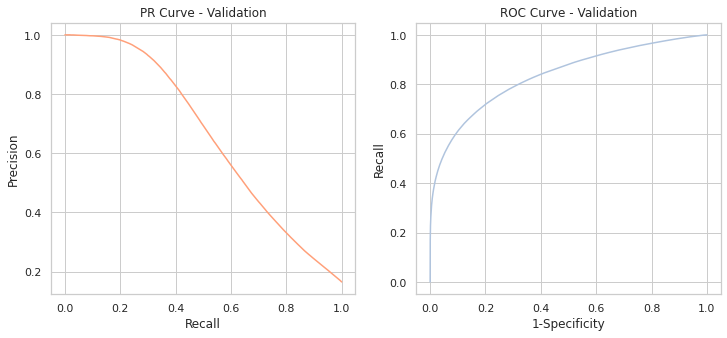

TRAIN YEAR: [2016, 2017]
VALID YEAR: [2018]
Baseline Model: Gradient Boosted Tree
 Train Validation
PR AUC 0.7425 0.6582
ROC AUC 0.8292 0.8343
F0.5 Score 0.6117 0.6080
F2 Score 0.6117 0.5623
Recall 0.4900 0.5485
Precision 0.8139 0.6250
Accuracy 0.8288 0.8711

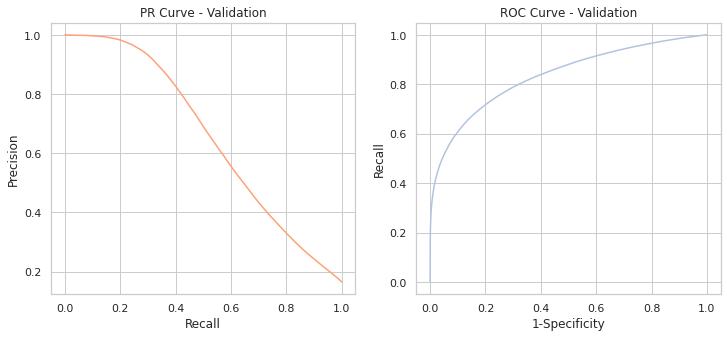

TRAIN YEAR: [2017]
VALID YEAR: [2018]
Baseline Model: Gradient Boosted Tree
 Train Validation
PR AUC 0.7496 0.6550
ROC AUC 0.8334 0.8330
F0.5 Score 0.6200 0.6081
F2 Score 0.6200 0.5602
Recall 0.4979 0.5459
Precision 0.8215 0.6259
Accuracy 0.8330 0.8711

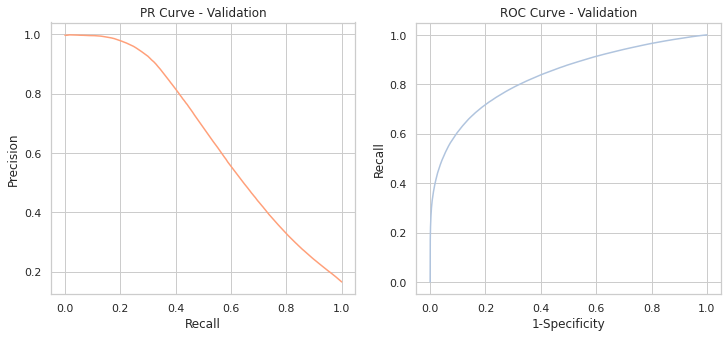

In [0]:
"""Optimizing number of years of data (i.e. 1 year, 2 years, or 3 years) 
to be included in the training set. Note that only 3 months (Oct, Nov, Dec)
of data are included from each year to save training resources.
"""
MODEL_SAVE_PATH = f'{ROOT_TEAM30_URL}/models'

MAX_ITER = 64
NEGATIVE_DOWNSAMPLE = (True, 0.4)
SCALE = False
MAX_DEPTH = 5
MAX_BINS = 256
STEP_SIZE = 0.1

results = {}
i = 0
for train_year_list, valid_year_list in zip(([2015, 2016, 2017], [2016, 2017], [2017]), 
                                            ([2018], [2018], [2018])):
    # load datasets
    train_df, valid_df, _ = build_datasets(CAT_FEATURES_CV,
                                           NUM_FEATURES_CV,
                                           train_years=train_year_list,
                                           valid_years=valid_year_list,
                                           downsample=NEGATIVE_DOWNSAMPLE, 
                                           scale=SCALE)
    # build model & train
    gbt = GBTClassifier(labelCol="LABEL", 
                        featuresCol="FEATURES", 
                        maxIter=MAX_ITER,
                        maxDepth=MAX_DEPTH,
                        maxBins=MAX_BINS,
                        stepSize=STEP_SIZE)
    model_gbt = gbt.fit(train_df)
    model_gbt.write().overwrite().save(f'{MODEL_SAVE_PATH}/gbt_ftune_year_{i}')
    i = i + 1

    # prediction
    preds_train = model_gbt.transform(train_df.select('LABEL', 'FEATURES'))
    preds_valid = model_gbt.transform(valid_df.select('LABEL', 'FEATURES'))

    # performance evaluation
    print(f'TRAIN YEAR: {train_year_list}')
    print(f'VALID YEAR: {valid_year_list}')
    evaluate(preds_train, preds_valid, 'Baseline Model: Gradient Boosted Tree')
    print('')

### Fine-tuning Classification Probability Threshold  
The last step in our fine-tuning funnel is to optimize the classification probability threshold for our primary metric, F0.5. We train our model using the full year of data from 2017 and measure the validation performance using 2018. The optimal threshold, determined by trial-and-error and visually examining the PR curve, is estimated to be 0.8.

Positive Class Probability Threshold: 0.8
GBT Final Model
 Train (2017) Valid (2018)
PR AUC 0.8050 0.6804
ROC AUC 0.8444 0.8387
F0.5 Score 0.5380 0.6885
F2 Score 0.5380 0.4230
Recall 0.3762 0.3749
Precision 0.9441 0.8706
Accuracy 0.7705 0.8751

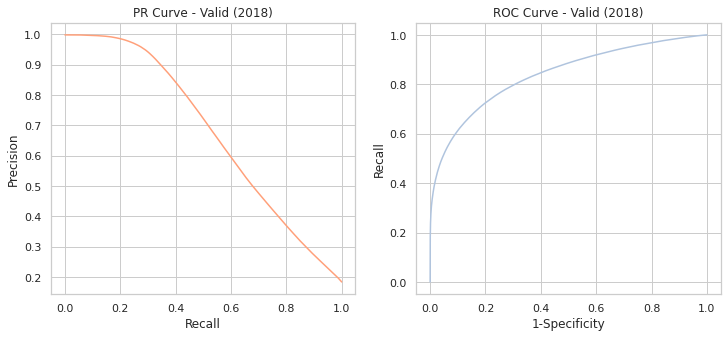

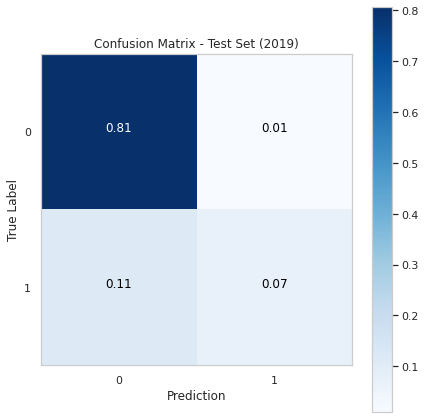

In [0]:
"""Fine-tuning the classification probability threshold. Note that 
the full year of data from 2017 and 2018 are now used for training/validation.
"""
POSITIVE_CLASS_PROB_THD = 0.8

LOAD_MODEL = True
MODEL_SAVE_PATH = f'{ROOT_TEAM30_URL}/models'

MAX_ITER = 64
NEGATIVE_DOWNSAMPLE = (True, 0.4)
SCALE = False
MAX_DEPTH = 5
MAX_BINS = 256
STEP_SIZE = 0.1

# load datasets
train_df, valid_df, _ = build_datasets(
                                  CAT_FEATURES_CV,
                                  NUM_FEATURES_CV,
                                  train_years=[2017],
                                  valid_years=[2018],
                                  downsample=NEGATIVE_DOWNSAMPLE, 
                                  scale=SCALE,
                                  build_test=False,
                                  filter_data=False)
valid_df = valid_df.where(f.col('LABEL').isNotNull())

# # train
if LOAD_MODEL:
    model_gbt = GBTClassificationModel().load(f'{MODEL_SAVE_PATH}/gbt_cv')
else:
    gbt = GBTClassifier(labelCol="LABEL", 
                        featuresCol="FEATURES", 
                        maxIter=MAX_ITER,
                        maxDepth=MAX_DEPTH,
                        maxBins=MAX_BINS,
                        stepSize=STEP_SIZE)
    model_gbt = gbt.fit(train_df)
    model_gbt.write().overwrite().save(f'{MODEL_SAVE_PATH}/gbt_cv')

# # # prediction
model_gbt.setThresholds([1-POSITIVE_CLASS_PROB_THD, POSITIVE_CLASS_PROB_THD])
preds_train = model_gbt.transform(train_df.select('LABEL', 'FEATURES'))
preds_valid = model_gbt.transform(valid_df.select('LABEL', 'FEATURES'))

# performance evaluation
print(f'Positive Class Probability Threshold: {POSITIVE_CLASS_PROB_THD}')
evaluate(preds_train, preds_valid, 'GBT Final Model', True, 'Train (2017)', 'Valid (2018)')
plot_confusion_matrix(preds_valid, 'Confusion Matrix - Test Set (2019)', rotate_matrix=False, normalize=True)

## Final Model

### Training & Performance
With the features selected and hyperparameters optimized, we now proceed to train our final model and test the performance using 2019 data. The selected features we choose are listed in the code cell below. Based on the test results in the fine-tuning section, our training set will be the full 2018 data, and the hyperparameters for GBT are listed below: 

MAX_ITER = 64  
NEGATIVE_DOWNSAMPLE = (True, 0.4)  
SCALE = False  
MAX_DEPTH = 5  
MAX_BINS = 256  
STEP_SIZE = 0.1  
POSITIVE_CLASS_PROB_THD = 0.8  

The final model, optimized for F0.5, achieves an overall **PRAUC of 0.6918** and an **F0.5 score of 0.7020**. This is a significant improvement from the GBT baseline model with a PRAUC of 0.6294 and an F0.5 score of 0.4859. However, our performance on F0.5 and precision comes with a significant cost at the recall score, which is quite low at 0.3749. Lastly, our final model's **training time is 3.32 hours** (2018) and **predicition time is 2.13 minutes** (2019).

In summary, our final model includes multiple new features that we built based on the hypothesis that “a delay is best predicted by other delays” and that “delays propagate through time and space.” We also include a number of weather features that can increase the stress level of an airport. These features are selected through a three steps funnel (relevance, WOE, and correlation heatmap analysis) as described in the Feature Selection section. We then select GBT as our final model out of the four baseline models we explore given its promising preliminary performance. We proceed to fine-tuning using CV as well as determine the optimal number of years of training and classification probability thresholds for producing the best F0.5 score.

In [0]:
"""Define final model features.
"""
CAT_FEATURES_FINAL = [
        'MONTH',
        'DAY_OF_MONTH',
        'DAY_OF_WEEK',
        'OP_CARRIER_AIRLINE_ID',
        'TAIL_NUM',
        'OP_CARRIER_FL_NUM',
        'ORIGIN_AIRPORT_ID',
        'DEST_AIRPORT_ID',
        'CRS_DEP_HOUR',
        'CRS_ARR_HOUR',
        'ORIGIN_POOR_VIS',
        'DEST_POOR_VIS',
        'PRIOR_ARR_DEL_INDEX',
        'PRIOR_ARR_DEL15',
        'PRIOR_DEP_DEL15',
        'PRIOR_DISTANCE_GROUP',
        'DEP_DEL_OEG_TREND_UP_1HR',
        'DEP_DEL_DEST_TREND_UP_1HR'
]
NUM_FEATURES_FINAL = [
        'CRS_ELAPSED_TIME',
        'ORIGIN_W_WND_SPD',
        'ORIGIN_W_CIG_DIM',
        'DEST_W_WND_SPD', 
        'DEST_W_CIG_DIM',
        'ORIGIN_FOG_RISK',
        'DEST_FOG_RISK',
        'CRS_GROUND_TIME_HOUR',
        'PRIOR_DEP_DEL_MINUTE',
        'DEP_DEL_MEAN_ODPAIR_PRIOR2HR',
        'AIRPORT_STRESS_ORG_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_DEST_PRIOR2HR_DEP_DEL_PROB',
        'AIRPORT_STRESS_ORG_PRIOR24HR_DEP_DEL15_PROB',
        'AIRPORT_STRESS_DEST_PRIOR24HR_DEP_DEL15_PROB',
        'DEP_WEATHER_DEL_DEST_SLOPE_1HR',
        'DEP_WEATHER_DEL_PROB_DEST_PRIOR_1HR',
        'DEP_DEL_DEST_SLOPE_1HR'
]

Positive Class Probability Threshold: 0.8
GBT Final Model
 Train (2018) Test (2019)
PR AUC 0.8044 0.6920
ROC AUC 0.8408 0.8416
F0.5 Score 0.5400 0.7027
F2 Score 0.5400 0.4410
Recall 0.3778 0.3923
Precision 0.9463 0.8760
Accuracy 0.7686 0.8765

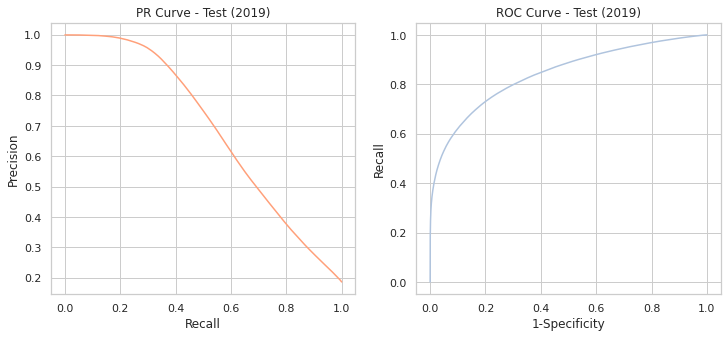

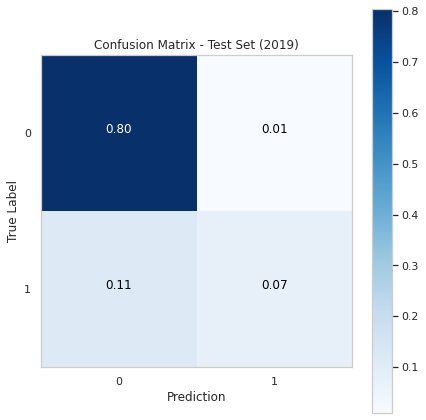

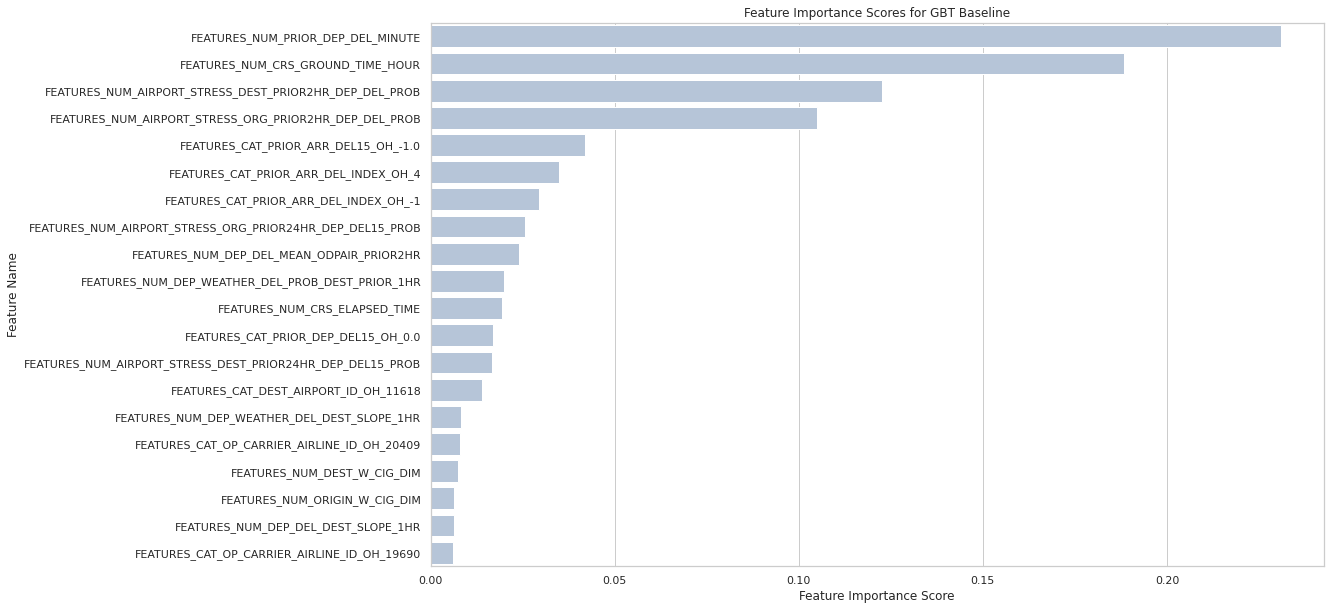

In [0]:
"""Model is trained on the full year of data.
"""
LOAD_MODEL = False
MODEL_SAVE_PATH = f'{ROOT_TEAM30_URL}/models'

MAX_ITER = 64
NEGATIVE_DOWNSAMPLE = (True, 0.4)
SCALE = False
MAX_DEPTH = 5
MAX_BINS = 256
STEP_SIZE = 0.1
POSITIVE_CLASS_PROB_THD = 0.8

# load datasets
train_df, _, test_df = build_datasets(CAT_FEATURES_FINAL,
                                      NUM_FEATURES_FINAL,
                                      train_years=[2018],
                                      test_years=[2019],
                                      downsample=NEGATIVE_DOWNSAMPLE, 
                                      scale=SCALE,
                                      build_test=True,
                                      filter_data=False)

# train
if LOAD_MODEL:
    model_gbt = GBTClassificationModel().load(f'{MODEL_SAVE_PATH}/gbt_final')
else:
    gbt = GBTClassifier(labelCol="LABEL", 
                        featuresCol="FEATURES", 
                        maxIter=MAX_ITER,
                        maxDepth=MAX_DEPTH,
                        maxBins=MAX_BINS,
                        stepSize=STEP_SIZE)
    model_gbt = gbt.fit(train_df)
    model_gbt.write().overwrite().save(f'{MODEL_SAVE_PATH}/gbt_final')

# # prediction
model_gbt.setThresholds([1-POSITIVE_CLASS_PROB_THD, POSITIVE_CLASS_PROB_THD])
preds_train = model_gbt.transform(train_df.select('LABEL', 'FEATURES'))
preds_test = model_gbt.transform(test_df.select('LABEL', 'FEATURES'))

# performance evaluation
print(f'Positive Class Probability Threshold: {POSITIVE_CLASS_PROB_THD}')
evaluate(preds_train, preds_test, 'GBT Final Model', True, 'Train (2018)', 'Test (2019)')
plot_confusion_matrix(preds_test, 'Confusion Matrix - Test Set (2019)', rotate_matrix=False, normalize=True)

**Note**: We choose to train our final using ONLY 2018 data. But just for fun, we also test the performance of our final model by training it using three years of date from 2016, 17, and 18. As expected, the performance does not improve and even drops slightly.

Positive Class Probability Threshold: 0.8
GBT Final Model
 Train (2016, 17, 18) Test (2019)
PR AUC 0.7996 0.6909
ROC AUC 0.8405 0.8415
F0.5 Score 0.5318 0.7013
F2 Score 0.5318 0.4379
Recall 0.3699 0.3892
Precision 0.9459 0.8772
Accuracy 0.7704 0.8761

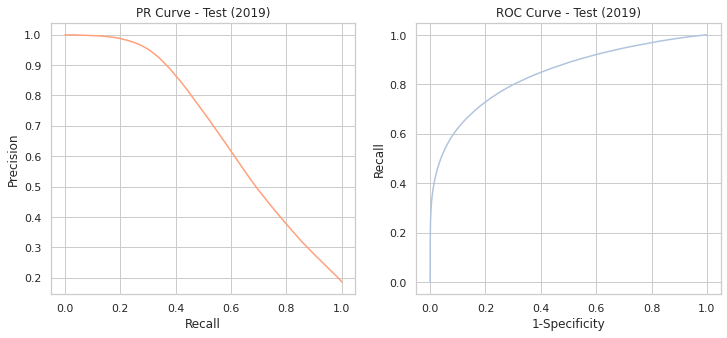

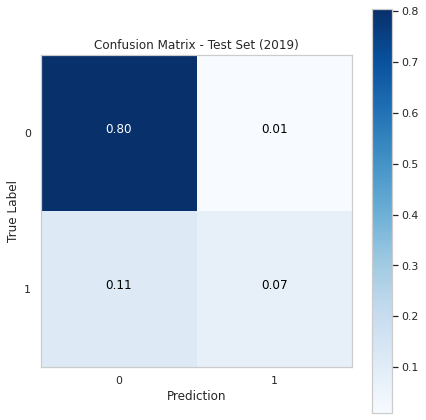

In [0]:
"""As an experiment, we also test the model trained on 
full 3 years of data. As expected, we do not see a significant 
difference in performance improvement. In fact, the performance even
dops a bit.
"""
LOAD_MODEL = False
MODEL_SAVE_PATH = f'{ROOT_TEAM30_URL}/models'

MAX_ITER = 64
NEGATIVE_DOWNSAMPLE = (True, 0.4)
SCALE = False
MAX_DEPTH = 5
MAX_BINS = 256
STEP_SIZE = 0.1
POSITIVE_CLASS_PROB_THD = 0.8

# load datasets
train_df, _, test_df = build_datasets(CAT_FEATURES_FINAL,
                                      NUM_FEATURES_FINAL,
                                      train_years=[2018, 2017, 2016],
                                      test_years=[2019],
                                      downsample=NEGATIVE_DOWNSAMPLE, 
                                      scale=SCALE,
                                      build_test=True,
                                      filter_data=False)

# train
if LOAD_MODEL:
    model_gbt = GBTClassificationModel().load(f'{MODEL_SAVE_PATH}/gbt_final_full')
else:
    gbt = GBTClassifier(labelCol="LABEL", 
                        featuresCol="FEATURES", 
                        maxIter=MAX_ITER,
                        maxDepth=MAX_DEPTH,
                        maxBins=MAX_BINS,
                        stepSize=STEP_SIZE)
    model_gbt = gbt.fit(train_df)
    model_gbt.write().overwrite().save(f'{MODEL_SAVE_PATH}/gbt_final_full')

# # prediction
model_gbt.setThresholds([1-POSITIVE_CLASS_PROB_THD, POSITIVE_CLASS_PROB_THD])
preds_train = model_gbt.transform(train_df.select('LABEL', 'FEATURES'))
preds_test = model_gbt.transform(test_df.select('LABEL', 'FEATURES'))

# performance evaluation
print(f'Positive Class Probability Threshold: {POSITIVE_CLASS_PROB_THD}')
evaluate(preds_train, preds_test, 'GBT Final Model', True, 'Train (2018)', 'Test (2019)')
plot_confusion_matrix(preds_test, 'Confusion Matrix - Test Set (2019)', rotate_matrix=False, normalize=True)

### Error Analysis
In this section we perform a simple EDA to analyze the wrong predictions made by our final model. Looking at the end performance, we decide to focus mostly on false negatives due to the low recalls achieved by the model. To perform the error analysis, we compare the **false negative predictions** produced by our final model against the **all 2019 positive examples** from the test set. The goal is to identify if there is any particular partition in the dataset that the model is systematically predicting incorrectly. Overall our error analysis can be summarized as follows:  
    
- **Late Aircraft Delays**: Our final model seems to be more effective in identifying `LATE_AIRCRAFT_DELAY` than other types of delays. Observe how `LATE_AIRCRAFT_DELAY` was the #1 cause in 2019 but becomes #3 after `CARRIER_DELAY` and `NAS_DELAY` in the predicted results.  
- **Group 12 Delays**: Delays are separated into 12 groups by the length of the delays. We learn from EDA that Group 12 show characteristics that are inherently different from the other groups. All our features and models are optimized against delays outside of Group 12. As such, we are surprised that our final model is actually somewhat effective in predicting Group 12 delays. Outside of Group 12 delays, however, we do not observe any systematic errors made by our final model.  
- **Airports & Temporal Factors**: False negatives are not specific to any month or airport.

Based on the preliminary error analysis presented in this section, we believe that we should investigate why our training pipeline has resulted in a relatively better performance on identifying `LATE_AIRCRAFT_DELAY` but not as much for other delay factors. One hypothesis is that our emphasis on “delay prorogation” might not be as effective in predicting `NAS_DELAY` and `CARRIER_DELAY`. The resolution for the issue demands further research and experimentations.

In [0]:
MODEL_SAVE_PATH = f'{ROOT_TEAM30_URL}/models'
POSITIVE_CLASS_PROB_THD = 0.8

# load prediction df
# _, _, test_df = build_datasets(
#                         CAT_FEATURES_FINAL,
#                         NUM_FEATURES_FINAL,
#                         train_years=[2018],
#                         test_years=[2019],
#                         build_test=True,
#                         filter_data=False)
final_model = GBTClassificationModel().load(f'{MODEL_SAVE_PATH}/gbt_final')

# predictins
final_model.setThresholds([1-POSITIVE_CLASS_PROB_THD, POSITIVE_CLASS_PROB_THD])
preds_test_df = final_model.transform(test_df)
preds_test_df = preds_test_df.select([col for col in test_df.columns if ('_OH' not in col) and ('_SI' not in col)]) \
                             .drop('FEATURES_CAT', 'FEATURES_NUM', 'FEATURES', 'probability').cache()

# false positive examples
examples_fp_pddf = preds_test_df.where((f.col('LABEL') == 0) & (f.col('PREDICTION') == 1)).toPandas()
# false negative examples
examples_fn_pddf = preds_test_df.where((f.col('LABEL') == 1) & (f.col('PREDICTION') == 0)).toPandas()

# full 2019 raw data
test_pddf = test_df.select([col for col in test_df.columns if ('_OH' not in col) and ('_SI' not in col)]) \
                   .drop('FEATURES_CAT', 'FEATURES_NUM', 'FEATURES').toPandas()

**Late Aircraft Delays**  
Our final model seems to be more effective in identifying LATE_AIRCRAFT_DELAY than other types of delays. Observe how LATE_AIRCRAFT_DELAY was the #1 cause in 2019 but becomes #3 after CARRIER_DELAY and NAS_DELAY in the predicted results.

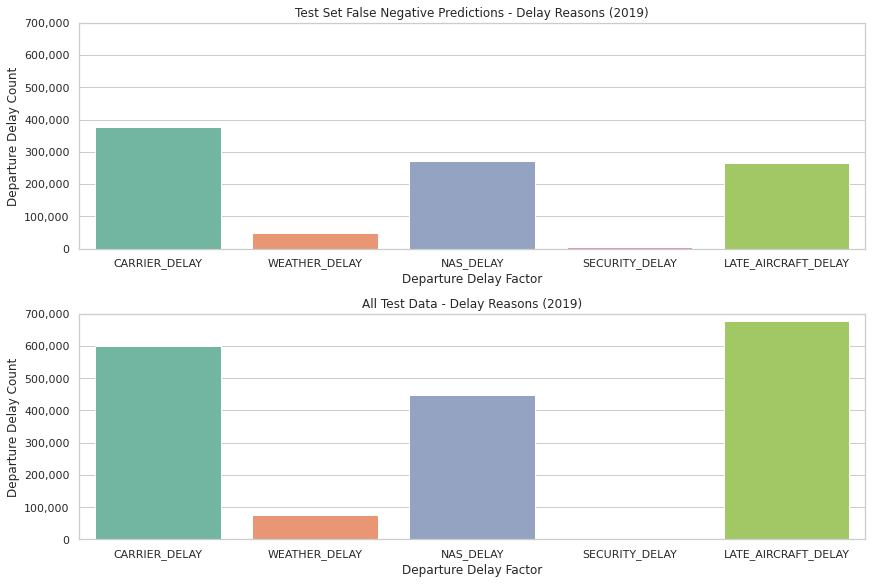

In [0]:
# pandas df for analysis
PRED_PDDF = examples_fn_pddf
RAW_PDDF = test_pddf.loc[test_pddf.LABEL==1]

def get_delay_reasons(df: pd.DataFrame) -> tuple:
    pddf = df.loc[:, [
                'CARRIER_DELAY', 
                'WEATHER_DELAY', 
                'NAS_DELAY', 
                'SECURITY_DELAY', 
                'LATE_AIRCRAFT_DELAY']].dropna()

    pddf['CARRIER_DELAY'] = pddf['CARRIER_DELAY'].astype(int)
    pddf['WEATHER_DELAY'] = pddf['WEATHER_DELAY'].astype(int)
    pddf['NAS_DELAY'] = pddf['NAS_DELAY'].astype(int)
    pddf['SECURITY_DELAY'] = pddf['SECURITY_DELAY'].astype(int)
    pddf['LATE_AIRCRAFT_DELAY'] = pddf['LATE_AIRCRAFT_DELAY'].astype(int)

    columns = []
    counts = []
    for i, col in enumerate(pddf.columns):
        df = pddf.iloc[:, i]
        columns.append(col)
        counts.append(df[df > 0].count())
        
    return columns, counts

sns.set(font_scale=1, style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)
  
# false negative
columns, counts = get_delay_reasons(PRED_PDDF)
sns.barplot(x=columns, y=counts, palette=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("Test Set False Negative Predictions - Delay Reasons (2019)")
axes[0].set_xlabel("Departure Delay Factor")
axes[0].set_ylabel("Departure Delay Count")
axes[0].set_ylim([0, 700000])
axes[0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 

# all data
columns, counts = get_delay_reasons(RAW_PDDF)
sns.barplot(x=columns, y=counts, palette=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("All Test Data - Delay Reasons (2019)")
axes[1].set_xlabel("Departure Delay Factor")
axes[1].set_ylabel("Departure Delay Count")
axes[1].set_ylim([0, 700000])
axes[1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
pass

**Group 12 Delays**  
Delays are separated into 12 groups by the length of the delays. We learn from EDA that Group 12 show characteristics that are inherently different from the other groups. All our features and models are optimized against delays outside of Group 12. As such, we are surprised that our final model is actually somewhat effective in predicting Group 12 delays. Outside of Group 12 delays, however, we do not observe any systematic errors made by our final model.

Note: Each group is a 15-minute delay interval, with Group 1 being 15~30 minutes and Group 12 being > 180 minutes.

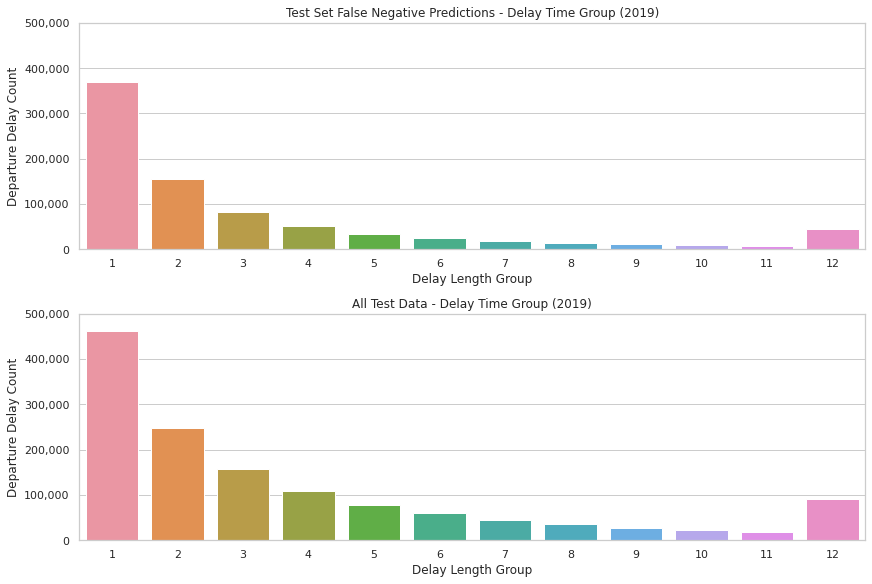

In [0]:
# pandas df for analysis
PRED_PDDF = examples_fn_pddf
RAW_PDDF = test_pddf.loc[test_pddf.LABEL==1]

print('Note: Each group is a 15-minute delay interval, with Group 1 being 15~30 minutes and Group 12 being > 180 minutes.')
sns.set(font_scale=1, style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)

# false negative
sns.countplot(x="DEP_DELAY_GROUP", data=PRED_PDDF, ax=axes[0])
axes[0].set_title("Test Set False Negative Predictions - Delay Time Group (2019)")
axes[0].set_xlabel("Delay Length Group")
axes[0].set_ylabel("Departure Delay Count")
axes[0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
axes[0].set_ylim([0, 500000])
plt.xticks(rotation=0)

# all data
sns.countplot(x="DEP_DELAY_GROUP", data=RAW_PDDF.loc[RAW_PDDF.DEP_DELAY_GROUP >= 1, :], ax=axes[1])
axes[1].set_title("All Test Data - Delay Time Group (2019)")
axes[1].set_xlabel("Delay Length Group")
axes[1].set_ylabel("Departure Delay Count")
axes[1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
axes[1].set_ylim([0, 500000])
plt.xticks(rotation=0)

plt.show()
pass

**Delays by Airports**  
False negatives produced by our final model do not look to be specific to any airport. The model is not particularly good or bad on predicating delays from a subgroups of airports.

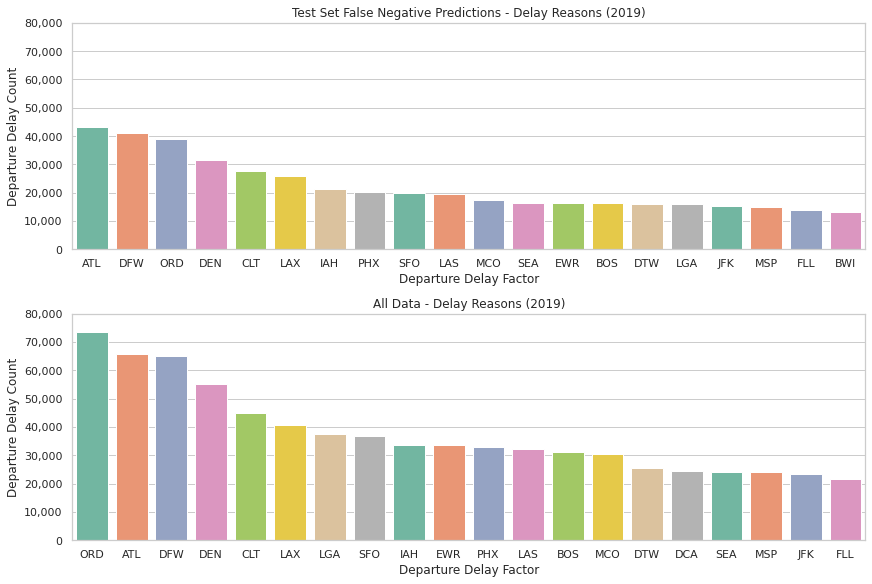

In [0]:
# pandas df for analysis
PRED_PDDF = examples_fn_pddf
RAW_PDDF = test_pddf.loc[test_pddf.LABEL==1]

sns.set(font_scale=1, style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)

# false negatives
dist_pddf = PRED_PDDF.groupby('ORIGIN').count()
dist_pddf = dist_pddf.sort_values(by='ID', ascending=False).iloc[0:20, :]
sns.barplot(x=dist_pddf.index, y=dist_pddf['ID'], palette=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("Test Set False Negative Predictions - Delay Reasons (2019)")
axes[0].set_xlabel("Departure Delay Factor")
axes[0].set_ylabel("Departure Delay Count")
axes[0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
axes[0].set_ylim([0, 80000])
plt.xticks(rotation=0)

# original
dist_pddf = RAW_PDDF.groupby('ORIGIN').count()
dist_pddf = dist_pddf.sort_values(by='ID', ascending=False).iloc[0:20, :]
sns.barplot(x=dist_pddf.index, y=dist_pddf['ID'], palette=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("All Data - Delay Reasons (2019)")
axes[1].set_xlabel("Departure Delay Factor")
axes[1].set_ylabel("Departure Delay Count")
axes[1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
axes[1].set_ylim([0, 80000])
plt.xticks(rotation=0)
pass

**Delays by Months**  
False negatives produced by our final model do not look to be specific to any month. The model is not particularly good or bad on predicating delays from certain months.

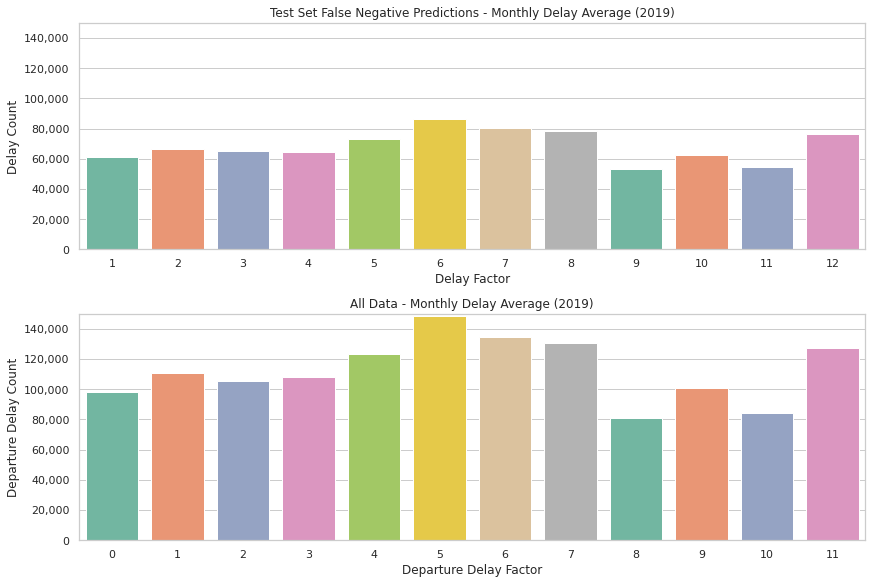

In [0]:
# pandas df for analysis
PRED_PDDF = examples_fn_pddf
RAW_PDDF = test_pddf.loc[test_pddf.LABEL==1]

sns.set(font_scale=1, style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)

# false negatives
dist_pddf = PRED_PDDF.astype({'MONTH': 'int32'})
dist_pddf = dist_pddf.groupby('MONTH').count()
dist_pddf = dist_pddf.reset_index().sort_values(
   by="MONTH"
)
sns.barplot(x=dist_pddf['MONTH'], y=dist_pddf['ID'], palette=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("Test Set False Negative Predictions - Monthly Delay Average (2019)")
axes[0].set_xlabel("Delay Factor")
axes[0].set_ylabel("Delay Count")
axes[0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
axes[0].set_ylim([0, 150000])
plt.xticks(rotation=0)

# original
dist_pddf = RAW_PDDF.astype({'MONTH': 'int32'})
dist_pddf['MONTH'] = dist_pddf['MONTH'] + 1
dist_pddf = dist_pddf.groupby('MONTH').count()
dist_pddf = dist_pddf.reset_index().sort_values(
   by="MONTH"
)
sns.barplot(x=dist_pddf.index, y=dist_pddf['ID'], palette=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("All Data - Monthly Delay Average (2019)")
axes[1].set_xlabel("Departure Delay Factor")
axes[1].set_ylabel("Departure Delay Count")
axes[1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
axes[1].set_ylim([0, 150000])
plt.xticks(rotation=0)
pass

## Conclusions
n this study, we build an end-to-end pipeline to predict 15-minute flight delays. Our performance metric is F0.5. We have two primary datasets: Airlines (from Bureau of Transportation Statistics) and Weather (from National Centers for Environmental Information) across 5 years from 2015 to 2019. The final model, optimized for F0.5, achieves an overall PRAUC of 0.6918 and an F0.5 score of 0.7020. However, our performance on F0.5 and precision comes with a significant tradeoff: Our recall is poor at only 0.3749.

Our training is limited to the time and resources we are given on Databricks. For example, we are unable to fine-tune our model parameters using full years of data for 3-fold cross validation. We also can’t perform a more exhaustive random grid search to further fine-tune the hyperparameters for our final model. However, given our error analysis, we believe that the “elephant” in the room is that our two main hypotheses on delay prorogation and stress distribution are simply not well explored or modelled given our current features and training mythology. To this end, we have a few possible candidates as the next step:

**Build More Insights on Errors**  
Investigate why our model is more effective at predicting Group 12 delays rather than the Group 1-11 delays that we optimize our model for. The goal is to develop a deeper understanding on exactly where and why our model is performing well or not well.  

**Develope and Test More Hypotheses**  
Consider refine our hypothesis and build/test more features and training mythologies. Upsampling through techniques such as SMOTE, building regression models to fill in missing weather data, and selecting features through other methods such as chi-square, or testing linear separability using Linear Discriminant Analysis are a few actions on the top of the list.  

**Experiment With Different Prediction Pipelines**  
Our baselines models show that both logistics and GBT show promising performance with minimal fine-tuning. Our EDA shows that delays can be fundamentally different depending on the category it belongs to. Cancels, diverts, group-12 delays, and short delays are all very different from each other, and the prediction of each demands a different model and feature set. Given the two insights, we hypothesize that a serial prediction summarized by the diagram below could be well suited for our prediction objective. Unfortunately, given the time and resource for the study, we only managed to build Model 4 for predicting the short delays. We believe that a separation of the four labels should lead to a significant improvement on performance. 

![Serial Predictions](https://www.dropbox.com/s/knrxsknu7c5rezy/serial.png?raw=1)

## Course Concepts  
**Parallel Computing**  
Central to our analysis is performing computations in parallel using Spark and the MapReduce framework. Here, our computation are spread out across multiple nodes to perform large-scale parallel computations, with (generally speaking) mappers applying a function to a subset of the data, which is then passed to the reducer(s) for aggregation. As much as we can, we aim for computations to be “embarrassingly parallel” - problems in which little to no effort is required to create independent and parallel computations possible. Looking at the algorithms that we used, in decision trees for example, selecting the best split point is a highly parallelizable process. Different mappers take on the task of setting up decision trees with different splitting points, which are then aggregated to a purity score by the reducer. This allows independent computations of various split points to find optimal values, with the calculations split across many nodes. An overview of distributed gradient descent used in logistic regression, SVM, and gradient boosted tree models is given below.

**Bias-Variance Tradeoff**  
The bias-variance tradeoff plays an important part in our model selection process. We must try to negotiate the minimizing of bias and the minimizing of variance. High bias will not be able to model the relationships in our data sufficiently and will lead to systematic underfitting, whereas high variance will end up modeling the noise in our data in addition to the true relationships, which will make it perform poorly on previously unseen data. Since bias and variance generally conflict with each other (increasing one decreases the other), it is important to try to find the model complexity that minimizes total error - mathematically, this is represented as the point where the increase in bias is equivalent to the reduction in variance. Various measures were taken to reduce overfitting in the various algorithms tested in our analysis - downsampling (sampling from each class disproportionately to balance the original 80/20 uneven negative/positive split), regularizing, cross-validating, and limiting tree depth and step size.
  
**Cross Validation**  
Cross validation was used for turning of our models. Here, the training data was split into 3 equally sized partitions (3-fold CV), allowing us to perform a mini test-train type split on our training data multiple times to tune our hyperparameters. An alternative approach is a least one out cross validation (LOOCV), in which all data points except one observation is used as training, and the left out observation is used as a validation set. This is repeated so that every observation is used once as a validation set, and an average is taken to calculate overall accuracy. Although this reduces bias, it is computationally expensive, and not suitable for our time-based data due to the leaks that is causes. Importantly, our cross validation analysis diverges from the commonly used sampling method in that our partitions were not sampled at random, due to the time-sensitive nature of our data. Each partition consists of data from a single year (to capture seasonal differences), and years are organized in a way to prevent data leaks.   
  
**Gradient Descent**  
We utilized gradient descent in the logistic regression, linear SVM and gradient boosted tree models to minimize the loss function. Given the loss functions are convex, we can use “first order” conditions to find the minimum of the functions. However, using the “first order” conditions, we need to solve a “closed form” math problem by setting all the partial derivatives equal to zero and solving for the parameters. This involves inverting large matrix and is very costly. On the other hand, the gradient descent approach is more scalable as each gradient can be computed independently and is fully parallel. Another concept related to gradient descent is the “learning rate”, which is a hyperparameter used in the 3 algorithms above. The learning rate controls the size of the updates to the parameters. If the learning rate (or step size) is too large, we run the risk of overshooting the true minimum and may not be able to converge. If it is too small, it will take a very long time to train.

**Graph Analysis**  
As airports and the flights form a traffic network, where airports are the nodes and flights between the airports are the edges, we utilized graph theory in EDA phase to help assess the airport stress. The graph is directed since each airport has both in flights and out flights. On application is to obtain PageRank score for each airport. We noted that there was no “randomness” in a flight going from one airport to a different airport, which is an underlying concept in PageRank algorithm. Thus, we realized that PageRank might not be useful in this case. Nonetheless, from the graph, another application is to determine if an airport is a transfer point. The transfer degree is calculated by the following equation: transfer degree = in-degree / out-degree. Essentially, we are calculating the ratio of flights "flying to" over "leaving from" an airport. The closer the transfer degree is to 1, the more likely the airport is acting as a transfer point. From this EDA, we generated ideas to build “airport” specific features, such as delay distribution by airport.

**ML Algorithms and Gini Gain**  
We used logistic regression, linear SVM, random forest and gradient boosted tree algorithms in this project. The algorithms are described in further details the “modeling” phase. For logistic regression and linear SVM, the algorithms assume a linear boundary between the features and outcome variable. For the tree-based algorithms, Gini impurity is used to determine the nodes to split on. Gini impurity measures the degree of randomness of a feature. Gini Gain is calculated by comparing the Gini impurity scores of the child node and the parent node to determine if there is sufficient information gain by splitting on the child node. From Spark implementation, we can obtain a “feature importance” ranking based on Gini Index for the tree-based algorithms.

## References  
[1] https://en.wikipedia.org/wiki/Gradient_boosting  
[2] https://towardsdatascience.com/a-visual-guide-to-gradient-boosted-trees-8d9ed578b33  
[3] http://www.chengli.io/tutorials/gradient_boosting.pdf    
[4] https://ieeexplore.ieee.org/document/8903554  
[5] http://web.mit.edu/hamsa/www/pubs/GopalakrishnanBalakrishnanATM2017.pdf  
[6] https://ieeexplore.ieee.org/document/9129110  
[7] G. Gui, F. Liu, J. Sun, J. Yang, Z. Zhou and D. Zhao, "Flight Delay Prediction Based on Aviation Big Data and Machine Learning," in IEEE Transactions on Vehicular Technology, vol. 69, no. 1, pp. 140-150, Jan. 2020, doi: 10.1109/TVT.2019.2954094.  
[8] F. Liu, J. Sun, M. Liu, J. Yang and G. Gui, "Generalized Flight Delay Prediction Method Using Gradient Boosting Decision Tree," 2020 IEEE 91st Vehicular Technology Conference (VTC2020-Spring), Antwerp, Belgium, 2020, pp. 1-5, doi: 10.1109/VTC2020-Spring48590.2020.9129110.  
[9] K. Gopalakrishnan and H. Balakrishnan. "A Comparative Analysis of Models for Predicting Delays in Air Traffic Networks," Proceedings of the USA/Europe Air Traffic Management R&D Seminar, June 2017

## Appendix

#### DBFS Utility
The section includes the queries used to manage DBFS.

In [0]:
LOCK = True
# doc: https://docs.databricks.com/_static/notebooks/dbutils.html
# doc: https://docs.databricks.com/data/filestore.html
  
if not LOCK:
    # w261 project DBFS
    display(dbutils.fs.ls("dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/"))

    # team30 DBFS
    dbutils.fs.mv('./FileStore/tables/airport_Id_weather_station_mapping.csv', './team_30/')
    dbutils.fs.cp('./team_30/_backup/weather_clean_full_v5.parquet', './team_30/weather_clean_full_v5.parquet.parquet', recurse=True)
    dbutils.fs.rm('./team_30/_backup/weather_clean_full_v3.parquet', recurse=True)
    dbutils.fs.mkdirs("./team_30/models/")
    display(dbutils.fs.ls('./team_30/_backup'))

    # upload iata.tzmap
    dbutils.fs.ls('./FileStore/tables/') # all uploaded files show up here
    dbutils.fs.mv('./FileStore/tables/iata.tzmap', './team_30/')
    pandas_df = pd.read_csv("/dbfs/FileStore/tables/odd_flights.csv", header='infer')

    # copy data to FileStore for downloading at https://dbc-c4580dc0-018b.cloud.databricks.com/files/PARQ_3m/
    dbutils.fs.ls(PARQ_WEATHER_FULL)
    dbutils.fs.cp(PARQ_2015_Q1, "/FileStore/PARQ_3m/", recurse=True)